In [59]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.init as init
import torch.nn as nn


from termcolor import cprint
from time import gmtime, strftime
from sklearn.neighbors import NearestNeighbors
import numpy as np
import argparse
import os
import glob
import random
import json
import h5py
import dateutil.tz
import datetime

from dataset_for_attention_unique_unseen import FeatDataLayer, DATA_LOADER, KnnFeat_attention, Classifier, map_label
from models import  _param, _netD_SC, _netCC_attention_multi_head, _netCC_3, _netCC_attention


In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if 'Linear' in classname:
        init.xavier_normal_(m.weight.data)
        init.constant_(m.bias, 0.0)


In [3]:

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='AwA2')
parser.add_argument('--dataroot', default='data',
                    help='path to dataset')
parser.add_argument('--matdataset', default=True, help='Data in matlab format')
parser.add_argument('--image_embedding', default='res101')
parser.add_argument('--class_embedding', default='att')
parser.add_argument('--preprocessing', action='store_true', default=False,
                    help='enbale MinMaxScaler on visual features')
parser.add_argument('--standardization', action='store_true', default=False)
parser.add_argument('--validation', action='store_true', default=False, help='enable cross validation mode')

parser.add_argument('--gpu', default='0', type=str, help='index of GPU to use')
parser.add_argument('--exp_idx', default='', type=str, help='exp idx')
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--resume',  type=str, help='the model to resume')

parser.add_argument('--z_dim',  type=int, default=300, help='dimension of the random vector z')
parser.add_argument('--disp_interval', type=int, default=40)
parser.add_argument('--save_interval', type=int, default=300)
parser.add_argument('--evl_interval',  type=int, default=20)

parser.add_argument('--random', action='store_true', default=False, help = 'random pairs in data preparation')
parser.add_argument('--endEpoch', type = int, default = 5000, help= 'train epoch')
parser.add_argument('--gzsl', action='store_true', default = False, help = 'gzsl evaluation')
parser.add_argument('--batchsize', type = int, default = 1024, help= 'batchsize')
parser.add_argument('--k_class', type = int, default = 1, help= 'find k similar classes')
parser.add_argument('--k_inst', type = int, default = 1, help= 'find k similar instances in each similar class')
parser.add_argument('--att_w', type = int, default = 10, help= 'weight of Att_loss')
parser.add_argument('--x_w', type = int, default = 40, help= 'weight of X_loss')
parser.add_argument('--lr_g', type = float, default = 0.0005, help= 'learning rate of generator')
parser.add_argument('--lr_d', type = float, default = 0.0001, help= 'learning rate of discriminator')
parser.add_argument("--clip_value", type=float, default=0.1, help="lower and upper clip value for disc. weights")
parser.add_argument('--cent_w', type = float, default = 10, help= 'CENT_LADMBDA')
parser.add_argument('--extended_attr_num', type = int, default = 0)

opt = parser.parse_args(args=[])
print('Running parameters:')
print(json.dumps(vars(opt), indent=4, separators=(',', ':')))

os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpu

""" hyper-parameter  """
opt.GP_LAMBDA = 10    # Gradient penalty lambda
opt.CENT_LAMBDA  = 10
opt.REG_W_LAMBDA = 0.001
opt.Adv_LAMBDA = 1

#opt.lr = 0.0001

""" hyper-parameter for testing"""
opt.nSample = 60  # number of fake feature for each class
opt.Knn = 20      # knn: the value of K
opt.in_features = 600
opt.out_features = 2048
opt.G_epoch = 2
opt.D_epoch = 1
opt.t = 0.01 # 计算adj: e**(-np.linalg.norm(s1-s2)/t)
opt.path_root = 'data/'


Running parameters:
{
    "dataset":"AwA2",
    "dataroot":"data",
    "matdataset":true,
    "image_embedding":"res101",
    "class_embedding":"att",
    "preprocessing":false,
    "standardization":false,
    "validation":false,
    "gpu":"0",
    "exp_idx":"",
    "manualSeed":null,
    "resume":null,
    "z_dim":300,
    "disp_interval":40,
    "save_interval":300,
    "evl_interval":20,
    "random":false,
    "endEpoch":5000,
    "gzsl":false,
    "batchsize":1024,
    "k_class":1,
    "k_inst":1,
    "att_w":10,
    "x_w":40,
    "lr_g":0.0005,
    "lr_d":0.0001,
    "clip_value":0.1,
    "cent_w":10,
    "extended_attr_num":0
}


In [4]:

# 用整个global features做attention
class _netCC_attention_multi_head(nn.Module):
    def __init__(self, opt):
        super(_netCC_attention_multi_head, self).__init__()
        self.att_dim = opt.att_dim
        self.k_inst = opt.k_inst  # num of samples for generating 1 sample
        self.num_attention_heads = opt.split_num  #  将2048维的visual feature 拆分成多个片段，进行attention
        self.hidden_dim = opt.x_dim

        self.attention_head_size = int(self.hidden_dim / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        
        # query value with attribute 
        self.query = nn.Sequential(nn.Linear(opt.att_dim, self.attention_head_size), nn.ReLU())
        self.key = nn.Sequential(nn.Linear(self.hidden_dim, self.all_head_size), nn.ReLU())
        self.value = nn.Sequential(nn.Linear(self.hidden_dim, self.all_head_size), nn.ReLU())

        # 做完self-attention 做一个前馈全连接 LayerNorm 输出
        # self.LayerNorm = LayerNorm(self.hidden_dim, eps=1e-12)  # 一组内的k个instance
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
        )       
        self.down1 = nn.Sequential(nn.Linear(self.hidden_dim + self.att_dim, 1024), nn.ReLU())
        self.down2 = nn.Sequential(nn.Linear(1024 + self.att_dim, 512), nn.ReLU())
        self.down3 = nn.Sequential(nn.Linear(512 + self.att_dim, 256), nn.ReLU())
        self.down4 = nn.Sequential(
            nn.Linear(256 + self.att_dim, self.att_dim), nn.ReLU()
        )

        self.up1 = nn.Sequential(nn.Linear(self.att_dim, 256), nn.ReLU())
        self.up2 = nn.Sequential(nn.Linear(256 + self.att_dim, 512), nn.ReLU())
        self.up3 = nn.Sequential(nn.Linear(512 + self.att_dim, 1024), nn.ReLU())
        self.up4 = nn.Sequential(nn.Linear(1024 + self.att_dim, self.hidden_dim), nn.ReLU())

    def transpose_for_scores(self, x):  # batch, k_inst, split_num 
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)  # 512, 4, 4, 512
        x = x.view(*new_x_shape) 
        return x.permute(0, 2, 1, 3)   # 512, 4, 4, 512 
    
    def forward(self, source_tensor, target_att, train=False):
        # source_tensor = self.LayerNorm(source_tensor)
        source_tensor = source_tensor.view(-1, self.k_inst, self.hidden_dim)

        mixed_query_layer = self.query(target_att)  # 512, 85
        # mixed_key_layer = self.key(source_tensor)  # 512, 4, 2048
        # mixed_value_layer = self.value(source_tensor) 
        mixed_key_layer = source_tensor  # 512, 4, 2048
        mixed_value_layer = source_tensor

        # 将query复制attention head次，与每一个head上的k_inst个inst相乘
        query_layer = mixed_query_layer.view(-1, 1, 1, self.attention_head_size).repeat_interleave(self.num_attention_heads, dim=1) 
        
        # query_layer = mixed_query_layer.view(-1, self.num_attention_heads, 1, self.attention_head_size)
        
        key_layer = self.transpose_for_scores(mixed_key_layer)  # 512, 4, 2048
        value_layer = self.transpose_for_scores(mixed_value_layer)  

        # Take the dot product between "query" and "key" to get the raw attention scores.
        # (512, 8, 1, 256) * (512, 8, 256, 4)  ->  (512, 8, 4) 
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2)) # batchsize, 8, 4, 4 得到四个分数
        
        # attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        
        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        
        # attention_probs = self.attn_dropout(attention_probs)
        #  (512, 8, 4) * (512, 8, 4, 256)  -> 
        context_layer = torch.matmul(attention_probs, value_layer) # batchsize, 8, 4, 256 
        
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()  # batchsize, 4, 8, 256 
        # new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        new_context_layer_shape = [-1, self.all_head_size]
        context_layer = context_layer.view(*new_context_layer_shape)
        
        # hidden_states = self.down(context_layer)
        # if train:
        #     return self.up(hidden_states), hidden_states
        # else:
        #     return self.up(hidden_states)
        
        return self.forward_(context_layer, target_att, train)
    
    def forward_(self, x, att2, train):
        x = torch.cat([x, att2], dim=1)
        x = self.down1(x)
        x = torch.cat([x, att2], 1)
        x = self.down2(x)
        x = torch.cat([x, att2], 1)
        x = self.down3(x)
        x = torch.cat([x, att2], 1)
        a = self.down4(x)
        
        x = self.up1(a)
        x = torch.cat([x, att2], 1)
        x = self.up2(x)
        x = torch.cat([x, att2], 1)
        x = self.up3(x)
        x = torch.cat([x, att2], 1)
        x = self.up4(x)
        if train:
            return x, a
        else:
            return x
        
class _netA(nn.Module):
    """ transforming attribute into visual space to obtaining accurate attributes.
    """
    def __init__(self, att_dim=85, v_dim=2048, class_num=50):
        super(_netA, self).__init__()
        # Discriminator net layer one
        self.fc1 = nn.Sequential(nn.Linear(att_dim, att_dim), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(att_dim, v_dim), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(v_dim, class_num))

    def forward(self, input, train=False):
        mid = self.fc1(input)
        vout = self.fc2(mid)
        logits = self.fc3(vout)
        if train:
            return vout, logits
        else:
            return mid

In [5]:
opt.k_class= 1
opt.k_inst = 8
opt.split_num=8
param = _param()
dataset = DATA_LOADER(opt)
preinputs = KnnFeat_attention(opt)
# preinputs = KnnFeat(opt)
param.X_dim = dataset.feature_dim
opt.x_dim = dataset.feature_dim
opt.att_dim = dataset.att_dim

if opt.random:
    data_layer = FeatDataLayer(dataset.train_label.numpy(), dataset.train_feature.numpy(), preinputs.train_sim_feature.numpy(), preinputs.train_sim_att_2.numpy(), opt)
else:
    data_layer = FeatDataLayer(preinputs.train_sim_label.numpy(), preinputs.train_sim_output.numpy(), preinputs.train_sim_feature.numpy(), preinputs.train_sim_att_2.numpy(), opt)
netG = _netCC_attention_multi_head(opt).cuda()
netG.apply(weights_init)

# netD = _netD_SC(dataset.train_cls_num+dataset.test_cls_num, dataset.feature_dim).cuda()
# netD.apply(weights_init)

netA = _netA(dataset.attribute.shape[-1], dataset.feature_dim).cuda()
print(netG)


123.....................
123.....................
read data2 ...
train_sim_feature.shape: torch.Size([23527, 8, 2048])
train_sim_output.shape: torch.Size([23527, 2048])
test_sim_feature: torch.Size([4000, 8, 2048])
test_sim_label: torch.Size([4000])
test_seen_sim_feature: torch.Size([16000, 8, 2048])
test_seen_sim_label: torch.Size([16000])
read data done.
Whole data length:23527, need 23 iterations.
_netCC_attention_multi_head(
  (query): Sequential(
    (0): Linear(in_features=85, out_features=256, bias=True)
    (1): ReLU()
  )
  (key): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
  )
  (value): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
  )
  (down1): Sequential(
    (0): Linear(in_features=2133, out_featur

In [32]:
# load model
model_path = 'data/AwA2/gan/Kcla1_Kinst4_2021_12_18_11_46_58/Best_model_ZSL_Acc_42.50_Epoch_1720.tar'
checkpoint = torch.load(model_path)
netG.load_state_dict(checkpoint['state_dict_G'])
netA.load_state_dict(checkpoint['state_dict_A'])
start_step = checkpoint['it']
print(checkpoint['log'])


Iter-1720_G; Euclidean_loss_target:4.912;reg_loss:4.238; GD_score_fake_loss: 8.380; GC_loss:1.337; x_loss:0.439; att_loss:0.826; G_all_loss:3.372; rl: 92.97%; fk: 93.16%; 


In [33]:
test_sim_feature, test_sim_att_2, test_sim_label = preinputs.test_sim_feature, preinputs.test_sim_att_2.view(-1, opt.att_dim), preinputs.test_sim_label.view(-1)
netG.eval()
G_sample = torch.randn(0).reshape(-1, opt.x_dim)
for i in dataset.unseenclasses:
    i = int(i)
    temp_x = test_sim_feature[test_sim_label==i]
    temp_att = test_sim_att_2[test_sim_label==i]
    g_sample = netG(temp_x.cuda(), temp_att.cuda())
    G_sample = torch.cat((G_sample, g_sample.detach().cpu()), dim=0)
    # G_label = torch.cat((G_label, torch.tensor([i]*G_sample.shape[0])), dim=0)
G_label = test_sim_label.long().numpy()

vout, _ = netA(dataset.attribute.cuda(), train=True)
vout = vout.detach().cpu().numpy()
att_trans = netA(dataset.attribute.cuda(), train=False).detach().cpu().numpy()

In [84]:
# test_seen
test_seen_sim_feature, test_seen_sim_att_2, test_seen_sim_label = preinputs.test_seen_sim_feature, preinputs.test_seen_sim_att_2, preinputs.test_seen_sim_label.view(-1)
netG.eval()
G_sample = torch.randn(0).reshape(-1, opt.x_dim)
G_label = np.array([]).reshape(-1)
for i in dataset.seenclasses[:10]:
    i = int(i)
    temp_x = test_seen_sim_feature[test_seen_sim_label==i]
    temp_att = test_seen_sim_att_2[test_seen_sim_label==i]
    g_sample = netG(temp_x.cuda(), temp_att.cuda())
    G_sample = torch.cat((G_sample, g_sample.detach().cpu()), dim=0)
    G_label = np.hstack((G_label, [i]*len(g_sample)))
G_label = G_label.astype(np.int64)


Text(0.5, 1.0, 'Generated_seen/unseen')

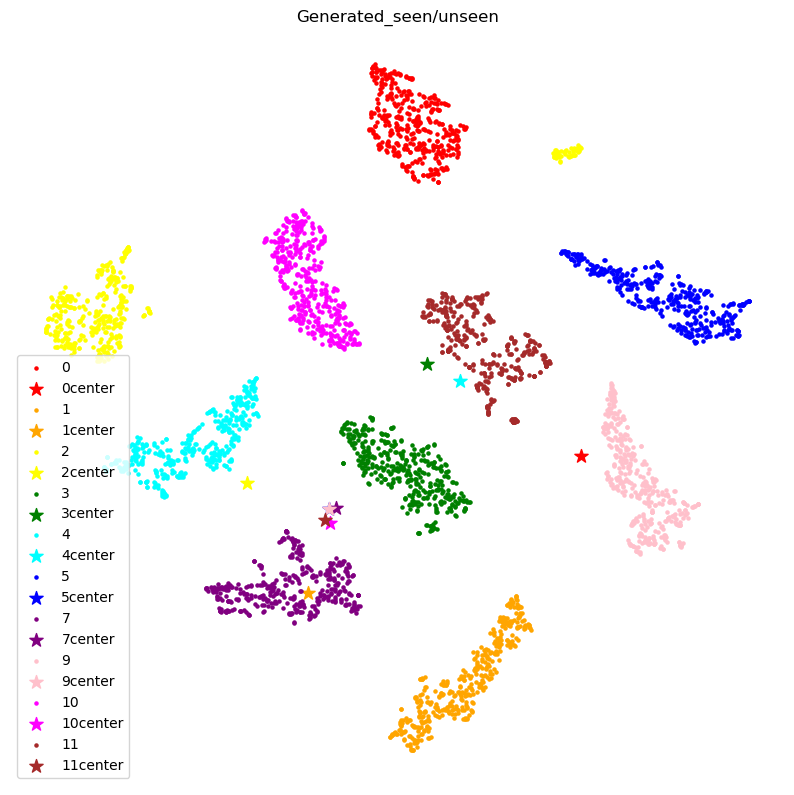

In [85]:
# 产生样本tsne
# 2-dim 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
visual_tsne = tsne.fit_transform(np.vstack((G_sample, vout)))
center_tsne = visual_tsne[-50:]

%matplotlib inline  
import matplotlib.pyplot as plt
# unseen class tsne
 #tsne.embedding_
postfix = 'generated_unseen_sample'
plt.figure(figsize=(10, 10),dpi=100)

#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
for index, cla in enumerate(np.unique(G_label)):
    class_index = np.where(G_label == cla)[0].tolist()
    plt.scatter(visual_tsne[class_index,0], visual_tsne[class_index,1],  c=cs[index], s=5, label=cla)
    plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[index], s=100, marker='*', label=str(cla)+'center')

plt.legend() 
plt.title('Generated_seen/unseen')

Text(0.5, 1.0, 'Generated_seen/unseen')

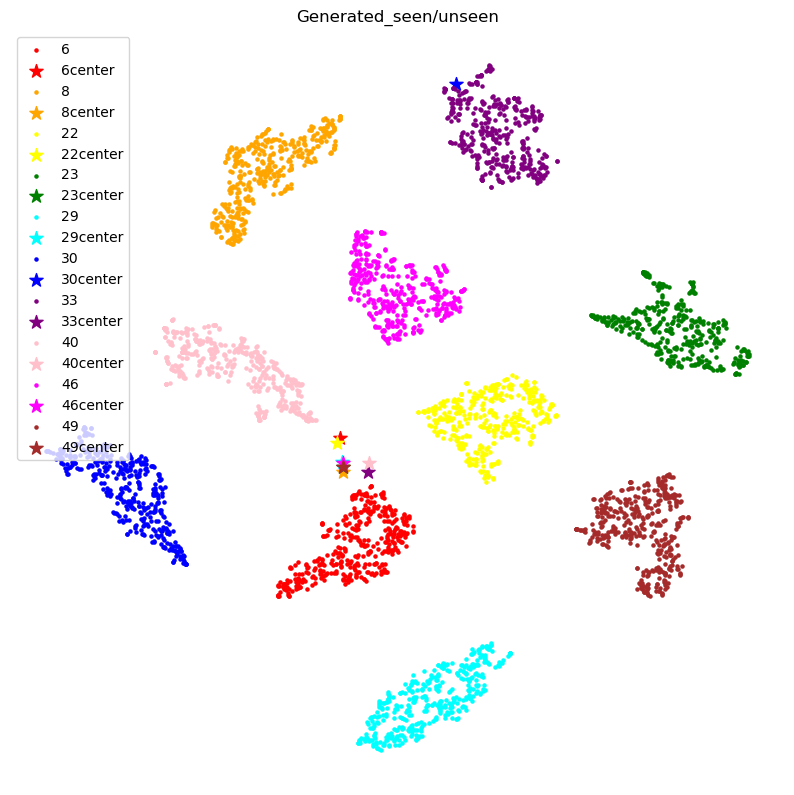

In [34]:

# 2-dim 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
visual_tsne = tsne.fit_transform(np.vstack((G_sample, vout)))
center_tsne = visual_tsne[-50:]

%matplotlib inline  
import matplotlib.pyplot as plt
# unseen class tsne
 #tsne.embedding_
postfix = 'generated_unseen_sample'
plt.figure(figsize=(10, 10),dpi=100)

#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
for index, cla in enumerate(np.unique(G_label)):
    class_index = np.where(G_label == cla)[0].tolist()
    plt.scatter(visual_tsne[class_index,0], visual_tsne[class_index,1],  c=cs[index], s=5, label=cla)
    plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[index], s=100, marker='*', label=str(cla)+'center')

plt.legend() 
plt.title('Generated_seen/unseen')

# Real and Fake sample of unseen tsne 

In [57]:
unseen_label = dataset.test_unseen_label.numpy()
unseen_sample = dataset.test_unseen_feature.numpy()

netG.eval()
R_sample = np.array([]).reshape(-1, opt.x_dim)
R_label = np.array([]).reshape(-1)

for i in dataset.unseenclasses:
    temp_x = unseen_sample[unseen_label==int(i)][:200]
    R_sample = np.vstack((R_sample, temp_x))
    R_label = np.hstack((R_label, np.array([i]*len(temp_x))))

# 2-dim 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
unseen_tsne = tsne.fit_transform(np.vstack((R_sample, G_sample.detach().numpy(), vout)))
unseen_tsne_label = np.hstack((R_label, G_label))
center_tsne = unseen_tsne[-50:]
is_gan = [0]*R_sample.shape[0] + [1]*G_sample.shape[0]


Text(0.5, 1.0, 'Real_and_generated_unseen_with center')

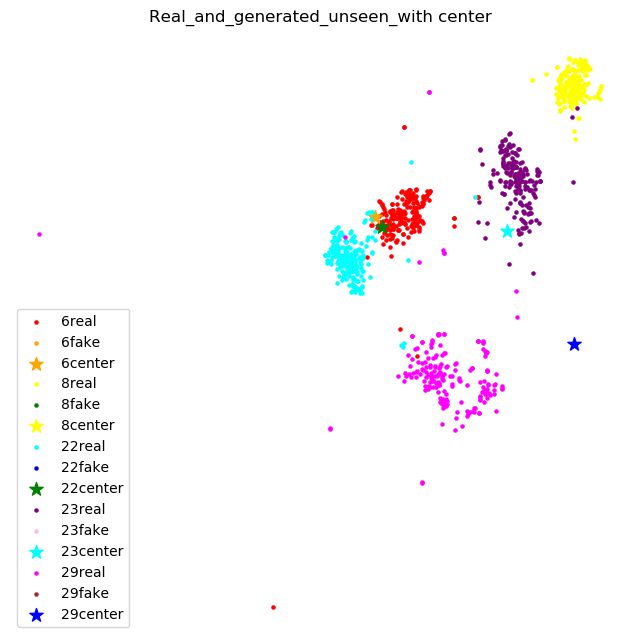

In [58]:

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8),dpi=100)

#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']

for index, cla in enumerate(dataset.unseenclasses.numpy()[:5]):
    class_index = np.where(unseen_tsne_label == cla)[0].tolist()
    real_index = [idx for idx in class_index if is_gan[idx] == 0]
    fake_index = [idx for idx in class_index if is_gan[idx] == 1]
    plt.scatter(unseen_tsne[real_index,0], unseen_tsne[real_index,1],  c=cs[2*index], s=5, label=str(cla)+'real')
    plt.scatter(unseen_tsne[fake_index,0], unseen_tsne[fake_index,1],  c=cs[2*index+1], s=5, label=str(cla)+'fake')
    
    plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[(index+1)%10], s=100, marker='*', label=str(cla)+'center')

plt.legend() 
plt.title('Real_and_generated_unseen_with center')


Text(0.5, 1.0, 'Real_and_generated_unseen_with center')

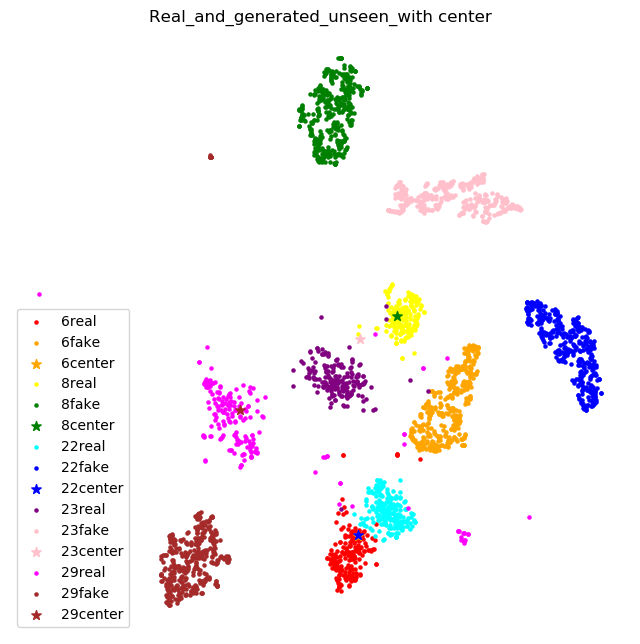

In [13]:

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8),dpi=100)

#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']

for index, cla in enumerate(dataset.unseenclasses.numpy()[:5]):
    class_index = np.where(unseen_tsne_label == cla)[0].tolist()
    real_index = [idx for idx in class_index if is_gan[idx] == 0]
    fake_index = [idx for idx in class_index if is_gan[idx] == 1]
    plt.scatter(unseen_tsne[real_index,0], unseen_tsne[real_index,1],  c=cs[2*index], s=5, label=str(cla)+'real')
    plt.scatter(unseen_tsne[fake_index,0], unseen_tsne[fake_index,1],  c=cs[2*index+1], s=5, label=str(cla)+'fake')
    
    plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[2*index+1], s=100, marker='*', label=str(cla)+'center')

plt.legend() 
plt.title('Real_and_generated_unseen_with center')


Text(0.5, 1.0, 'Real_and_generated_unseen')

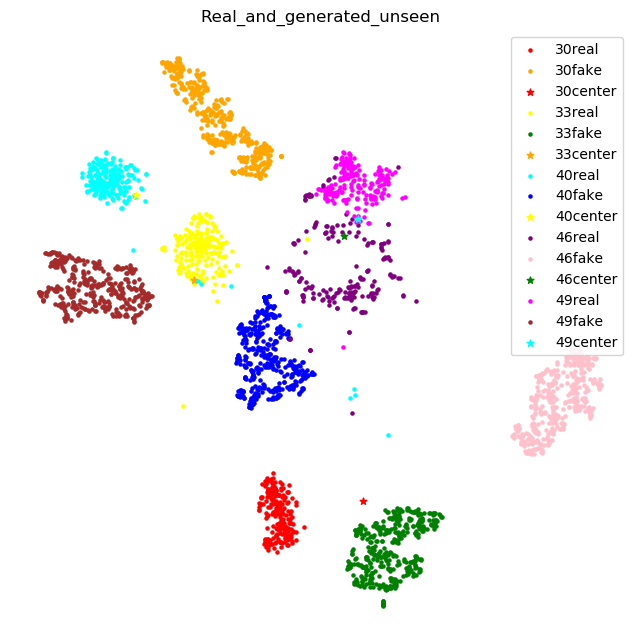

In [14]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8),dpi=100)

#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']

for index, cla in enumerate(dataset.unseenclasses.numpy()[5:]):
    class_index = np.where(unseen_tsne_label == cla)[0].tolist()
    real_index = [idx for idx in class_index if is_gan[idx] == 0]
    fake_index = [idx for idx in class_index if is_gan[idx] == 1]
    plt.scatter(unseen_tsne[real_index,0], unseen_tsne[real_index,1],  c=cs[2*index], s=5, label=str(cla)+'real')
    plt.scatter(unseen_tsne[fake_index,0], unseen_tsne[fake_index,1],  c=cs[2*index+1], s=5, label=str(cla)+'fake')

    plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[index], s=100, marker='*', label=str(cla)+'center')

plt.legend() 
plt.title('Real_and_generated_unseen')

# Real and Fake sample of seen tsne 

Text(0.5, 1.0, 'Real_and_generated_seen')

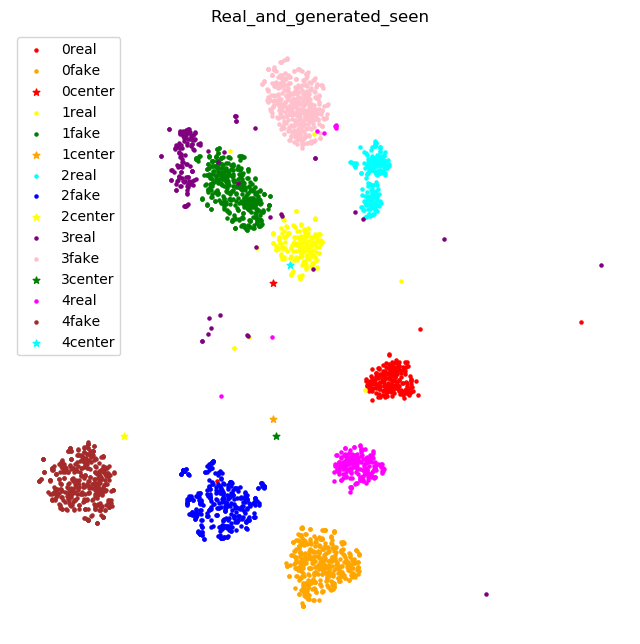

In [47]:
seen_label = dataset.train_label.numpy()
seen_sample = dataset.train_feature.numpy()

netG.eval()
R_sample = np.array([]).reshape(-1, opt.x_dim)
R_label = np.array([]).reshape(-1)

for i in dataset.seenclasses[:10]:
    temp_x = seen_sample[seen_label==int(i)][:200]
    R_sample = np.vstack((R_sample, temp_x))
    R_label = np.hstack((R_label, np.array([i]*len(temp_x))))

# 2-dim 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
seen_tsne = tsne.fit_transform(np.vstack((R_sample, G_sample.detach().numpy())))
seen_tsne_label = np.hstack((R_label, G_label))
center_tsne = seen_tsne[-50:]
is_gan = [0]*R_sample.shape[0] + [1]*G_sample.shape[0]

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8),dpi=100)

#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']

for index, cla in enumerate(dataset.seenclasses.numpy()[:5]):
    class_index = np.where(seen_tsne_label == cla)[0].tolist()
    real_index = [idx for idx in class_index if is_gan[idx] == 0]
    fake_index = [idx for idx in class_index if is_gan[idx] == 1]
    plt.scatter(seen_tsne[real_index,0], seen_tsne[real_index,1],  c=cs[2*index], s=5, label=str(cla)+'real')
    plt.scatter(seen_tsne[fake_index,0], seen_tsne[fake_index,1],  c=cs[2*index+1], s=5, label=str(cla)+'fake')
    
    plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[index], s=100, marker='*', label=str(cla)+'center')

plt.legend() 
plt.title('Real_and_generated_seen')


Text(0.5, 1.0, 'Real_and_generated_seen')

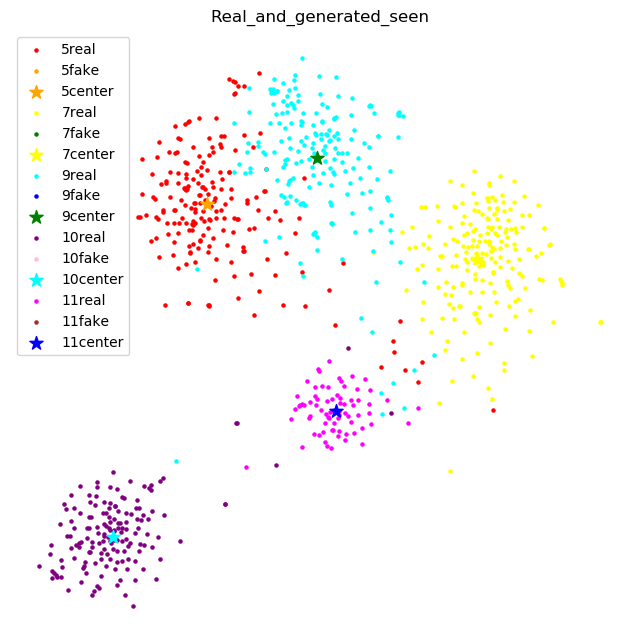

In [56]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8),dpi=100)

#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']

for index, cla in enumerate(dataset.seenclasses.numpy()[5:10]):
    class_index = np.where(seen_tsne_label == cla)[0].tolist()
    real_index = [idx for idx in class_index if is_gan[idx] == 0]
    fake_index = [idx for idx in class_index if is_gan[idx] == 1]
    plt.scatter(seen_tsne[real_index,0], seen_tsne[real_index,1],  c=cs[2*index], s=5, label=str(cla)+'real')
    plt.scatter(seen_tsne[fake_index,0], seen_tsne[fake_index,1],  c=cs[2*index+1], s=5, label=str(cla)+'fake')
    
    plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[(index+1)%10], s=100, marker='*', label=str(cla)+'center')

plt.legend() 
plt.title('Real_and_generated_seen')

In [215]:
netA

_netA(
  (att_trans): Sequential(
    (0): Linear(in_features=85, out_features=85, bias=True)
  )
  (encoder): Linear(in_features=85, out_features=2048, bias=True)
  (decoder): Linear(in_features=2048, out_features=85, bias=True)
)

In [217]:
class _netA(nn.Module):
    """ transforming attribute into visual space to obtaining accurate attributes.
    """
    def __init__(self, att_dim=85, v_dim=2048, class_num=50):
        super(_netA, self).__init__()
        # Discriminator net layer one
        self.att_trans = nn.Sequential(nn.Linear(att_dim, att_dim))
        self.encoder = nn.Linear(att_dim, v_dim)
        self.decoder = nn.Linear(v_dim, att_dim)
        self.act = nn.Tanh()
        # self.cls = nn.Sequential(nn.Linear(att_dim, class_num))

    def forward(self, _input, train=False):
        att = self.act(self.att_trans(_input))
        vout = self.act(self.encoder(att))
        if train:
            att = self.act(self.decoder(vout))
        return att, vout
            

netA = _netA(dataset.attribute.shape[-1], dataset.feature_dim).cuda()
# netD = torch.nn.DataParallel(netD)
netA.apply(weights_init)

tr_cls_centroid = Variable(torch.from_numpy(dataset.tr_cls_centroid.astype('float32'))).cuda()
optimizerA = optim.Adam(netA.parameters(), lr=opt.lr_d*10)

ce_loss = nn.CrossEntropyLoss().cuda()
mse_loss = nn.MSELoss().cuda()
best_acc = 0.0
print('start to training semantic transformation')
netA.train()
from tqdm import tqdm
pbar = tqdm(range(0, 10000))

print('unseen trained finish')
for it in pbar:
    blobs = data_layer.forward()
    feat_data = blobs['data'] # target class sample
    x = blobs['x'] # source class sample
    # att1 = blobs['att1']
    att = blobs['att2'] # target class attribute
    labels = blobs['labels'].astype(int)  # true class labels

    att = Variable(torch.from_numpy(att.astype('float32'))).view(-1, opt.att_dim).cuda()
    X = Variable(torch.from_numpy(feat_data.astype('float32'))).view(-1, opt.x_dim).cuda()
    y_true = Variable(torch.from_numpy(labels.astype('int'))).view(-1).cuda()
    # trian attribute transform
    aout, vout = netA(att, train=True)  # dim: 85, 2048
    att2v_mse_loss = mse_loss(vout, X)
    att2v_mse_loss2 = mse_loss(aout, att)

    att2v_loss = att2v_mse_loss + att2v_mse_loss2
    optimizerA.zero_grad()
    att2v_loss.backward()
    optimizerA.step()
#     print(logits.data.cpu().numpy())
#     print(np.argmax(logits.data.cpu().numpy(), axis=1))
#     print(y_true.data.cpu().numpy())
    acc_real = (np.argmax(logits.data.cpu().numpy(), axis=1) == y_true.data.cpu().numpy()).sum() / float(y_true.data.size()[0])
    pbar.set_description('Att2v_loss:{:^7.3f};MSE_loss_visual:{:^7.3f};MSE_loss_att:{:^7.3f}'.format(att2v_loss.item(),att2v_mse_loss.item(),att2v_mse_loss2.item()))














  0%|          | 0/10000 [00:00<?, ?it/s]

start to training semantic transformation
unseen trained finish














Att2v_loss: 1.682 ;MSE_loss_visual: 0.709 ;MSE_loss_att: 0.973 :   0%|          | 0/10000 [00:00<?, ?it/s]











Att2v_loss: 1.682 ;MSE_loss_visual: 0.709 ;MSE_loss_att: 0.973 :   0%|          | 1/10000 [00:00<40:44,  4.09it/s]











Att2v_loss: 1.426 ;MSE_loss_visual: 0.721 ;MSE_loss_att: 0.705 :   0%|          | 1/10000 [00:00<40:44,  4.09it/s]











Att2v_loss: 1.426 ;MSE_loss_visual: 0.721 ;MSE_loss_att: 0.705 :   0%|          | 2/10000 [00:00<34:04,  4.89it/s]











Att2v_loss: 1.248 ;MSE_loss_visual: 0.717 ;MSE_loss_att: 0.531 :   0%|          | 2/10000 [00:00<34:04,  4.89it/s]











Att2v_loss: 1.248 ;MSE_loss_visual: 0.717 ;MSE_loss_att: 0.531 :   0%|          | 3/10000 [00:00<39:32,  4.21it/s]











Att2v_loss: 1.170 ;MSE_loss_visual: 0.737 ;MSE_loss_att: 0.433 :   0%|          | 3/10000 [00:00<39:32,  4.21it/s]











Att2v_loss: 1.080 ;MSE_loss_visual: 0.710 ;MSE_loss_att: 0.371 :   0%|          | 3/10000 [00:00<39:32,  4.21it/s]

Att2v_loss: 0.837 ;MSE_loss_visual: 0.640 ;MSE_loss_att: 0.198 :   0%|          | 33/10000 [00:05<27:08,  6.12it/s]











Att2v_loss: 0.849 ;MSE_loss_visual: 0.651 ;MSE_loss_att: 0.198 :   0%|          | 33/10000 [00:05<27:08,  6.12it/s]











Att2v_loss: 0.843 ;MSE_loss_visual: 0.644 ;MSE_loss_att: 0.199 :   0%|          | 33/10000 [00:05<27:08,  6.12it/s]











Att2v_loss: 0.843 ;MSE_loss_visual: 0.644 ;MSE_loss_att: 0.199 :   0%|          | 35/10000 [00:05<24:16,  6.84it/s]











Att2v_loss: 0.835 ;MSE_loss_visual: 0.641 ;MSE_loss_att: 0.194 :   0%|          | 35/10000 [00:05<24:16,  6.84it/s]











Att2v_loss: 0.821 ;MSE_loss_visual: 0.626 ;MSE_loss_att: 0.196 :   0%|          | 35/10000 [00:05<24:16,  6.84it/s]











Att2v_loss: 0.821 ;MSE_loss_visual: 0.626 ;MSE_loss_att: 0.196 :   0%|          | 37/10000 [00:05<23:40,  7.01it/s]











Att2v_loss: 0.808 ;MSE_loss_visual: 0.617 ;MSE_loss_att: 0.191 :   0%|          | 37/10000 [00:05<23:40,  7.01i

Att2v_loss: 0.709 ;MSE_loss_visual: 0.523 ;MSE_loss_att: 0.186 :   1%|          | 65/10000 [00:09<21:57,  7.54it/s]











Att2v_loss: 0.709 ;MSE_loss_visual: 0.523 ;MSE_loss_att: 0.186 :   1%|          | 67/10000 [00:09<19:48,  8.36it/s]











Att2v_loss: 0.705 ;MSE_loss_visual: 0.520 ;MSE_loss_att: 0.185 :   1%|          | 67/10000 [00:09<19:48,  8.36it/s]











Att2v_loss: 0.711 ;MSE_loss_visual: 0.525 ;MSE_loss_att: 0.186 :   1%|          | 67/10000 [00:09<19:48,  8.36it/s]











Att2v_loss: 0.711 ;MSE_loss_visual: 0.525 ;MSE_loss_att: 0.186 :   1%|          | 69/10000 [00:09<19:54,  8.31it/s]











Att2v_loss: 0.726 ;MSE_loss_visual: 0.533 ;MSE_loss_att: 0.192 :   1%|          | 69/10000 [00:09<19:54,  8.31it/s]











Att2v_loss: 0.692 ;MSE_loss_visual: 0.505 ;MSE_loss_att: 0.187 :   1%|          | 69/10000 [00:09<19:54,  8.31it/s]











Att2v_loss: 0.692 ;MSE_loss_visual: 0.505 ;MSE_loss_att: 0.187 :   1%|          | 71/10000 [00:09<18:58,  8.72i

Att2v_loss: 0.646 ;MSE_loss_visual: 0.461 ;MSE_loss_att: 0.185 :   1%|          | 99/10000 [00:13<20:31,  8.04it/s]











Att2v_loss: 0.657 ;MSE_loss_visual: 0.468 ;MSE_loss_att: 0.189 :   1%|          | 99/10000 [00:13<20:31,  8.04it/s]











Att2v_loss: 0.657 ;MSE_loss_visual: 0.468 ;MSE_loss_att: 0.189 :   1%|          | 101/10000 [00:13<19:13,  8.58it/s]











Att2v_loss: 0.650 ;MSE_loss_visual: 0.464 ;MSE_loss_att: 0.186 :   1%|          | 101/10000 [00:13<19:13,  8.58it/s]











Att2v_loss: 0.654 ;MSE_loss_visual: 0.472 ;MSE_loss_att: 0.183 :   1%|          | 101/10000 [00:13<19:13,  8.58it/s]











Att2v_loss: 0.654 ;MSE_loss_visual: 0.472 ;MSE_loss_att: 0.183 :   1%|          | 103/10000 [00:13<18:21,  8.98it/s]











Att2v_loss: 0.626 ;MSE_loss_visual: 0.450 ;MSE_loss_att: 0.176 :   1%|          | 103/10000 [00:13<18:21,  8.98it/s]











Att2v_loss: 0.644 ;MSE_loss_visual: 0.461 ;MSE_loss_att: 0.184 :   1%|          | 103/10000 [00:14<18:21, 

Att2v_loss: 0.629 ;MSE_loss_visual: 0.441 ;MSE_loss_att: 0.188 :   1%|▏         | 133/10000 [00:16<10:47, 15.24it/s]











Att2v_loss: 0.626 ;MSE_loss_visual: 0.445 ;MSE_loss_att: 0.181 :   1%|▏         | 133/10000 [00:16<10:47, 15.24it/s]











Att2v_loss: 0.632 ;MSE_loss_visual: 0.453 ;MSE_loss_att: 0.178 :   1%|▏         | 133/10000 [00:16<10:47, 15.24it/s]











Att2v_loss: 0.632 ;MSE_loss_visual: 0.453 ;MSE_loss_att: 0.178 :   1%|▏         | 135/10000 [00:16<10:39, 15.42it/s]











Att2v_loss: 0.632 ;MSE_loss_visual: 0.449 ;MSE_loss_att: 0.183 :   1%|▏         | 135/10000 [00:16<10:39, 15.42it/s]











Att2v_loss: 0.616 ;MSE_loss_visual: 0.436 ;MSE_loss_att: 0.180 :   1%|▏         | 135/10000 [00:16<10:39, 15.42it/s]











Att2v_loss: 0.616 ;MSE_loss_visual: 0.436 ;MSE_loss_att: 0.180 :   1%|▏         | 137/10000 [00:16<10:35, 15.53it/s]











Att2v_loss: 0.629 ;MSE_loss_visual: 0.442 ;MSE_loss_att: 0.187 :   1%|▏         | 137/10000 [00:16<10:35

Att2v_loss: 0.625 ;MSE_loss_visual: 0.439 ;MSE_loss_att: 0.186 :   2%|▏         | 165/10000 [00:18<09:47, 16.74it/s]











Att2v_loss: 0.625 ;MSE_loss_visual: 0.439 ;MSE_loss_att: 0.186 :   2%|▏         | 167/10000 [00:18<09:45, 16.79it/s]











Att2v_loss: 0.618 ;MSE_loss_visual: 0.438 ;MSE_loss_att: 0.180 :   2%|▏         | 167/10000 [00:18<09:45, 16.79it/s]











Att2v_loss: 0.610 ;MSE_loss_visual: 0.432 ;MSE_loss_att: 0.179 :   2%|▏         | 167/10000 [00:18<09:45, 16.79it/s]











Att2v_loss: 0.610 ;MSE_loss_visual: 0.432 ;MSE_loss_att: 0.179 :   2%|▏         | 169/10000 [00:18<09:34, 17.12it/s]











Att2v_loss: 0.615 ;MSE_loss_visual: 0.436 ;MSE_loss_att: 0.179 :   2%|▏         | 169/10000 [00:18<09:34, 17.12it/s]











Att2v_loss: 0.622 ;MSE_loss_visual: 0.438 ;MSE_loss_att: 0.184 :   2%|▏         | 169/10000 [00:18<09:34, 17.12it/s]











Att2v_loss: 0.622 ;MSE_loss_visual: 0.438 ;MSE_loss_att: 0.184 :   2%|▏         | 171/10000 [00:18<09:25

Att2v_loss: 0.625 ;MSE_loss_visual: 0.434 ;MSE_loss_att: 0.190 :   2%|▏         | 199/10000 [00:20<09:02, 18.06it/s]











Att2v_loss: 0.609 ;MSE_loss_visual: 0.427 ;MSE_loss_att: 0.182 :   2%|▏         | 199/10000 [00:20<09:02, 18.06it/s]











Att2v_loss: 0.609 ;MSE_loss_visual: 0.427 ;MSE_loss_att: 0.182 :   2%|▏         | 201/10000 [00:20<09:01, 18.09it/s]











Att2v_loss: 0.604 ;MSE_loss_visual: 0.424 ;MSE_loss_att: 0.180 :   2%|▏         | 201/10000 [00:20<09:01, 18.09it/s]











Att2v_loss: 0.605 ;MSE_loss_visual: 0.426 ;MSE_loss_att: 0.179 :   2%|▏         | 201/10000 [00:20<09:01, 18.09it/s]











Att2v_loss: 0.605 ;MSE_loss_visual: 0.426 ;MSE_loss_att: 0.179 :   2%|▏         | 203/10000 [00:20<09:01, 18.10it/s]











Att2v_loss: 0.609 ;MSE_loss_visual: 0.432 ;MSE_loss_att: 0.177 :   2%|▏         | 203/10000 [00:20<09:01, 18.10it/s]











Att2v_loss: 0.608 ;MSE_loss_visual: 0.426 ;MSE_loss_att: 0.183 :   2%|▏         | 203/10000 [00:20<09:01

Att2v_loss: 0.611 ;MSE_loss_visual: 0.436 ;MSE_loss_att: 0.175 :   2%|▏         | 233/10000 [00:22<09:00, 18.07it/s]











Att2v_loss: 0.617 ;MSE_loss_visual: 0.435 ;MSE_loss_att: 0.182 :   2%|▏         | 233/10000 [00:22<09:00, 18.07it/s]











Att2v_loss: 0.612 ;MSE_loss_visual: 0.431 ;MSE_loss_att: 0.181 :   2%|▏         | 233/10000 [00:22<09:00, 18.07it/s]











Att2v_loss: 0.612 ;MSE_loss_visual: 0.431 ;MSE_loss_att: 0.181 :   2%|▏         | 235/10000 [00:22<09:02, 18.01it/s]











Att2v_loss: 0.604 ;MSE_loss_visual: 0.427 ;MSE_loss_att: 0.177 :   2%|▏         | 235/10000 [00:22<09:02, 18.01it/s]











Att2v_loss: 0.602 ;MSE_loss_visual: 0.427 ;MSE_loss_att: 0.175 :   2%|▏         | 235/10000 [00:22<09:02, 18.01it/s]











Att2v_loss: 0.602 ;MSE_loss_visual: 0.427 ;MSE_loss_att: 0.175 :   2%|▏         | 237/10000 [00:22<09:01, 18.03it/s]











Att2v_loss: 0.595 ;MSE_loss_visual: 0.419 ;MSE_loss_att: 0.176 :   2%|▏         | 237/10000 [00:22<09:01

Att2v_loss: 0.608 ;MSE_loss_visual: 0.428 ;MSE_loss_att: 0.181 :   3%|▎         | 265/10000 [00:24<08:59, 18.06it/s]











Att2v_loss: 0.608 ;MSE_loss_visual: 0.428 ;MSE_loss_att: 0.181 :   3%|▎         | 267/10000 [00:24<08:59, 18.06it/s]











Att2v_loss: 0.602 ;MSE_loss_visual: 0.421 ;MSE_loss_att: 0.181 :   3%|▎         | 267/10000 [00:24<08:59, 18.06it/s]











Att2v_loss: 0.601 ;MSE_loss_visual: 0.422 ;MSE_loss_att: 0.179 :   3%|▎         | 267/10000 [00:24<08:59, 18.06it/s]











Att2v_loss: 0.601 ;MSE_loss_visual: 0.422 ;MSE_loss_att: 0.179 :   3%|▎         | 269/10000 [00:24<08:58, 18.08it/s]











Att2v_loss: 0.603 ;MSE_loss_visual: 0.427 ;MSE_loss_att: 0.177 :   3%|▎         | 269/10000 [00:24<08:58, 18.08it/s]











Att2v_loss: 0.611 ;MSE_loss_visual: 0.427 ;MSE_loss_att: 0.184 :   3%|▎         | 269/10000 [00:24<08:58, 18.08it/s]











Att2v_loss: 0.611 ;MSE_loss_visual: 0.427 ;MSE_loss_att: 0.184 :   3%|▎         | 271/10000 [00:24<08:58

Att2v_loss: 0.593 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.180 :   3%|▎         | 299/10000 [00:25<08:56, 18.09it/s]











Att2v_loss: 0.605 ;MSE_loss_visual: 0.428 ;MSE_loss_att: 0.177 :   3%|▎         | 299/10000 [00:25<08:56, 18.09it/s]











Att2v_loss: 0.605 ;MSE_loss_visual: 0.428 ;MSE_loss_att: 0.177 :   3%|▎         | 301/10000 [00:25<08:58, 18.03it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.177 :   3%|▎         | 301/10000 [00:26<08:58, 18.03it/s]











Att2v_loss: 0.600 ;MSE_loss_visual: 0.419 ;MSE_loss_att: 0.181 :   3%|▎         | 301/10000 [00:26<08:58, 18.03it/s]











Att2v_loss: 0.600 ;MSE_loss_visual: 0.419 ;MSE_loss_att: 0.181 :   3%|▎         | 303/10000 [00:26<08:58, 18.01it/s]











Att2v_loss: 0.604 ;MSE_loss_visual: 0.425 ;MSE_loss_att: 0.179 :   3%|▎         | 303/10000 [00:26<08:58, 18.01it/s]











Att2v_loss: 0.604 ;MSE_loss_visual: 0.424 ;MSE_loss_att: 0.180 :   3%|▎         | 303/10000 [00:26<08:58

Att2v_loss: 0.596 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.179 :   3%|▎         | 333/10000 [00:27<08:54, 18.09it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.175 :   3%|▎         | 333/10000 [00:27<08:54, 18.09it/s]











Att2v_loss: 0.600 ;MSE_loss_visual: 0.422 ;MSE_loss_att: 0.178 :   3%|▎         | 333/10000 [00:27<08:54, 18.09it/s]











Att2v_loss: 0.600 ;MSE_loss_visual: 0.422 ;MSE_loss_att: 0.178 :   3%|▎         | 335/10000 [00:27<08:54, 18.10it/s]











Att2v_loss: 0.604 ;MSE_loss_visual: 0.423 ;MSE_loss_att: 0.181 :   3%|▎         | 335/10000 [00:27<08:54, 18.10it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.182 :   3%|▎         | 335/10000 [00:27<08:54, 18.10it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.182 :   3%|▎         | 337/10000 [00:27<08:53, 18.11it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.176 :   3%|▎         | 337/10000 [00:28<08:53

Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :   4%|▎         | 365/10000 [00:29<08:52, 18.08it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :   4%|▎         | 367/10000 [00:29<08:54, 18.03it/s]











Att2v_loss: 0.599 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.185 :   4%|▎         | 367/10000 [00:29<08:54, 18.03it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.175 :   4%|▎         | 367/10000 [00:29<08:54, 18.03it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.175 :   4%|▎         | 369/10000 [00:29<08:53, 18.05it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.176 :   4%|▎         | 369/10000 [00:29<08:53, 18.05it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.178 :   4%|▎         | 369/10000 [00:29<08:53, 18.05it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.178 :   4%|▎         | 371/10000 [00:29<08:52

Att2v_loss: 0.591 ;MSE_loss_visual: 0.420 ;MSE_loss_att: 0.172 :   4%|▍         | 399/10000 [00:31<08:52, 18.03it/s]











Att2v_loss: 0.604 ;MSE_loss_visual: 0.424 ;MSE_loss_att: 0.180 :   4%|▍         | 399/10000 [00:31<08:52, 18.03it/s]











Att2v_loss: 0.604 ;MSE_loss_visual: 0.424 ;MSE_loss_att: 0.180 :   4%|▍         | 401/10000 [00:31<08:52, 18.03it/s]











Att2v_loss: 0.603 ;MSE_loss_visual: 0.426 ;MSE_loss_att: 0.177 :   4%|▍         | 401/10000 [00:31<08:52, 18.03it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.175 :   4%|▍         | 401/10000 [00:31<08:52, 18.03it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.175 :   4%|▍         | 403/10000 [00:31<08:52, 18.01it/s]











Att2v_loss: 0.602 ;MSE_loss_visual: 0.419 ;MSE_loss_att: 0.183 :   4%|▍         | 403/10000 [00:31<08:52, 18.01it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.176 :   4%|▍         | 403/10000 [00:31<08:52

Att2v_loss: 0.592 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.180 :   4%|▍         | 433/10000 [00:33<08:51, 17.99it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.418 ;MSE_loss_att: 0.176 :   4%|▍         | 433/10000 [00:33<08:51, 17.99it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.179 :   4%|▍         | 433/10000 [00:33<08:51, 17.99it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.179 :   4%|▍         | 435/10000 [00:33<08:50, 18.03it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :   4%|▍         | 435/10000 [00:33<08:50, 18.03it/s]











Att2v_loss: 0.600 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.187 :   4%|▍         | 435/10000 [00:33<08:50, 18.03it/s]











Att2v_loss: 0.600 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.187 :   4%|▍         | 437/10000 [00:33<08:50, 18.03it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.174 :   4%|▍         | 437/10000 [00:33<08:50

Att2v_loss: 0.576 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :   5%|▍         | 465/10000 [00:35<08:46, 18.12it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :   5%|▍         | 467/10000 [00:35<08:45, 18.14it/s]











Att2v_loss: 0.597 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.180 :   5%|▍         | 467/10000 [00:35<08:45, 18.14it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.179 :   5%|▍         | 467/10000 [00:35<08:45, 18.14it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.179 :   5%|▍         | 469/10000 [00:35<08:45, 18.15it/s]











Att2v_loss: 0.601 ;MSE_loss_visual: 0.421 ;MSE_loss_att: 0.179 :   5%|▍         | 469/10000 [00:35<08:45, 18.15it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :   5%|▍         | 469/10000 [00:35<08:45, 18.15it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :   5%|▍         | 471/10000 [00:35<08:44

Att2v_loss: 0.595 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.180 :   5%|▍         | 499/10000 [00:37<09:20, 16.95it/s]











Att2v_loss: 0.598 ;MSE_loss_visual: 0.419 ;MSE_loss_att: 0.179 :   5%|▍         | 499/10000 [00:37<09:20, 16.95it/s]











Att2v_loss: 0.598 ;MSE_loss_visual: 0.419 ;MSE_loss_att: 0.179 :   5%|▌         | 501/10000 [00:37<09:16, 17.07it/s]











Att2v_loss: 0.597 ;MSE_loss_visual: 0.416 ;MSE_loss_att: 0.180 :   5%|▌         | 501/10000 [00:37<09:16, 17.07it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.174 :   5%|▌         | 501/10000 [00:37<09:16, 17.07it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.174 :   5%|▌         | 503/10000 [00:37<09:11, 17.21it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.418 ;MSE_loss_att: 0.176 :   5%|▌         | 503/10000 [00:37<09:11, 17.21it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.175 :   5%|▌         | 503/10000 [00:37<09:11

Att2v_loss: 0.598 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.183 :   5%|▌         | 533/10000 [00:38<08:45, 18.03it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.182 :   5%|▌         | 533/10000 [00:39<08:45, 18.03it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.178 :   5%|▌         | 533/10000 [00:39<08:45, 18.03it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.178 :   5%|▌         | 535/10000 [00:39<08:43, 18.09it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.182 :   5%|▌         | 535/10000 [00:39<08:43, 18.09it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.173 :   5%|▌         | 535/10000 [00:39<08:43, 18.09it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.173 :   5%|▌         | 537/10000 [00:39<08:42, 18.11it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.179 :   5%|▌         | 537/10000 [00:39<08:42

Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :   6%|▌         | 565/10000 [00:40<08:44, 18.00it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :   6%|▌         | 567/10000 [00:40<08:43, 18.02it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.179 :   6%|▌         | 567/10000 [00:40<08:43, 18.02it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.175 :   6%|▌         | 567/10000 [00:40<08:43, 18.02it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.175 :   6%|▌         | 569/10000 [00:40<08:42, 18.04it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.174 :   6%|▌         | 569/10000 [00:40<08:42, 18.04it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.181 :   6%|▌         | 569/10000 [00:41<08:42, 18.04it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.181 :   6%|▌         | 571/10000 [00:41<08:42

Att2v_loss: 0.586 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.184 :   6%|▌         | 599/10000 [00:42<08:39, 18.10it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.174 :   6%|▌         | 599/10000 [00:42<08:39, 18.10it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.174 :   6%|▌         | 601/10000 [00:42<08:39, 18.08it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.177 :   6%|▌         | 601/10000 [00:42<08:39, 18.08it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :   6%|▌         | 601/10000 [00:42<08:39, 18.08it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :   6%|▌         | 603/10000 [00:42<08:39, 18.08it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.178 :   6%|▌         | 603/10000 [00:42<08:39, 18.08it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.176 :   6%|▌         | 603/10000 [00:42<08:39

Att2v_loss: 0.576 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.174 :   6%|▋         | 633/10000 [00:44<08:38, 18.08it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.181 :   6%|▋         | 633/10000 [00:44<08:38, 18.08it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.179 :   6%|▋         | 633/10000 [00:44<08:38, 18.08it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.179 :   6%|▋         | 635/10000 [00:44<08:37, 18.09it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.181 :   6%|▋         | 635/10000 [00:44<08:37, 18.09it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :   6%|▋         | 635/10000 [00:44<08:37, 18.09it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :   6%|▋         | 637/10000 [00:44<08:37, 18.09it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.173 :   6%|▋         | 637/10000 [00:44<08:37

Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :   7%|▋         | 665/10000 [00:46<08:35, 18.12it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :   7%|▋         | 667/10000 [00:46<08:35, 18.10it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.180 :   7%|▋         | 667/10000 [00:46<08:35, 18.10it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.175 :   7%|▋         | 667/10000 [00:46<08:35, 18.10it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.175 :   7%|▋         | 669/10000 [00:46<08:34, 18.12it/s]











Att2v_loss: 0.599 ;MSE_loss_visual: 0.421 ;MSE_loss_att: 0.177 :   7%|▋         | 669/10000 [00:46<08:34, 18.12it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.183 :   7%|▋         | 669/10000 [00:46<08:34, 18.12it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.183 :   7%|▋         | 671/10000 [00:46<08:34

Att2v_loss: 0.587 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.183 :   7%|▋         | 699/10000 [00:48<08:56, 17.33it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.178 :   7%|▋         | 699/10000 [00:48<08:56, 17.33it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.178 :   7%|▋         | 701/10000 [00:48<09:31, 16.27it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.174 :   7%|▋         | 701/10000 [00:48<09:31, 16.27it/s]











Att2v_loss: 0.603 ;MSE_loss_visual: 0.423 ;MSE_loss_att: 0.180 :   7%|▋         | 701/10000 [00:48<09:31, 16.27it/s]











Att2v_loss: 0.603 ;MSE_loss_visual: 0.423 ;MSE_loss_att: 0.180 :   7%|▋         | 703/10000 [00:48<09:59, 15.50it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :   7%|▋         | 703/10000 [00:48<09:59, 15.50it/s]











Att2v_loss: 0.601 ;MSE_loss_visual: 0.424 ;MSE_loss_att: 0.178 :   7%|▋         | 703/10000 [00:48<09:59

Att2v_loss: 0.585 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.180 :   7%|▋         | 733/10000 [00:50<09:00, 17.16it/s]











Att2v_loss: 0.597 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.183 :   7%|▋         | 733/10000 [00:50<09:00, 17.16it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.175 :   7%|▋         | 733/10000 [00:50<09:00, 17.16it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.175 :   7%|▋         | 735/10000 [00:50<08:55, 17.30it/s]











Att2v_loss: 0.567 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.174 :   7%|▋         | 735/10000 [00:50<08:55, 17.30it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.172 :   7%|▋         | 735/10000 [00:50<08:55, 17.30it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.172 :   7%|▋         | 737/10000 [00:50<08:50, 17.44it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :   7%|▋         | 737/10000 [00:50<08:50

Att2v_loss: 0.595 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.182 :   8%|▊         | 765/10000 [00:52<08:41, 17.71it/s]











Att2v_loss: 0.595 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.182 :   8%|▊         | 767/10000 [00:52<08:41, 17.72it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.172 :   8%|▊         | 767/10000 [00:52<08:41, 17.72it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.176 :   8%|▊         | 767/10000 [00:52<08:41, 17.72it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.176 :   8%|▊         | 769/10000 [00:52<08:43, 17.64it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.179 :   8%|▊         | 769/10000 [00:52<08:43, 17.64it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.179 :   8%|▊         | 769/10000 [00:52<08:43, 17.64it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.179 :   8%|▊         | 771/10000 [00:52<09:24

Att2v_loss: 0.571 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.177 :   8%|▊         | 799/10000 [00:54<11:04, 13.85it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.181 :   8%|▊         | 799/10000 [00:54<11:04, 13.85it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.181 :   8%|▊         | 801/10000 [00:54<10:31, 14.57it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.176 :   8%|▊         | 801/10000 [00:54<10:31, 14.57it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.170 :   8%|▊         | 801/10000 [00:54<10:31, 14.57it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.170 :   8%|▊         | 803/10000 [00:54<10:07, 15.14it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :   8%|▊         | 803/10000 [00:54<10:07, 15.14it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :   8%|▊         | 803/10000 [00:54<10:07

Att2v_loss: 0.586 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.180 :   8%|▊         | 833/10000 [00:56<08:54, 17.14it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.183 :   8%|▊         | 833/10000 [00:56<08:54, 17.14it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.172 :   8%|▊         | 833/10000 [00:56<08:54, 17.14it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.172 :   8%|▊         | 835/10000 [00:56<08:50, 17.29it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.185 :   8%|▊         | 835/10000 [00:56<08:50, 17.29it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :   8%|▊         | 835/10000 [00:56<08:50, 17.29it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :   8%|▊         | 837/10000 [00:56<08:48, 17.32it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.172 :   8%|▊         | 837/10000 [00:56<08:48

Att2v_loss: 0.585 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.181 :   9%|▊         | 865/10000 [00:58<08:51, 17.17it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.181 :   9%|▊         | 867/10000 [00:58<08:51, 17.17it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.179 :   9%|▊         | 867/10000 [00:58<08:51, 17.17it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.174 :   9%|▊         | 867/10000 [00:58<08:51, 17.17it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.174 :   9%|▊         | 869/10000 [00:58<08:50, 17.22it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.420 ;MSE_loss_att: 0.170 :   9%|▊         | 869/10000 [00:58<08:50, 17.22it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :   9%|▊         | 869/10000 [00:58<08:50, 17.22it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :   9%|▊         | 871/10000 [00:58<08:49

Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :   9%|▉         | 899/10000 [01:00<08:27, 17.92it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.183 :   9%|▉         | 899/10000 [01:00<08:27, 17.92it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.183 :   9%|▉         | 901/10000 [01:00<08:26, 17.95it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.177 :   9%|▉         | 901/10000 [01:00<08:26, 17.95it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :   9%|▉         | 901/10000 [01:00<08:26, 17.95it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :   9%|▉         | 903/10000 [01:00<08:27, 17.92it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.171 :   9%|▉         | 903/10000 [01:00<08:27, 17.92it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.177 :   9%|▉         | 903/10000 [01:00<08:27

Att2v_loss: 0.590 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.185 :   9%|▉         | 933/10000 [01:02<08:23, 18.02it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :   9%|▉         | 933/10000 [01:02<08:23, 18.02it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.182 :   9%|▉         | 933/10000 [01:02<08:23, 18.02it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.182 :   9%|▉         | 935/10000 [01:02<08:23, 18.02it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.176 :   9%|▉         | 935/10000 [01:02<08:23, 18.02it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :   9%|▉         | 935/10000 [01:02<08:23, 18.02it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :   9%|▉         | 937/10000 [01:02<08:23, 18.01it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :   9%|▉         | 937/10000 [01:02<08:23

Att2v_loss: 0.590 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.177 :  10%|▉         | 965/10000 [01:04<08:30, 17.69it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.177 :  10%|▉         | 967/10000 [01:04<08:28, 17.76it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.178 :  10%|▉         | 967/10000 [01:04<08:28, 17.76it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.172 :  10%|▉         | 967/10000 [01:04<08:28, 17.76it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.172 :  10%|▉         | 969/10000 [01:04<08:26, 17.84it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.174 :  10%|▉         | 969/10000 [01:04<08:26, 17.84it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :  10%|▉         | 969/10000 [01:04<08:26, 17.84it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :  10%|▉         | 971/10000 [01:04<08:24

Att2v_loss: 0.589 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.178 :  10%|▉         | 999/10000 [01:06<08:30, 17.63it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  10%|▉         | 999/10000 [01:06<08:30, 17.63it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  10%|█         | 1001/10000 [01:06<08:29, 17.67it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.176 :  10%|█         | 1001/10000 [01:06<08:29, 17.67it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.181 :  10%|█         | 1001/10000 [01:06<08:29, 17.67it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.181 :  10%|█         | 1003/10000 [01:06<08:28, 17.70it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.174 :  10%|█         | 1003/10000 [01:06<08:28, 17.70it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.179 :  10%|█         | 1003/10000 [01:06

Att2v_loss: 0.575 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  10%|█         | 1031/10000 [01:07<08:22, 17.85it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  10%|█         | 1033/10000 [01:07<08:21, 17.89it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.176 :  10%|█         | 1033/10000 [01:07<08:21, 17.89it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.182 :  10%|█         | 1033/10000 [01:08<08:21, 17.89it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.182 :  10%|█         | 1035/10000 [01:08<08:20, 17.91it/s]











Att2v_loss: 0.600 ;MSE_loss_visual: 0.420 ;MSE_loss_att: 0.180 :  10%|█         | 1035/10000 [01:08<08:20, 17.91it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.175 :  10%|█         | 1035/10000 [01:08<08:20, 17.91it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.175 :  10%|█         | 1037/10000 [01:

Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.175 :  11%|█         | 1066/10000 [01:09<07:19, 20.31it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.178 :  11%|█         | 1066/10000 [01:09<07:19, 20.31it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.177 :  11%|█         | 1066/10000 [01:09<07:19, 20.31it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.390 ;MSE_loss_att: 0.179 :  11%|█         | 1066/10000 [01:09<07:19, 20.31it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.390 ;MSE_loss_att: 0.179 :  11%|█         | 1069/10000 [01:09<07:12, 20.65it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.180 :  11%|█         | 1069/10000 [01:09<07:12, 20.65it/s]











Att2v_loss: 0.597 ;MSE_loss_visual: 0.416 ;MSE_loss_att: 0.180 :  11%|█         | 1069/10000 [01:09<07:12, 20.65it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.173 :  11%|█         | 1069/10000 [01:

Att2v_loss: 0.584 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :  11%|█         | 1099/10000 [01:11<08:38, 17.16it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :  11%|█         | 1101/10000 [01:11<08:40, 17.09it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.178 :  11%|█         | 1101/10000 [01:11<08:40, 17.09it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  11%|█         | 1101/10000 [01:11<08:40, 17.09it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  11%|█         | 1103/10000 [01:11<08:41, 17.06it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.177 :  11%|█         | 1103/10000 [01:11<08:41, 17.06it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.182 :  11%|█         | 1103/10000 [01:11<08:41, 17.06it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.182 :  11%|█         | 1105/10000 [01:

Att2v_loss: 0.599 ;MSE_loss_visual: 0.421 ;MSE_loss_att: 0.179 :  11%|█▏        | 1133/10000 [01:13<09:21, 15.78it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.176 :  11%|█▏        | 1133/10000 [01:13<09:21, 15.78it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.180 :  11%|█▏        | 1133/10000 [01:13<09:21, 15.78it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.180 :  11%|█▏        | 1135/10000 [01:13<09:20, 15.81it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.177 :  11%|█▏        | 1135/10000 [01:13<09:20, 15.81it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.178 :  11%|█▏        | 1135/10000 [01:13<09:20, 15.81it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.178 :  11%|█▏        | 1137/10000 [01:13<09:03, 16.31it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.179 :  11%|█▏        | 1137/10000 [01:

Att2v_loss: 0.589 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.183 :  12%|█▏        | 1165/10000 [01:15<08:33, 17.19it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.175 :  12%|█▏        | 1165/10000 [01:15<08:33, 17.19it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.175 :  12%|█▏        | 1167/10000 [01:15<08:29, 17.35it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.178 :  12%|█▏        | 1167/10000 [01:15<08:29, 17.35it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.179 :  12%|█▏        | 1167/10000 [01:15<08:29, 17.35it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.179 :  12%|█▏        | 1169/10000 [01:15<08:25, 17.47it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.176 :  12%|█▏        | 1169/10000 [01:15<08:25, 17.47it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.181 :  12%|█▏        | 1169/10000 [01:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.176 :  12%|█▏        | 1197/10000 [01:17<08:13, 17.85it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.176 :  12%|█▏        | 1199/10000 [01:17<08:11, 17.89it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.172 :  12%|█▏        | 1199/10000 [01:17<08:11, 17.89it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.176 :  12%|█▏        | 1199/10000 [01:17<08:11, 17.89it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.176 :  12%|█▏        | 1201/10000 [01:17<08:10, 17.93it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.186 :  12%|█▏        | 1201/10000 [01:17<08:10, 17.93it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.179 :  12%|█▏        | 1201/10000 [01:17<08:10, 17.93it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.179 :  12%|█▏        | 1203/10000 [01:

Att2v_loss: 0.581 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.177 :  12%|█▏        | 1231/10000 [01:19<08:07, 18.00it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.173 :  12%|█▏        | 1231/10000 [01:19<08:07, 18.00it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  12%|█▏        | 1231/10000 [01:19<08:07, 18.00it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  12%|█▏        | 1233/10000 [01:19<08:16, 17.67it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.177 :  12%|█▏        | 1233/10000 [01:19<08:16, 17.67it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.178 :  12%|█▏        | 1233/10000 [01:19<08:16, 17.67it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.178 :  12%|█▏        | 1235/10000 [01:19<08:21, 17.47it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.180 :  12%|█▏        | 1235/10000 [01:

Att2v_loss: 0.573 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.180 :  13%|█▎        | 1263/10000 [01:21<08:10, 17.81it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.185 :  13%|█▎        | 1263/10000 [01:21<08:10, 17.81it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.185 :  13%|█▎        | 1265/10000 [01:21<08:09, 17.83it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.174 :  13%|█▎        | 1265/10000 [01:21<08:09, 17.83it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.180 :  13%|█▎        | 1265/10000 [01:21<08:09, 17.83it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.180 :  13%|█▎        | 1267/10000 [01:21<08:10, 17.82it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.176 :  13%|█▎        | 1267/10000 [01:21<08:10, 17.82it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.178 :  13%|█▎        | 1267/10000 [01:

Att2v_loss: 0.588 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.180 :  13%|█▎        | 1295/10000 [01:23<08:10, 17.73it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.180 :  13%|█▎        | 1297/10000 [01:23<08:10, 17.75it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.175 :  13%|█▎        | 1297/10000 [01:23<08:10, 17.75it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  13%|█▎        | 1297/10000 [01:23<08:10, 17.75it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  13%|█▎        | 1299/10000 [01:23<08:04, 17.95it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.177 :  13%|█▎        | 1299/10000 [01:23<08:04, 17.95it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.177 :  13%|█▎        | 1299/10000 [01:23<08:04, 17.95it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.177 :  13%|█▎        | 1299/10000 [01:

Att2v_loss: 0.575 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.179 :  13%|█▎        | 1328/10000 [01:24<08:35, 16.84it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.179 :  13%|█▎        | 1330/10000 [01:24<08:37, 16.74it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.171 :  13%|█▎        | 1330/10000 [01:24<08:37, 16.74it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.174 :  13%|█▎        | 1330/10000 [01:25<08:37, 16.74it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.174 :  13%|█▎        | 1332/10000 [01:25<08:36, 16.78it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.179 :  13%|█▎        | 1332/10000 [01:25<08:36, 16.78it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.179 :  13%|█▎        | 1332/10000 [01:25<08:36, 16.78it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.179 :  13%|█▎        | 1334/10000 [01:

Att2v_loss: 0.588 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.175 :  14%|█▎        | 1362/10000 [01:26<08:29, 16.95it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.181 :  14%|█▎        | 1362/10000 [01:26<08:29, 16.95it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  14%|█▎        | 1362/10000 [01:26<08:29, 16.95it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  14%|█▎        | 1364/10000 [01:26<08:29, 16.95it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.173 :  14%|█▎        | 1364/10000 [01:26<08:29, 16.95it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  14%|█▎        | 1364/10000 [01:27<08:29, 16.95it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  14%|█▎        | 1366/10000 [01:27<08:35, 16.75it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.173 :  14%|█▎        | 1366/10000 [01:

Att2v_loss: 0.585 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.181 :  14%|█▍        | 1394/10000 [01:28<08:56, 16.06it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  14%|█▍        | 1394/10000 [01:28<08:56, 16.06it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  14%|█▍        | 1396/10000 [01:28<09:03, 15.83it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.178 :  14%|█▍        | 1396/10000 [01:28<09:03, 15.83it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :  14%|█▍        | 1396/10000 [01:28<09:03, 15.83it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :  14%|█▍        | 1398/10000 [01:28<09:08, 15.67it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.180 :  14%|█▍        | 1398/10000 [01:29<09:08, 15.67it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.183 :  14%|█▍        | 1398/10000 [01:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.172 :  14%|█▍        | 1426/10000 [01:30<08:22, 17.07it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.172 :  14%|█▍        | 1428/10000 [01:30<08:22, 17.06it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.181 :  14%|█▍        | 1428/10000 [01:30<08:22, 17.06it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.175 :  14%|█▍        | 1428/10000 [01:30<08:22, 17.06it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.175 :  14%|█▍        | 1430/10000 [01:30<08:22, 17.04it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.183 :  14%|█▍        | 1430/10000 [01:30<08:22, 17.04it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  14%|█▍        | 1430/10000 [01:30<08:22, 17.04it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  14%|█▍        | 1432/10000 [01:

Att2v_loss: 0.584 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.182 :  15%|█▍        | 1460/10000 [01:32<08:24, 16.94it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.173 :  15%|█▍        | 1460/10000 [01:32<08:24, 16.94it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.171 :  15%|█▍        | 1460/10000 [01:32<08:24, 16.94it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.171 :  15%|█▍        | 1462/10000 [01:32<08:23, 16.96it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.178 :  15%|█▍        | 1462/10000 [01:32<08:23, 16.96it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :  15%|█▍        | 1462/10000 [01:32<08:23, 16.96it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :  15%|█▍        | 1464/10000 [01:32<08:23, 16.97it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.172 :  15%|█▍        | 1464/10000 [01:

Att2v_loss: 0.577 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.181 :  15%|█▍        | 1492/10000 [01:34<09:00, 15.74it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.391 ;MSE_loss_att: 0.183 :  15%|█▍        | 1492/10000 [01:34<09:00, 15.74it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.391 ;MSE_loss_att: 0.183 :  15%|█▍        | 1494/10000 [01:34<08:48, 16.09it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.180 :  15%|█▍        | 1494/10000 [01:34<08:48, 16.09it/s]











Att2v_loss: 0.565 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.170 :  15%|█▍        | 1494/10000 [01:34<08:48, 16.09it/s]











Att2v_loss: 0.565 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.170 :  15%|█▍        | 1496/10000 [01:34<08:46, 16.15it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.183 :  15%|█▍        | 1496/10000 [01:34<08:46, 16.15it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.180 :  15%|█▍        | 1496/10000 [01:

Att2v_loss: 0.574 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.177 :  15%|█▌        | 1524/10000 [01:36<08:21, 16.90it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.177 :  15%|█▌        | 1526/10000 [01:36<08:20, 16.92it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.180 :  15%|█▌        | 1526/10000 [01:36<08:20, 16.92it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.181 :  15%|█▌        | 1526/10000 [01:36<08:20, 16.92it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.181 :  15%|█▌        | 1528/10000 [01:36<08:20, 16.91it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.175 :  15%|█▌        | 1528/10000 [01:36<08:20, 16.91it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.179 :  15%|█▌        | 1528/10000 [01:36<08:20, 16.91it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.179 :  15%|█▌        | 1530/10000 [01:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :  16%|█▌        | 1557/10000 [01:38<07:58, 17.63it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :  16%|█▌        | 1559/10000 [01:38<08:10, 17.20it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.172 :  16%|█▌        | 1559/10000 [01:38<08:10, 17.20it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.178 :  16%|█▌        | 1559/10000 [01:38<08:10, 17.20it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.178 :  16%|█▌        | 1561/10000 [01:38<08:35, 16.38it/s]











Att2v_loss: 0.598 ;MSE_loss_visual: 0.419 ;MSE_loss_att: 0.179 :  16%|█▌        | 1561/10000 [01:38<08:35, 16.38it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.180 :  16%|█▌        | 1561/10000 [01:38<08:35, 16.38it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.180 :  16%|█▌        | 1563/10000 [01:

Att2v_loss: 0.586 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.177 :  16%|█▌        | 1591/10000 [01:40<08:48, 15.91it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.176 :  16%|█▌        | 1591/10000 [01:40<08:48, 15.91it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.178 :  16%|█▌        | 1591/10000 [01:40<08:48, 15.91it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.178 :  16%|█▌        | 1593/10000 [01:40<08:45, 15.99it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.175 :  16%|█▌        | 1593/10000 [01:40<08:45, 15.99it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.177 :  16%|█▌        | 1593/10000 [01:40<08:45, 15.99it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.177 :  16%|█▌        | 1595/10000 [01:40<08:45, 15.99it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.180 :  16%|█▌        | 1595/10000 [01:

Att2v_loss: 0.571 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.174 :  16%|█▌        | 1623/10000 [01:42<08:24, 16.59it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.392 ;MSE_loss_att: 0.177 :  16%|█▌        | 1623/10000 [01:42<08:24, 16.59it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.392 ;MSE_loss_att: 0.177 :  16%|█▋        | 1625/10000 [01:42<08:19, 16.78it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  16%|█▋        | 1625/10000 [01:42<08:19, 16.78it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.182 :  16%|█▋        | 1625/10000 [01:42<08:19, 16.78it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.182 :  16%|█▋        | 1627/10000 [01:42<08:15, 16.90it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.174 :  16%|█▋        | 1627/10000 [01:42<08:15, 16.90it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.183 :  16%|█▋        | 1627/10000 [01:

Att2v_loss: 0.573 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.176 :  17%|█▋        | 1655/10000 [01:44<07:45, 17.92it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.176 :  17%|█▋        | 1657/10000 [01:44<07:44, 17.95it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.177 :  17%|█▋        | 1657/10000 [01:44<07:44, 17.95it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  17%|█▋        | 1657/10000 [01:44<07:44, 17.95it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  17%|█▋        | 1659/10000 [01:44<07:44, 17.97it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.179 :  17%|█▋        | 1659/10000 [01:44<07:44, 17.97it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.171 :  17%|█▋        | 1659/10000 [01:44<07:44, 17.97it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.171 :  17%|█▋        | 1661/10000 [01:

Att2v_loss: 0.590 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.180 :  17%|█▋        | 1689/10000 [01:46<07:43, 17.95it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.178 :  17%|█▋        | 1689/10000 [01:46<07:43, 17.95it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.176 :  17%|█▋        | 1689/10000 [01:46<07:43, 17.95it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.176 :  17%|█▋        | 1691/10000 [01:46<07:41, 18.00it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.175 :  17%|█▋        | 1691/10000 [01:46<07:41, 18.00it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.181 :  17%|█▋        | 1691/10000 [01:46<07:41, 18.00it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.181 :  17%|█▋        | 1693/10000 [01:46<07:40, 18.04it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.174 :  17%|█▋        | 1693/10000 [01:

Att2v_loss: 0.569 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.173 :  17%|█▋        | 1721/10000 [01:48<07:54, 17.43it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  17%|█▋        | 1721/10000 [01:48<07:54, 17.43it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  17%|█▋        | 1723/10000 [01:48<07:53, 17.49it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.173 :  17%|█▋        | 1723/10000 [01:48<07:53, 17.49it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.180 :  17%|█▋        | 1723/10000 [01:48<07:53, 17.49it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.180 :  17%|█▋        | 1725/10000 [01:48<07:51, 17.54it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.185 :  17%|█▋        | 1725/10000 [01:48<07:51, 17.54it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.178 :  17%|█▋        | 1725/10000 [01:

Att2v_loss: 0.569 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.176 :  18%|█▊        | 1753/10000 [01:50<07:38, 17.98it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.176 :  18%|█▊        | 1755/10000 [01:50<07:37, 18.01it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.169 :  18%|█▊        | 1755/10000 [01:50<07:37, 18.01it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.175 :  18%|█▊        | 1755/10000 [01:50<07:37, 18.01it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.175 :  18%|█▊        | 1757/10000 [01:50<07:36, 18.04it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.170 :  18%|█▊        | 1757/10000 [01:50<07:36, 18.04it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.174 :  18%|█▊        | 1757/10000 [01:50<07:36, 18.04it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.174 :  18%|█▊        | 1759/10000 [01:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.173 :  18%|█▊        | 1787/10000 [01:51<07:34, 18.07it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.179 :  18%|█▊        | 1787/10000 [01:51<07:34, 18.07it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  18%|█▊        | 1787/10000 [01:51<07:34, 18.07it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  18%|█▊        | 1789/10000 [01:51<07:35, 18.04it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.182 :  18%|█▊        | 1789/10000 [01:52<07:35, 18.04it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.174 :  18%|█▊        | 1789/10000 [01:52<07:35, 18.04it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.174 :  18%|█▊        | 1791/10000 [01:52<07:34, 18.06it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.174 :  18%|█▊        | 1791/10000 [01:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  18%|█▊        | 1819/10000 [01:53<07:36, 17.93it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  18%|█▊        | 1819/10000 [01:53<07:36, 17.93it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  18%|█▊        | 1821/10000 [01:53<07:35, 17.95it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.180 :  18%|█▊        | 1821/10000 [01:53<07:35, 17.95it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  18%|█▊        | 1821/10000 [01:53<07:35, 17.95it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  18%|█▊        | 1823/10000 [01:53<07:36, 17.92it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.174 :  18%|█▊        | 1823/10000 [01:53<07:36, 17.92it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.174 :  18%|█▊        | 1823/10000 [01:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.184 :  19%|█▊        | 1851/10000 [01:55<07:32, 18.01it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.184 :  19%|█▊        | 1853/10000 [01:55<07:32, 18.02it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.174 :  19%|█▊        | 1853/10000 [01:55<07:32, 18.02it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.176 :  19%|█▊        | 1853/10000 [01:55<07:32, 18.02it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.176 :  19%|█▊        | 1855/10000 [01:55<07:33, 17.96it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  19%|█▊        | 1855/10000 [01:55<07:33, 17.96it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.189 :  19%|█▊        | 1855/10000 [01:55<07:33, 17.96it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.189 :  19%|█▊        | 1857/10000 [01:

Att2v_loss: 0.573 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.177 :  19%|█▉        | 1885/10000 [01:57<08:18, 16.29it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.176 :  19%|█▉        | 1885/10000 [01:57<08:18, 16.29it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.185 :  19%|█▉        | 1885/10000 [01:57<08:18, 16.29it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.185 :  19%|█▉        | 1887/10000 [01:57<08:25, 16.05it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.175 :  19%|█▉        | 1887/10000 [01:57<08:25, 16.05it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.171 :  19%|█▉        | 1887/10000 [01:57<08:25, 16.05it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.171 :  19%|█▉        | 1889/10000 [01:57<08:31, 15.84it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  19%|█▉        | 1889/10000 [01:

Att2v_loss: 0.587 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.182 :  19%|█▉        | 1917/10000 [01:59<10:46, 12.49it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.179 :  19%|█▉        | 1917/10000 [01:59<10:46, 12.49it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.179 :  19%|█▉        | 1919/10000 [01:59<10:56, 12.31it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  19%|█▉        | 1919/10000 [01:59<10:56, 12.31it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.175 :  19%|█▉        | 1919/10000 [02:00<10:56, 12.31it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.175 :  19%|█▉        | 1921/10000 [02:00<11:00, 12.23it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :  19%|█▉        | 1921/10000 [02:00<11:00, 12.23it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.175 :  19%|█▉        | 1921/10000 [02:

Att2v_loss: 0.581 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.182 :  19%|█▉        | 1949/10000 [02:01<07:52, 17.04it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.182 :  20%|█▉        | 1951/10000 [02:01<07:46, 17.25it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.182 :  20%|█▉        | 1951/10000 [02:01<07:46, 17.25it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  20%|█▉        | 1951/10000 [02:02<07:46, 17.25it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  20%|█▉        | 1953/10000 [02:02<07:40, 17.47it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  20%|█▉        | 1953/10000 [02:02<07:40, 17.47it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.171 :  20%|█▉        | 1953/10000 [02:02<07:40, 17.47it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.171 :  20%|█▉        | 1955/10000 [02:

Att2v_loss: 0.578 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.178 :  20%|█▉        | 1983/10000 [02:03<07:28, 17.86it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.174 :  20%|█▉        | 1983/10000 [02:03<07:28, 17.86it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.171 :  20%|█▉        | 1983/10000 [02:03<07:28, 17.86it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.171 :  20%|█▉        | 1985/10000 [02:03<07:28, 17.86it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.182 :  20%|█▉        | 1985/10000 [02:03<07:28, 17.86it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.182 :  20%|█▉        | 1985/10000 [02:03<07:28, 17.86it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.182 :  20%|█▉        | 1987/10000 [02:03<07:27, 17.89it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :  20%|█▉        | 1987/10000 [02:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.174 :  20%|██        | 2015/10000 [02:05<09:17, 14.31it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.177 :  20%|██        | 2015/10000 [02:05<09:17, 14.31it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.177 :  20%|██        | 2017/10000 [02:05<09:37, 13.81it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.177 :  20%|██        | 2017/10000 [02:05<09:37, 13.81it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.182 :  20%|██        | 2017/10000 [02:05<09:37, 13.81it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.182 :  20%|██        | 2019/10000 [02:05<09:38, 13.81it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.178 :  20%|██        | 2019/10000 [02:06<09:38, 13.81it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.180 :  20%|██        | 2019/10000 [02:

Att2v_loss: 0.572 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.170 :  20%|██        | 2047/10000 [02:07<08:12, 16.16it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.170 :  20%|██        | 2049/10000 [02:07<08:05, 16.36it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.182 :  20%|██        | 2049/10000 [02:08<08:05, 16.36it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.180 :  20%|██        | 2049/10000 [02:08<08:05, 16.36it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.180 :  21%|██        | 2051/10000 [02:08<08:03, 16.44it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.172 :  21%|██        | 2051/10000 [02:08<08:03, 16.44it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.180 :  21%|██        | 2051/10000 [02:08<08:03, 16.44it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.180 :  21%|██        | 2053/10000 [02:

Att2v_loss: 0.572 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.177 :  21%|██        | 2081/10000 [02:09<07:25, 17.77it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.180 :  21%|██        | 2081/10000 [02:09<07:25, 17.77it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.178 :  21%|██        | 2081/10000 [02:09<07:25, 17.77it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.178 :  21%|██        | 2083/10000 [02:09<07:24, 17.81it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  21%|██        | 2083/10000 [02:09<07:24, 17.81it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  21%|██        | 2083/10000 [02:10<07:24, 17.81it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  21%|██        | 2085/10000 [02:10<07:22, 17.89it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.180 :  21%|██        | 2085/10000 [02:

Att2v_loss: 0.591 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.183 :  21%|██        | 2113/10000 [02:11<07:15, 18.10it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :  21%|██        | 2113/10000 [02:11<07:15, 18.10it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :  21%|██        | 2115/10000 [02:11<07:16, 18.06it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.173 :  21%|██        | 2115/10000 [02:11<07:16, 18.06it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :  21%|██        | 2115/10000 [02:11<07:16, 18.06it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :  21%|██        | 2117/10000 [02:11<07:16, 18.08it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.176 :  21%|██        | 2117/10000 [02:11<07:16, 18.08it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.185 :  21%|██        | 2117/10000 [02:

Att2v_loss: 0.588 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.183 :  21%|██▏       | 2145/10000 [02:13<07:17, 17.96it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.183 :  21%|██▏       | 2147/10000 [02:13<07:16, 18.00it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.176 :  21%|██▏       | 2147/10000 [02:13<07:16, 18.00it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.173 :  21%|██▏       | 2147/10000 [02:13<07:16, 18.00it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.173 :  21%|██▏       | 2149/10000 [02:13<07:16, 17.98it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.180 :  21%|██▏       | 2149/10000 [02:13<07:16, 17.98it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.184 :  21%|██▏       | 2149/10000 [02:13<07:16, 17.98it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.184 :  22%|██▏       | 2151/10000 [02:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.178 :  22%|██▏       | 2179/10000 [02:15<07:15, 17.97it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.178 :  22%|██▏       | 2179/10000 [02:15<07:15, 17.97it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.180 :  22%|██▏       | 2179/10000 [02:15<07:15, 17.97it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.180 :  22%|██▏       | 2181/10000 [02:15<07:14, 17.98it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.174 :  22%|██▏       | 2181/10000 [02:15<07:14, 17.98it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  22%|██▏       | 2181/10000 [02:15<07:14, 17.98it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  22%|██▏       | 2183/10000 [02:15<07:14, 17.98it/s]











Att2v_loss: 0.595 ;MSE_loss_visual: 0.416 ;MSE_loss_att: 0.180 :  22%|██▏       | 2183/10000 [02:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  22%|██▏       | 2211/10000 [02:17<07:41, 16.86it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.177 :  22%|██▏       | 2211/10000 [02:17<07:41, 16.86it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.177 :  22%|██▏       | 2213/10000 [02:17<07:58, 16.26it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.182 :  22%|██▏       | 2213/10000 [02:17<07:58, 16.26it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.174 :  22%|██▏       | 2213/10000 [02:17<07:58, 16.26it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.174 :  22%|██▏       | 2215/10000 [02:17<08:13, 15.78it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.181 :  22%|██▏       | 2215/10000 [02:17<08:13, 15.78it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :  22%|██▏       | 2215/10000 [02:

Att2v_loss: 0.586 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.177 :  22%|██▏       | 2243/10000 [02:19<08:22, 15.43it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.177 :  22%|██▏       | 2245/10000 [02:19<08:10, 15.81it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.177 :  22%|██▏       | 2245/10000 [02:19<08:10, 15.81it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :  22%|██▏       | 2245/10000 [02:19<08:10, 15.81it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :  22%|██▏       | 2247/10000 [02:19<08:02, 16.07it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.175 :  22%|██▏       | 2247/10000 [02:19<08:02, 16.07it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.182 :  22%|██▏       | 2247/10000 [02:19<08:02, 16.07it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.182 :  22%|██▏       | 2249/10000 [02:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.173 :  23%|██▎       | 2277/10000 [02:21<07:24, 17.39it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.178 :  23%|██▎       | 2277/10000 [02:21<07:24, 17.39it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.178 :  23%|██▎       | 2277/10000 [02:21<07:24, 17.39it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.178 :  23%|██▎       | 2279/10000 [02:21<07:22, 17.45it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.171 :  23%|██▎       | 2279/10000 [02:21<07:22, 17.45it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.176 :  23%|██▎       | 2279/10000 [02:21<07:22, 17.45it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.176 :  23%|██▎       | 2281/10000 [02:21<07:19, 17.58it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  23%|██▎       | 2281/10000 [02:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.176 :  23%|██▎       | 2309/10000 [02:23<07:06, 18.04it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.175 :  23%|██▎       | 2309/10000 [02:23<07:06, 18.04it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.175 :  23%|██▎       | 2311/10000 [02:23<07:05, 18.05it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.182 :  23%|██▎       | 2311/10000 [02:23<07:05, 18.05it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  23%|██▎       | 2311/10000 [02:23<07:05, 18.05it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  23%|██▎       | 2313/10000 [02:23<07:05, 18.07it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.177 :  23%|██▎       | 2313/10000 [02:23<07:05, 18.07it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.172 :  23%|██▎       | 2313/10000 [02:

Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.177 :  23%|██▎       | 2341/10000 [02:25<07:05, 17.99it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.177 :  23%|██▎       | 2343/10000 [02:25<07:05, 18.01it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.174 :  23%|██▎       | 2343/10000 [02:25<07:05, 18.01it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.183 :  23%|██▎       | 2343/10000 [02:25<07:05, 18.01it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.183 :  23%|██▎       | 2345/10000 [02:25<07:04, 18.04it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.170 :  23%|██▎       | 2345/10000 [02:25<07:04, 18.04it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.174 :  23%|██▎       | 2345/10000 [02:25<07:04, 18.04it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.174 :  23%|██▎       | 2347/10000 [02:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.176 :  24%|██▍       | 2375/10000 [02:26<07:04, 17.96it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  24%|██▍       | 2375/10000 [02:26<07:04, 17.96it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.179 :  24%|██▍       | 2375/10000 [02:26<07:04, 17.96it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.179 :  24%|██▍       | 2377/10000 [02:26<07:03, 18.00it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.178 :  24%|██▍       | 2377/10000 [02:27<07:03, 18.00it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  24%|██▍       | 2377/10000 [02:27<07:03, 18.00it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  24%|██▍       | 2379/10000 [02:27<07:02, 18.02it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.182 :  24%|██▍       | 2379/10000 [02:

Att2v_loss: 0.574 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.172 :  24%|██▍       | 2407/10000 [02:28<07:02, 17.98it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :  24%|██▍       | 2407/10000 [02:28<07:02, 17.98it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :  24%|██▍       | 2409/10000 [02:28<07:02, 17.98it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.181 :  24%|██▍       | 2409/10000 [02:28<07:02, 17.98it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.174 :  24%|██▍       | 2409/10000 [02:28<07:02, 17.98it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.174 :  24%|██▍       | 2411/10000 [02:28<07:01, 17.98it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.180 :  24%|██▍       | 2411/10000 [02:28<07:01, 17.98it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  24%|██▍       | 2411/10000 [02:

Att2v_loss: 0.580 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.180 :  24%|██▍       | 2439/10000 [02:30<07:02, 17.89it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.180 :  24%|██▍       | 2441/10000 [02:30<07:02, 17.88it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.183 :  24%|██▍       | 2441/10000 [02:30<07:02, 17.88it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.184 :  24%|██▍       | 2441/10000 [02:30<07:02, 17.88it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.184 :  24%|██▍       | 2443/10000 [02:30<07:02, 17.87it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.177 :  24%|██▍       | 2443/10000 [02:30<07:02, 17.87it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.168 :  24%|██▍       | 2443/10000 [02:30<07:02, 17.87it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.168 :  24%|██▍       | 2445/10000 [02:

Att2v_loss: 0.592 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.183 :  25%|██▍       | 2473/10000 [02:32<09:53, 12.69it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.175 :  25%|██▍       | 2473/10000 [02:32<09:53, 12.69it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.178 :  25%|██▍       | 2473/10000 [02:32<09:53, 12.69it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.178 :  25%|██▍       | 2475/10000 [02:32<09:55, 12.64it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  25%|██▍       | 2475/10000 [02:33<09:55, 12.64it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.172 :  25%|██▍       | 2475/10000 [02:33<09:55, 12.64it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.172 :  25%|██▍       | 2477/10000 [02:33<09:56, 12.61it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.182 :  25%|██▍       | 2477/10000 [02:

Att2v_loss: 0.577 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.173 :  25%|██▌       | 2505/10000 [02:34<07:33, 16.53it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  25%|██▌       | 2505/10000 [02:34<07:33, 16.53it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  25%|██▌       | 2507/10000 [02:34<07:29, 16.68it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :  25%|██▌       | 2507/10000 [02:34<07:29, 16.68it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.180 :  25%|██▌       | 2507/10000 [02:35<07:29, 16.68it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.180 :  25%|██▌       | 2509/10000 [02:35<07:25, 16.82it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :  25%|██▌       | 2509/10000 [02:35<07:25, 16.82it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.176 :  25%|██▌       | 2509/10000 [02:

Att2v_loss: 0.577 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.173 :  25%|██▌       | 2537/10000 [02:36<06:56, 17.92it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.173 :  25%|██▌       | 2539/10000 [02:36<06:55, 17.95it/s]











Att2v_loss: 0.566 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.173 :  25%|██▌       | 2539/10000 [02:36<06:55, 17.95it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  25%|██▌       | 2539/10000 [02:36<06:55, 17.95it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  25%|██▌       | 2541/10000 [02:36<06:55, 17.97it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.183 :  25%|██▌       | 2541/10000 [02:36<06:55, 17.97it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.174 :  25%|██▌       | 2541/10000 [02:36<06:55, 17.97it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.174 :  25%|██▌       | 2543/10000 [02:

Att2v_loss: 0.584 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.180 :  26%|██▌       | 2571/10000 [02:38<06:51, 18.06it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.173 :  26%|██▌       | 2571/10000 [02:38<06:51, 18.06it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  26%|██▌       | 2571/10000 [02:38<06:51, 18.06it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  26%|██▌       | 2573/10000 [02:38<06:50, 18.08it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.177 :  26%|██▌       | 2573/10000 [02:38<06:50, 18.08it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  26%|██▌       | 2573/10000 [02:38<06:50, 18.08it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  26%|██▌       | 2575/10000 [02:38<06:50, 18.08it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.179 :  26%|██▌       | 2575/10000 [02:

Att2v_loss: 0.580 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.176 :  26%|██▌       | 2603/10000 [02:40<06:50, 18.04it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.173 :  26%|██▌       | 2603/10000 [02:40<06:50, 18.04it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.173 :  26%|██▌       | 2605/10000 [02:40<06:49, 18.05it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  26%|██▌       | 2605/10000 [02:40<06:49, 18.05it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.180 :  26%|██▌       | 2605/10000 [02:40<06:49, 18.05it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.180 :  26%|██▌       | 2607/10000 [02:40<06:49, 18.06it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.179 :  26%|██▌       | 2607/10000 [02:40<06:49, 18.06it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :  26%|██▌       | 2607/10000 [02:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.172 :  26%|██▋       | 2635/10000 [02:42<06:55, 17.74it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.172 :  26%|██▋       | 2637/10000 [02:42<06:54, 17.77it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.182 :  26%|██▋       | 2637/10000 [02:42<06:54, 17.77it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.178 :  26%|██▋       | 2637/10000 [02:42<06:54, 17.77it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.178 :  26%|██▋       | 2639/10000 [02:42<06:52, 17.82it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.171 :  26%|██▋       | 2639/10000 [02:42<06:52, 17.82it/s]











Att2v_loss: 0.561 ;MSE_loss_visual: 0.387 ;MSE_loss_att: 0.174 :  26%|██▋       | 2639/10000 [02:42<06:52, 17.82it/s]











Att2v_loss: 0.561 ;MSE_loss_visual: 0.387 ;MSE_loss_att: 0.174 :  26%|██▋       | 2641/10000 [02:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.181 :  27%|██▋       | 2669/10000 [02:43<06:47, 17.99it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.175 :  27%|██▋       | 2669/10000 [02:44<06:47, 17.99it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.175 :  27%|██▋       | 2669/10000 [02:44<06:47, 17.99it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.175 :  27%|██▋       | 2671/10000 [02:44<06:46, 18.02it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.181 :  27%|██▋       | 2671/10000 [02:44<06:46, 18.02it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.176 :  27%|██▋       | 2671/10000 [02:44<06:46, 18.02it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.176 :  27%|██▋       | 2673/10000 [02:44<06:47, 17.96it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.180 :  27%|██▋       | 2673/10000 [02:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.179 :  27%|██▋       | 2701/10000 [02:45<07:44, 15.72it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :  27%|██▋       | 2701/10000 [02:45<07:44, 15.72it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :  27%|██▋       | 2703/10000 [02:46<08:04, 15.06it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.177 :  27%|██▋       | 2703/10000 [02:46<08:04, 15.06it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.179 :  27%|██▋       | 2703/10000 [02:46<08:04, 15.06it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.179 :  27%|██▋       | 2705/10000 [02:46<08:23, 14.48it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.176 :  27%|██▋       | 2705/10000 [02:46<08:23, 14.48it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  27%|██▋       | 2705/10000 [02:

Att2v_loss: 0.574 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.177 :  27%|██▋       | 2733/10000 [02:48<07:22, 16.41it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.177 :  27%|██▋       | 2735/10000 [02:48<07:22, 16.43it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.174 :  27%|██▋       | 2735/10000 [02:48<07:22, 16.43it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.172 :  27%|██▋       | 2735/10000 [02:48<07:22, 16.43it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.172 :  27%|██▋       | 2737/10000 [02:48<07:23, 16.38it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.177 :  27%|██▋       | 2737/10000 [02:48<07:23, 16.38it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.175 :  27%|██▋       | 2737/10000 [02:48<07:23, 16.38it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.175 :  27%|██▋       | 2739/10000 [02:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :  28%|██▊       | 2767/10000 [02:50<07:13, 16.69it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.169 :  28%|██▊       | 2767/10000 [02:50<07:13, 16.69it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  28%|██▊       | 2767/10000 [02:50<07:13, 16.69it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  28%|██▊       | 2769/10000 [02:50<07:10, 16.78it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.169 :  28%|██▊       | 2769/10000 [02:50<07:10, 16.78it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.180 :  28%|██▊       | 2769/10000 [02:50<07:10, 16.78it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.180 :  28%|██▊       | 2771/10000 [02:50<07:20, 16.41it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.171 :  28%|██▊       | 2771/10000 [02:

Att2v_loss: 0.589 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.182 :  28%|██▊       | 2799/10000 [02:51<06:45, 17.76it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.182 :  28%|██▊       | 2801/10000 [02:51<07:05, 16.93it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.174 :  28%|██▊       | 2801/10000 [02:52<07:05, 16.93it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.392 ;MSE_loss_att: 0.178 :  28%|██▊       | 2801/10000 [02:52<07:05, 16.93it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.392 ;MSE_loss_att: 0.178 :  28%|██▊       | 2803/10000 [02:52<07:29, 16.02it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.178 :  28%|██▊       | 2803/10000 [02:52<07:29, 16.02it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.388 ;MSE_loss_att: 0.180 :  28%|██▊       | 2803/10000 [02:52<07:29, 16.02it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.388 ;MSE_loss_att: 0.180 :  28%|██▊       | 2805/10000 [02:

Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.175 :  28%|██▊       | 2833/10000 [02:53<06:50, 17.45it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.181 :  28%|██▊       | 2833/10000 [02:53<06:50, 17.45it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.179 :  28%|██▊       | 2833/10000 [02:53<06:50, 17.45it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.179 :  28%|██▊       | 2835/10000 [02:53<06:51, 17.40it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.178 :  28%|██▊       | 2835/10000 [02:54<06:51, 17.40it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.182 :  28%|██▊       | 2835/10000 [02:54<06:51, 17.40it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.182 :  28%|██▊       | 2837/10000 [02:54<06:47, 17.58it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.172 :  28%|██▊       | 2837/10000 [02:

Att2v_loss: 0.592 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.179 :  29%|██▊       | 2866/10000 [02:55<06:50, 17.38it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.181 :  29%|██▊       | 2866/10000 [02:55<06:50, 17.38it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.177 :  29%|██▊       | 2866/10000 [02:55<06:50, 17.38it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.177 :  29%|██▊       | 2868/10000 [02:55<06:50, 17.39it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :  29%|██▊       | 2868/10000 [02:55<06:50, 17.39it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  29%|██▊       | 2868/10000 [02:55<06:50, 17.39it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  29%|██▊       | 2870/10000 [02:55<06:50, 17.37it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.172 :  29%|██▊       | 2870/10000 [02:

Att2v_loss: 0.587 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.183 :  29%|██▉       | 2898/10000 [02:57<08:34, 13.80it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.181 :  29%|██▉       | 2898/10000 [02:58<08:34, 13.80it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.181 :  29%|██▉       | 2900/10000 [02:58<08:25, 14.04it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.178 :  29%|██▉       | 2900/10000 [02:58<08:25, 14.04it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.182 :  29%|██▉       | 2900/10000 [02:58<08:25, 14.04it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.182 :  29%|██▉       | 2902/10000 [02:58<08:17, 14.28it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.175 :  29%|██▉       | 2902/10000 [02:58<08:17, 14.28it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.175 :  29%|██▉       | 2902/10000 [02:

Att2v_loss: 0.574 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.175 :  29%|██▉       | 2930/10000 [03:00<06:52, 17.13it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.175 :  29%|██▉       | 2932/10000 [03:00<06:50, 17.23it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.178 :  29%|██▉       | 2932/10000 [03:00<06:50, 17.23it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :  29%|██▉       | 2932/10000 [03:00<06:50, 17.23it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :  29%|██▉       | 2934/10000 [03:00<06:48, 17.30it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  29%|██▉       | 2934/10000 [03:00<06:48, 17.30it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.179 :  29%|██▉       | 2934/10000 [03:00<06:48, 17.30it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.179 :  29%|██▉       | 2936/10000 [03:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.179 :  30%|██▉       | 2964/10000 [03:01<06:51, 17.09it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.174 :  30%|██▉       | 2964/10000 [03:01<06:51, 17.09it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.172 :  30%|██▉       | 2964/10000 [03:01<06:51, 17.09it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.172 :  30%|██▉       | 2966/10000 [03:01<06:50, 17.14it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.180 :  30%|██▉       | 2966/10000 [03:02<06:50, 17.14it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.174 :  30%|██▉       | 2966/10000 [03:02<06:50, 17.14it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.174 :  30%|██▉       | 2968/10000 [03:02<06:48, 17.21it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.174 :  30%|██▉       | 2968/10000 [03:

Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  30%|██▉       | 2996/10000 [03:03<06:29, 17.99it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.183 :  30%|██▉       | 2996/10000 [03:03<06:29, 17.99it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.183 :  30%|██▉       | 2998/10000 [03:03<06:28, 18.01it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.174 :  30%|██▉       | 2998/10000 [03:03<06:28, 18.01it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  30%|██▉       | 2998/10000 [03:03<06:28, 18.01it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  30%|███       | 3000/10000 [03:03<06:28, 18.01it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  30%|███       | 3000/10000 [03:03<06:28, 18.01it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.177 :  30%|███       | 3000/10000 [03:

Att2v_loss: 0.578 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.174 :  30%|███       | 3028/10000 [03:05<06:26, 18.04it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.174 :  30%|███       | 3030/10000 [03:05<06:26, 18.04it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  30%|███       | 3030/10000 [03:05<06:26, 18.04it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.186 :  30%|███       | 3030/10000 [03:05<06:26, 18.04it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.186 :  30%|███       | 3032/10000 [03:05<06:25, 18.06it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.179 :  30%|███       | 3032/10000 [03:05<06:25, 18.06it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.182 :  30%|███       | 3032/10000 [03:05<06:25, 18.06it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.182 :  30%|███       | 3034/10000 [03:

Att2v_loss: 0.575 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.176 :  31%|███       | 3062/10000 [03:07<06:24, 18.03it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.181 :  31%|███       | 3062/10000 [03:07<06:24, 18.03it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  31%|███       | 3062/10000 [03:07<06:24, 18.03it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  31%|███       | 3064/10000 [03:07<06:25, 18.01it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.172 :  31%|███       | 3064/10000 [03:07<06:25, 18.01it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.170 :  31%|███       | 3064/10000 [03:07<06:25, 18.01it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.170 :  31%|███       | 3066/10000 [03:07<06:25, 18.01it/s]











Att2v_loss: 0.601 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.184 :  31%|███       | 3066/10000 [03:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.181 :  31%|███       | 3094/10000 [03:09<06:23, 18.00it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.175 :  31%|███       | 3094/10000 [03:09<06:23, 18.00it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.175 :  31%|███       | 3096/10000 [03:09<06:22, 18.04it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.175 :  31%|███       | 3096/10000 [03:09<06:22, 18.04it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.178 :  31%|███       | 3096/10000 [03:09<06:22, 18.04it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.178 :  31%|███       | 3098/10000 [03:09<06:22, 18.05it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.172 :  31%|███       | 3098/10000 [03:09<06:22, 18.05it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.176 :  31%|███       | 3098/10000 [03:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :  31%|███▏      | 3126/10000 [03:11<06:22, 17.96it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :  31%|███▏      | 3128/10000 [03:11<06:22, 17.98it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.177 :  31%|███▏      | 3128/10000 [03:11<06:22, 17.98it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.179 :  31%|███▏      | 3128/10000 [03:11<06:22, 17.98it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.179 :  31%|███▏      | 3130/10000 [03:11<06:22, 17.98it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.182 :  31%|███▏      | 3130/10000 [03:11<06:22, 17.98it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  31%|███▏      | 3130/10000 [03:11<06:22, 17.98it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  31%|███▏      | 3132/10000 [03:

Att2v_loss: 0.574 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.176 :  32%|███▏      | 3160/10000 [03:12<06:22, 17.89it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.178 :  32%|███▏      | 3160/10000 [03:12<06:22, 17.89it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.180 :  32%|███▏      | 3160/10000 [03:12<06:22, 17.89it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.180 :  32%|███▏      | 3162/10000 [03:12<06:21, 17.92it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.183 :  32%|███▏      | 3162/10000 [03:12<06:21, 17.92it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.176 :  32%|███▏      | 3162/10000 [03:13<06:21, 17.92it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.176 :  32%|███▏      | 3164/10000 [03:13<06:21, 17.92it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.177 :  32%|███▏      | 3164/10000 [03:

Att2v_loss: 0.573 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.172 :  32%|███▏      | 3192/10000 [03:14<06:18, 17.98it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.181 :  32%|███▏      | 3192/10000 [03:14<06:18, 17.98it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.181 :  32%|███▏      | 3194/10000 [03:14<06:18, 17.98it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.179 :  32%|███▏      | 3194/10000 [03:14<06:18, 17.98it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.182 :  32%|███▏      | 3194/10000 [03:14<06:18, 17.98it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.182 :  32%|███▏      | 3196/10000 [03:14<06:17, 18.02it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.180 :  32%|███▏      | 3196/10000 [03:14<06:17, 18.02it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.175 :  32%|███▏      | 3196/10000 [03:

Att2v_loss: 0.586 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.183 :  32%|███▏      | 3224/10000 [03:16<08:57, 12.60it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.183 :  32%|███▏      | 3226/10000 [03:16<08:58, 12.58it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.179 :  32%|███▏      | 3226/10000 [03:16<08:58, 12.58it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.177 :  32%|███▏      | 3226/10000 [03:17<08:58, 12.58it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.177 :  32%|███▏      | 3228/10000 [03:17<08:42, 12.95it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  32%|███▏      | 3228/10000 [03:17<08:42, 12.95it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.179 :  32%|███▏      | 3228/10000 [03:17<08:42, 12.95it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.179 :  32%|███▏      | 3230/10000 [03:

Att2v_loss: 0.572 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.174 :  33%|███▎      | 3258/10000 [03:18<06:31, 17.22it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.177 :  33%|███▎      | 3258/10000 [03:19<06:31, 17.22it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.176 :  33%|███▎      | 3258/10000 [03:19<06:31, 17.22it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.176 :  33%|███▎      | 3260/10000 [03:19<06:27, 17.41it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.178 :  33%|███▎      | 3260/10000 [03:19<06:27, 17.41it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.178 :  33%|███▎      | 3260/10000 [03:19<06:27, 17.41it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.178 :  33%|███▎      | 3262/10000 [03:19<06:23, 17.56it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.175 :  33%|███▎      | 3262/10000 [03:

Att2v_loss: 0.573 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.172 :  33%|███▎      | 3290/10000 [03:20<06:12, 18.03it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.177 :  33%|███▎      | 3290/10000 [03:20<06:12, 18.03it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.177 :  33%|███▎      | 3292/10000 [03:20<06:12, 17.99it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.175 :  33%|███▎      | 3292/10000 [03:20<06:12, 17.99it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.178 :  33%|███▎      | 3292/10000 [03:20<06:12, 17.99it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.178 :  33%|███▎      | 3294/10000 [03:20<06:13, 17.97it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.182 :  33%|███▎      | 3294/10000 [03:21<06:13, 17.97it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :  33%|███▎      | 3294/10000 [03:

Att2v_loss: 0.578 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.176 :  33%|███▎      | 3322/10000 [03:22<06:09, 18.10it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.176 :  33%|███▎      | 3324/10000 [03:22<06:09, 18.06it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.173 :  33%|███▎      | 3324/10000 [03:22<06:09, 18.06it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.176 :  33%|███▎      | 3324/10000 [03:22<06:09, 18.06it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.176 :  33%|███▎      | 3326/10000 [03:22<06:11, 17.99it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.174 :  33%|███▎      | 3326/10000 [03:22<06:11, 17.99it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.173 :  33%|███▎      | 3326/10000 [03:22<06:11, 17.99it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.173 :  33%|███▎      | 3328/10000 [03:

Att2v_loss: 0.570 ;MSE_loss_visual: 0.392 ;MSE_loss_att: 0.178 :  34%|███▎      | 3356/10000 [03:24<06:06, 18.11it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.176 :  34%|███▎      | 3356/10000 [03:24<06:06, 18.11it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.180 :  34%|███▎      | 3356/10000 [03:24<06:06, 18.11it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.180 :  34%|███▎      | 3358/10000 [03:24<06:07, 18.07it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.177 :  34%|███▎      | 3358/10000 [03:24<06:07, 18.07it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.177 :  34%|███▎      | 3358/10000 [03:24<06:07, 18.07it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.177 :  34%|███▎      | 3360/10000 [03:24<06:07, 18.07it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.178 :  34%|███▎      | 3360/10000 [03:

Att2v_loss: 0.588 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.186 :  34%|███▍      | 3388/10000 [03:26<06:07, 18.01it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.177 :  34%|███▍      | 3388/10000 [03:26<06:07, 18.01it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.177 :  34%|███▍      | 3390/10000 [03:26<06:07, 18.01it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.176 :  34%|███▍      | 3390/10000 [03:26<06:07, 18.01it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.173 :  34%|███▍      | 3390/10000 [03:26<06:07, 18.01it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.173 :  34%|███▍      | 3392/10000 [03:26<06:06, 18.01it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.179 :  34%|███▍      | 3392/10000 [03:26<06:06, 18.01it/s]











Att2v_loss: 0.565 ;MSE_loss_visual: 0.391 ;MSE_loss_att: 0.174 :  34%|███▍      | 3392/10000 [03:

Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.175 :  34%|███▍      | 3420/10000 [03:28<06:05, 17.98it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.175 :  34%|███▍      | 3422/10000 [03:28<06:05, 17.99it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.179 :  34%|███▍      | 3422/10000 [03:28<06:05, 17.99it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.176 :  34%|███▍      | 3422/10000 [03:28<06:05, 17.99it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.176 :  34%|███▍      | 3424/10000 [03:28<06:05, 17.97it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.181 :  34%|███▍      | 3424/10000 [03:28<06:05, 17.97it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :  34%|███▍      | 3424/10000 [03:28<06:05, 17.97it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :  34%|███▍      | 3426/10000 [03:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.178 :  35%|███▍      | 3454/10000 [03:29<06:02, 18.07it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.177 :  35%|███▍      | 3454/10000 [03:29<06:02, 18.07it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.176 :  35%|███▍      | 3454/10000 [03:29<06:02, 18.07it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.176 :  35%|███▍      | 3456/10000 [03:29<06:02, 18.06it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.179 :  35%|███▍      | 3456/10000 [03:30<06:02, 18.06it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.174 :  35%|███▍      | 3456/10000 [03:30<06:02, 18.06it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.174 :  35%|███▍      | 3458/10000 [03:30<06:02, 18.06it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.179 :  35%|███▍      | 3458/10000 [03:

Att2v_loss: 0.589 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.183 :  35%|███▍      | 3486/10000 [03:31<06:00, 18.04it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.171 :  35%|███▍      | 3486/10000 [03:31<06:00, 18.04it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.171 :  35%|███▍      | 3488/10000 [03:31<06:00, 18.05it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.186 :  35%|███▍      | 3488/10000 [03:31<06:00, 18.05it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.178 :  35%|███▍      | 3488/10000 [03:31<06:00, 18.05it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.178 :  35%|███▍      | 3490/10000 [03:31<06:01, 17.99it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.392 ;MSE_loss_att: 0.177 :  35%|███▍      | 3490/10000 [03:31<06:01, 17.99it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.174 :  35%|███▍      | 3490/10000 [03:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.173 :  35%|███▌      | 3518/10000 [03:33<06:03, 17.81it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.173 :  35%|███▌      | 3520/10000 [03:33<06:03, 17.83it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.179 :  35%|███▌      | 3520/10000 [03:33<06:03, 17.83it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.177 :  35%|███▌      | 3520/10000 [03:33<06:03, 17.83it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.177 :  35%|███▌      | 3522/10000 [03:33<06:02, 17.85it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.177 :  35%|███▌      | 3522/10000 [03:33<06:02, 17.85it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :  35%|███▌      | 3522/10000 [03:33<06:02, 17.85it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :  35%|███▌      | 3524/10000 [03:

Att2v_loss: 0.587 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.178 :  36%|███▌      | 3552/10000 [03:35<07:03, 15.22it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.178 :  36%|███▌      | 3552/10000 [03:35<07:03, 15.22it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.173 :  36%|███▌      | 3552/10000 [03:35<07:03, 15.22it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.173 :  36%|███▌      | 3554/10000 [03:35<07:11, 14.95it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.175 :  36%|███▌      | 3554/10000 [03:35<07:11, 14.95it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.181 :  36%|███▌      | 3554/10000 [03:35<07:11, 14.95it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.181 :  36%|███▌      | 3556/10000 [03:35<07:12, 14.90it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.181 :  36%|███▌      | 3556/10000 [03:

Att2v_loss: 0.575 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.170 :  36%|███▌      | 3584/10000 [03:37<06:43, 15.89it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.179 :  36%|███▌      | 3584/10000 [03:37<06:43, 15.89it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.179 :  36%|███▌      | 3586/10000 [03:37<06:36, 16.18it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.181 :  36%|███▌      | 3586/10000 [03:37<06:36, 16.18it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.173 :  36%|███▌      | 3586/10000 [03:37<06:36, 16.18it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.173 :  36%|███▌      | 3588/10000 [03:37<06:30, 16.41it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.176 :  36%|███▌      | 3588/10000 [03:37<06:30, 16.41it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.181 :  36%|███▌      | 3588/10000 [03:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.178 :  36%|███▌      | 3616/10000 [03:39<06:11, 17.20it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.178 :  36%|███▌      | 3618/10000 [03:39<06:10, 17.22it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.176 :  36%|███▌      | 3618/10000 [03:39<06:10, 17.22it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.173 :  36%|███▌      | 3618/10000 [03:39<06:10, 17.22it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.173 :  36%|███▌      | 3620/10000 [03:39<06:10, 17.23it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.174 :  36%|███▌      | 3620/10000 [03:39<06:10, 17.23it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.176 :  36%|███▌      | 3620/10000 [03:39<06:10, 17.23it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.176 :  36%|███▌      | 3622/10000 [03:

Att2v_loss: 0.569 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.176 :  36%|███▋      | 3650/10000 [03:41<05:53, 17.97it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.182 :  36%|███▋      | 3650/10000 [03:41<05:53, 17.97it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.180 :  36%|███▋      | 3650/10000 [03:41<05:53, 17.97it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.180 :  37%|███▋      | 3652/10000 [03:41<05:52, 18.01it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.180 :  37%|███▋      | 3652/10000 [03:41<05:52, 18.01it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  37%|███▋      | 3652/10000 [03:41<05:52, 18.01it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  37%|███▋      | 3654/10000 [03:41<05:51, 18.04it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  37%|███▋      | 3654/10000 [03:

Att2v_loss: 0.594 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.178 :  37%|███▋      | 3682/10000 [03:43<06:04, 17.33it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.177 :  37%|███▋      | 3682/10000 [03:43<06:04, 17.33it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.177 :  37%|███▋      | 3684/10000 [03:43<06:03, 17.38it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.174 :  37%|███▋      | 3684/10000 [03:43<06:03, 17.38it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.176 :  37%|███▋      | 3684/10000 [03:43<06:03, 17.38it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.176 :  37%|███▋      | 3686/10000 [03:43<06:02, 17.43it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.180 :  37%|███▋      | 3686/10000 [03:43<06:02, 17.43it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.180 :  37%|███▋      | 3686/10000 [03:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.173 :  37%|███▋      | 3714/10000 [03:45<05:49, 17.98it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.173 :  37%|███▋      | 3716/10000 [03:45<05:52, 17.85it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.184 :  37%|███▋      | 3716/10000 [03:45<05:52, 17.85it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.178 :  37%|███▋      | 3716/10000 [03:45<05:52, 17.85it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.178 :  37%|███▋      | 3718/10000 [03:45<05:51, 17.87it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.172 :  37%|███▋      | 3718/10000 [03:45<05:51, 17.87it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  37%|███▋      | 3718/10000 [03:45<05:51, 17.87it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  37%|███▋      | 3720/10000 [03:

Att2v_loss: 0.575 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  37%|███▋      | 3748/10000 [03:46<05:45, 18.07it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.184 :  37%|███▋      | 3748/10000 [03:46<05:45, 18.07it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :  37%|███▋      | 3748/10000 [03:47<05:45, 18.07it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.181 :  38%|███▊      | 3750/10000 [03:47<05:45, 18.08it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :  38%|███▊      | 3750/10000 [03:47<05:45, 18.08it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  38%|███▊      | 3750/10000 [03:47<05:45, 18.08it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  38%|███▊      | 3752/10000 [03:47<05:45, 18.06it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.170 :  38%|███▊      | 3752/10000 [03:

Att2v_loss: 0.564 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.170 :  38%|███▊      | 3780/10000 [03:48<05:46, 17.97it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.172 :  38%|███▊      | 3780/10000 [03:48<05:46, 17.97it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.172 :  38%|███▊      | 3782/10000 [03:48<05:45, 17.98it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.182 :  38%|███▊      | 3782/10000 [03:48<05:45, 17.98it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.175 :  38%|███▊      | 3782/10000 [03:48<05:45, 17.98it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.175 :  38%|███▊      | 3784/10000 [03:48<05:45, 17.99it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.183 :  38%|███▊      | 3784/10000 [03:48<05:45, 17.99it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.171 :  38%|███▊      | 3784/10000 [03:

Att2v_loss: 0.578 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.179 :  38%|███▊      | 3812/10000 [03:50<05:45, 17.90it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.179 :  38%|███▊      | 3814/10000 [03:50<05:45, 17.92it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.174 :  38%|███▊      | 3814/10000 [03:50<05:45, 17.92it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.180 :  38%|███▊      | 3814/10000 [03:50<05:45, 17.92it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.180 :  38%|███▊      | 3816/10000 [03:50<05:45, 17.91it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.179 :  38%|███▊      | 3816/10000 [03:50<05:45, 17.91it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.174 :  38%|███▊      | 3816/10000 [03:50<05:45, 17.91it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.174 :  38%|███▊      | 3818/10000 [03:

Att2v_loss: 0.589 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.185 :  38%|███▊      | 3846/10000 [03:52<05:42, 17.99it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.174 :  38%|███▊      | 3846/10000 [03:52<05:42, 17.99it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.174 :  38%|███▊      | 3846/10000 [03:52<05:42, 17.99it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.174 :  38%|███▊      | 3848/10000 [03:52<05:41, 17.99it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.392 ;MSE_loss_att: 0.181 :  38%|███▊      | 3848/10000 [03:52<05:41, 17.99it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.179 :  38%|███▊      | 3848/10000 [03:52<05:41, 17.99it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.179 :  38%|███▊      | 3850/10000 [03:52<05:41, 18.01it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.176 :  38%|███▊      | 3850/10000 [03:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.176 :  39%|███▉      | 3878/10000 [03:54<05:43, 17.81it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.177 :  39%|███▉      | 3878/10000 [03:54<05:43, 17.81it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.177 :  39%|███▉      | 3880/10000 [03:54<05:43, 17.81it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.174 :  39%|███▉      | 3880/10000 [03:54<05:43, 17.81it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  39%|███▉      | 3880/10000 [03:54<05:43, 17.81it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  39%|███▉      | 3882/10000 [03:54<05:43, 17.82it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.183 :  39%|███▉      | 3882/10000 [03:54<05:43, 17.82it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.177 :  39%|███▉      | 3882/10000 [03:

Att2v_loss: 0.590 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.177 :  39%|███▉      | 3910/10000 [03:56<05:59, 16.94it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.177 :  39%|███▉      | 3912/10000 [03:56<06:08, 16.50it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.176 :  39%|███▉      | 3912/10000 [03:56<06:08, 16.50it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.183 :  39%|███▉      | 3912/10000 [03:56<06:08, 16.50it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.183 :  39%|███▉      | 3914/10000 [03:56<06:14, 16.24it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.391 ;MSE_loss_att: 0.182 :  39%|███▉      | 3914/10000 [03:56<06:14, 16.24it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.174 :  39%|███▉      | 3914/10000 [03:56<06:14, 16.24it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.174 :  39%|███▉      | 3916/10000 [03:

Att2v_loss: 0.580 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.178 :  39%|███▉      | 3944/10000 [03:58<06:57, 14.51it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.175 :  39%|███▉      | 3944/10000 [03:58<06:57, 14.51it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :  39%|███▉      | 3944/10000 [03:58<06:57, 14.51it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :  39%|███▉      | 3946/10000 [03:58<06:57, 14.49it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.172 :  39%|███▉      | 3946/10000 [03:58<06:57, 14.49it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  39%|███▉      | 3946/10000 [03:58<06:57, 14.49it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  39%|███▉      | 3948/10000 [03:58<06:57, 14.50it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.175 :  39%|███▉      | 3948/10000 [03:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.171 :  40%|███▉      | 3976/10000 [04:00<05:41, 17.63it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.185 :  40%|███▉      | 3976/10000 [04:00<05:41, 17.63it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.185 :  40%|███▉      | 3978/10000 [04:00<05:39, 17.76it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  40%|███▉      | 3978/10000 [04:00<05:39, 17.76it/s]











Att2v_loss: 0.599 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.182 :  40%|███▉      | 3978/10000 [04:00<05:39, 17.76it/s]











Att2v_loss: 0.599 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.182 :  40%|███▉      | 3980/10000 [04:00<05:38, 17.81it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.181 :  40%|███▉      | 3980/10000 [04:00<05:38, 17.81it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.179 :  40%|███▉      | 3980/10000 [04:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  40%|████      | 4011/10000 [04:02<05:44, 17.37it/s]











Att2v_loss: 0.598 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.187 :  40%|████      | 4011/10000 [04:02<05:44, 17.37it/s]











Att2v_loss: 0.598 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.187 :  40%|████      | 4013/10000 [04:02<05:45, 17.31it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.178 :  40%|████      | 4013/10000 [04:02<05:45, 17.31it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.180 :  40%|████      | 4013/10000 [04:02<05:45, 17.31it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.180 :  40%|████      | 4015/10000 [04:02<05:45, 17.30it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.179 :  40%|████      | 4015/10000 [04:02<05:45, 17.30it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.175 :  40%|████      | 4015/10000 [04:

Att2v_loss: 0.575 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.179 :  40%|████      | 4043/10000 [04:03<05:31, 17.95it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.179 :  40%|████      | 4045/10000 [04:03<05:32, 17.94it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  40%|████      | 4045/10000 [04:04<05:32, 17.94it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.174 :  40%|████      | 4045/10000 [04:04<05:32, 17.94it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.174 :  40%|████      | 4047/10000 [04:04<05:32, 17.93it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.175 :  40%|████      | 4047/10000 [04:04<05:32, 17.93it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.176 :  40%|████      | 4047/10000 [04:04<05:32, 17.93it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.176 :  40%|████      | 4049/10000 [04:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.181 :  41%|████      | 4077/10000 [04:05<05:28, 18.01it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  41%|████      | 4077/10000 [04:05<05:28, 18.01it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.179 :  41%|████      | 4077/10000 [04:05<05:28, 18.01it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.179 :  41%|████      | 4079/10000 [04:05<05:28, 18.02it/s]











Att2v_loss: 0.596 ;MSE_loss_visual: 0.419 ;MSE_loss_att: 0.177 :  41%|████      | 4079/10000 [04:05<05:28, 18.02it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.173 :  41%|████      | 4079/10000 [04:05<05:28, 18.02it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.173 :  41%|████      | 4081/10000 [04:05<05:28, 18.03it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.182 :  41%|████      | 4081/10000 [04:

Att2v_loss: 0.587 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.180 :  41%|████      | 4109/10000 [04:07<05:29, 17.86it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :  41%|████      | 4109/10000 [04:07<05:29, 17.86it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :  41%|████      | 4111/10000 [04:07<05:29, 17.88it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.181 :  41%|████      | 4111/10000 [04:07<05:29, 17.88it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  41%|████      | 4111/10000 [04:07<05:29, 17.88it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  41%|████      | 4113/10000 [04:07<05:29, 17.87it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  41%|████      | 4113/10000 [04:07<05:29, 17.87it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.175 :  41%|████      | 4113/10000 [04:

Att2v_loss: 0.585 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.175 :  41%|████▏     | 4143/10000 [04:09<04:47, 20.36it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  41%|████▏     | 4143/10000 [04:09<04:47, 20.36it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  41%|████▏     | 4146/10000 [04:09<04:51, 20.11it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.183 :  41%|████▏     | 4146/10000 [04:09<04:51, 20.11it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.179 :  41%|████▏     | 4146/10000 [04:09<04:51, 20.11it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.175 :  41%|████▏     | 4146/10000 [04:09<04:51, 20.11it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.175 :  41%|████▏     | 4149/10000 [04:09<04:46, 20.40it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.175 :  41%|████▏     | 4149/10000 [04:

Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.177 :  42%|████▏     | 4178/10000 [04:11<05:23, 17.98it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.180 :  42%|████▏     | 4178/10000 [04:11<05:23, 17.98it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  42%|████▏     | 4178/10000 [04:11<05:23, 17.98it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  42%|████▏     | 4180/10000 [04:11<05:23, 17.99it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.180 :  42%|████▏     | 4180/10000 [04:11<05:23, 17.99it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.183 :  42%|████▏     | 4180/10000 [04:11<05:23, 17.99it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.183 :  42%|████▏     | 4182/10000 [04:11<05:23, 18.00it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.175 :  42%|████▏     | 4182/10000 [04:

Att2v_loss: 0.581 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.187 :  42%|████▏     | 4210/10000 [04:13<05:20, 18.06it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.181 :  42%|████▏     | 4210/10000 [04:13<05:20, 18.06it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.181 :  42%|████▏     | 4212/10000 [04:13<05:20, 18.05it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.180 :  42%|████▏     | 4212/10000 [04:13<05:20, 18.05it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.173 :  42%|████▏     | 4212/10000 [04:13<05:20, 18.05it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.173 :  42%|████▏     | 4214/10000 [04:13<05:21, 18.02it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.172 :  42%|████▏     | 4214/10000 [04:13<05:21, 18.02it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.179 :  42%|████▏     | 4214/10000 [04:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  42%|████▏     | 4242/10000 [04:14<05:20, 17.99it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  42%|████▏     | 4244/10000 [04:14<05:19, 18.01it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.177 :  42%|████▏     | 4244/10000 [04:14<05:19, 18.01it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  42%|████▏     | 4244/10000 [04:14<05:19, 18.01it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  42%|████▏     | 4246/10000 [04:14<05:19, 18.03it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.174 :  42%|████▏     | 4246/10000 [04:15<05:19, 18.03it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.181 :  42%|████▏     | 4246/10000 [04:15<05:19, 18.03it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.181 :  42%|████▏     | 4248/10000 [04:

Att2v_loss: 0.588 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.177 :  43%|████▎     | 4276/10000 [04:16<05:20, 17.84it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.178 :  43%|████▎     | 4276/10000 [04:16<05:20, 17.84it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.176 :  43%|████▎     | 4276/10000 [04:16<05:20, 17.84it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.176 :  43%|████▎     | 4278/10000 [04:16<05:20, 17.84it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.179 :  43%|████▎     | 4278/10000 [04:16<05:20, 17.84it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  43%|████▎     | 4278/10000 [04:16<05:20, 17.84it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  43%|████▎     | 4280/10000 [04:16<05:20, 17.85it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  43%|████▎     | 4280/10000 [04:

Att2v_loss: 0.584 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.180 :  43%|████▎     | 4308/10000 [04:18<05:15, 18.03it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.179 :  43%|████▎     | 4308/10000 [04:18<05:15, 18.03it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.179 :  43%|████▎     | 4310/10000 [04:18<05:15, 18.03it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.175 :  43%|████▎     | 4310/10000 [04:18<05:15, 18.03it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.172 :  43%|████▎     | 4310/10000 [04:18<05:15, 18.03it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.172 :  43%|████▎     | 4312/10000 [04:18<05:15, 18.04it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :  43%|████▎     | 4312/10000 [04:18<05:15, 18.04it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.174 :  43%|████▎     | 4312/10000 [04:

Att2v_loss: 0.585 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.180 :  43%|████▎     | 4340/10000 [04:20<05:45, 16.38it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.180 :  43%|████▎     | 4342/10000 [04:20<05:46, 16.34it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.176 :  43%|████▎     | 4342/10000 [04:20<05:46, 16.34it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.181 :  43%|████▎     | 4342/10000 [04:20<05:46, 16.34it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.181 :  43%|████▎     | 4344/10000 [04:20<05:47, 16.28it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.171 :  43%|████▎     | 4344/10000 [04:20<05:47, 16.28it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.182 :  43%|████▎     | 4344/10000 [04:20<05:47, 16.28it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.182 :  43%|████▎     | 4346/10000 [04:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  44%|████▎     | 4374/10000 [04:22<05:40, 16.51it/s]











Att2v_loss: 0.563 ;MSE_loss_visual: 0.392 ;MSE_loss_att: 0.171 :  44%|████▎     | 4374/10000 [04:22<05:40, 16.51it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  44%|████▎     | 4374/10000 [04:22<05:40, 16.51it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  44%|████▍     | 4376/10000 [04:22<05:50, 16.06it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.176 :  44%|████▍     | 4376/10000 [04:22<05:50, 16.06it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.187 :  44%|████▍     | 4376/10000 [04:22<05:50, 16.06it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.187 :  44%|████▍     | 4378/10000 [04:22<05:54, 15.84it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :  44%|████▍     | 4378/10000 [04:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  44%|████▍     | 4406/10000 [04:24<05:20, 17.43it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  44%|████▍     | 4406/10000 [04:24<05:20, 17.43it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  44%|████▍     | 4408/10000 [04:24<05:19, 17.51it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.174 :  44%|████▍     | 4408/10000 [04:24<05:19, 17.51it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.176 :  44%|████▍     | 4408/10000 [04:24<05:19, 17.51it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.176 :  44%|████▍     | 4410/10000 [04:24<05:18, 17.55it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.178 :  44%|████▍     | 4410/10000 [04:24<05:18, 17.55it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.178 :  44%|████▍     | 4410/10000 [04:

Att2v_loss: 0.577 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.184 :  44%|████▍     | 4438/10000 [04:26<05:45, 16.10it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.184 :  44%|████▍     | 4440/10000 [04:26<05:48, 15.96it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.171 :  44%|████▍     | 4440/10000 [04:26<05:48, 15.96it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.182 :  44%|████▍     | 4440/10000 [04:26<05:48, 15.96it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.182 :  44%|████▍     | 4442/10000 [04:26<05:50, 15.85it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.176 :  44%|████▍     | 4442/10000 [04:26<05:50, 15.85it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.182 :  44%|████▍     | 4442/10000 [04:26<05:50, 15.85it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.182 :  44%|████▍     | 4444/10000 [04:

Att2v_loss: 0.581 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.175 :  45%|████▍     | 4472/10000 [04:28<05:11, 17.77it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.179 :  45%|████▍     | 4472/10000 [04:28<05:11, 17.77it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.181 :  45%|████▍     | 4472/10000 [04:28<05:11, 17.77it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.181 :  45%|████▍     | 4474/10000 [04:28<05:09, 17.83it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.174 :  45%|████▍     | 4474/10000 [04:28<05:09, 17.83it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.180 :  45%|████▍     | 4474/10000 [04:28<05:09, 17.83it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.180 :  45%|████▍     | 4476/10000 [04:28<05:08, 17.88it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.178 :  45%|████▍     | 4476/10000 [04:

Att2v_loss: 0.593 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.186 :  45%|████▌     | 4504/10000 [04:30<05:12, 17.57it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.181 :  45%|████▌     | 4504/10000 [04:30<05:12, 17.57it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.181 :  45%|████▌     | 4506/10000 [04:30<05:10, 17.69it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.175 :  45%|████▌     | 4506/10000 [04:30<05:10, 17.69it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.178 :  45%|████▌     | 4506/10000 [04:30<05:10, 17.69it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.178 :  45%|████▌     | 4508/10000 [04:30<05:11, 17.62it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.181 :  45%|████▌     | 4508/10000 [04:30<05:11, 17.62it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.173 :  45%|████▌     | 4508/10000 [04:

Att2v_loss: 0.589 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.173 :  45%|████▌     | 4540/10000 [04:31<04:16, 21.30it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.419 ;MSE_loss_att: 0.174 :  45%|████▌     | 4540/10000 [04:31<04:16, 21.30it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.390 ;MSE_loss_att: 0.178 :  45%|████▌     | 4540/10000 [04:31<04:16, 21.30it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.390 ;MSE_loss_att: 0.178 :  45%|████▌     | 4543/10000 [04:31<04:17, 21.17it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  45%|████▌     | 4543/10000 [04:31<04:17, 21.17it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :  45%|████▌     | 4543/10000 [04:31<04:17, 21.17it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.176 :  45%|████▌     | 4543/10000 [04:32<04:17, 21.17it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.176 :  45%|████▌     | 4546/10000 [04:

Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.178 :  46%|████▌     | 4575/10000 [04:33<05:04, 17.81it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.178 :  46%|████▌     | 4577/10000 [04:33<05:06, 17.71it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.180 :  46%|████▌     | 4577/10000 [04:33<05:06, 17.71it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.176 :  46%|████▌     | 4577/10000 [04:33<05:06, 17.71it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.176 :  46%|████▌     | 4579/10000 [04:33<05:07, 17.66it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.172 :  46%|████▌     | 4579/10000 [04:33<05:07, 17.66it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.176 :  46%|████▌     | 4579/10000 [04:33<05:07, 17.66it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.176 :  46%|████▌     | 4581/10000 [04:

Att2v_loss: 0.584 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.181 :  46%|████▌     | 4609/10000 [04:35<05:00, 17.92it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.175 :  46%|████▌     | 4609/10000 [04:35<05:00, 17.92it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.172 :  46%|████▌     | 4609/10000 [04:35<05:00, 17.92it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.172 :  46%|████▌     | 4611/10000 [04:35<05:01, 17.85it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.174 :  46%|████▌     | 4611/10000 [04:35<05:01, 17.85it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.182 :  46%|████▌     | 4611/10000 [04:35<05:01, 17.85it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.182 :  46%|████▌     | 4613/10000 [04:35<05:03, 17.76it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.173 :  46%|████▌     | 4613/10000 [04:

Att2v_loss: 0.585 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.188 :  46%|████▋     | 4641/10000 [04:37<05:01, 17.76it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.179 :  46%|████▋     | 4641/10000 [04:37<05:01, 17.76it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.179 :  46%|████▋     | 4643/10000 [04:37<05:00, 17.85it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.181 :  46%|████▋     | 4643/10000 [04:37<05:00, 17.85it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.389 ;MSE_loss_att: 0.179 :  46%|████▋     | 4643/10000 [04:37<05:00, 17.85it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.389 ;MSE_loss_att: 0.179 :  46%|████▋     | 4645/10000 [04:37<04:59, 17.89it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.173 :  46%|████▋     | 4645/10000 [04:37<04:59, 17.89it/s]











Att2v_loss: 0.596 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.182 :  46%|████▋     | 4645/10000 [04:

Att2v_loss: 0.588 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.182 :  47%|████▋     | 4673/10000 [04:39<04:56, 17.98it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.182 :  47%|████▋     | 4675/10000 [04:39<04:56, 17.98it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.176 :  47%|████▋     | 4675/10000 [04:39<04:56, 17.98it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.181 :  47%|████▋     | 4675/10000 [04:39<04:56, 17.98it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.181 :  47%|████▋     | 4677/10000 [04:39<04:55, 18.01it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.179 :  47%|████▋     | 4677/10000 [04:39<04:55, 18.01it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.172 :  47%|████▋     | 4677/10000 [04:39<04:55, 18.01it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.172 :  47%|████▋     | 4679/10000 [04:

Att2v_loss: 0.581 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.182 :  47%|████▋     | 4707/10000 [04:40<04:52, 18.08it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.176 :  47%|████▋     | 4707/10000 [04:40<04:52, 18.08it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.171 :  47%|████▋     | 4707/10000 [04:40<04:52, 18.08it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.171 :  47%|████▋     | 4709/10000 [04:41<04:52, 18.09it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.182 :  47%|████▋     | 4709/10000 [04:41<04:52, 18.09it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.183 :  47%|████▋     | 4709/10000 [04:41<04:52, 18.09it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.183 :  47%|████▋     | 4711/10000 [04:41<04:52, 18.07it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.178 :  47%|████▋     | 4711/10000 [04:

Att2v_loss: 0.588 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.183 :  47%|████▋     | 4739/10000 [04:42<04:53, 17.95it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.182 :  47%|████▋     | 4739/10000 [04:42<04:53, 17.95it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.182 :  47%|████▋     | 4741/10000 [04:42<04:52, 17.99it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  47%|████▋     | 4741/10000 [04:42<04:52, 17.99it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.179 :  47%|████▋     | 4741/10000 [04:42<04:52, 17.99it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.179 :  47%|████▋     | 4743/10000 [04:42<04:51, 18.02it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.180 :  47%|████▋     | 4743/10000 [04:42<04:51, 18.02it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  47%|████▋     | 4743/10000 [04:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.179 :  48%|████▊     | 4771/10000 [04:44<04:49, 18.05it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.179 :  48%|████▊     | 4773/10000 [04:44<04:49, 18.06it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.180 :  48%|████▊     | 4773/10000 [04:44<04:49, 18.06it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.179 :  48%|████▊     | 4773/10000 [04:44<04:49, 18.06it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.179 :  48%|████▊     | 4775/10000 [04:44<04:49, 18.07it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.181 :  48%|████▊     | 4775/10000 [04:44<04:49, 18.07it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.173 :  48%|████▊     | 4775/10000 [04:44<04:49, 18.07it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.173 :  48%|████▊     | 4777/10000 [04:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  48%|████▊     | 4805/10000 [04:46<06:52, 12.59it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.392 ;MSE_loss_att: 0.180 :  48%|████▊     | 4805/10000 [04:46<06:52, 12.59it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.175 :  48%|████▊     | 4805/10000 [04:46<06:52, 12.59it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.175 :  48%|████▊     | 4807/10000 [04:46<06:53, 12.55it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.175 :  48%|████▊     | 4807/10000 [04:47<06:53, 12.55it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.175 :  48%|████▊     | 4807/10000 [04:47<06:53, 12.55it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.175 :  48%|████▊     | 4809/10000 [04:47<06:54, 12.53it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  48%|████▊     | 4809/10000 [04:

Att2v_loss: 0.569 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.173 :  48%|████▊     | 4837/10000 [04:48<04:54, 17.55it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.173 :  48%|████▊     | 4837/10000 [04:48<04:54, 17.55it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.183 :  48%|████▊     | 4837/10000 [04:48<04:54, 17.55it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.183 :  48%|████▊     | 4840/10000 [04:48<04:44, 18.12it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.177 :  48%|████▊     | 4840/10000 [04:48<04:44, 18.12it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.174 :  48%|████▊     | 4840/10000 [04:49<04:44, 18.12it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.174 :  48%|████▊     | 4842/10000 [04:49<04:47, 17.96it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.168 :  48%|████▊     | 4842/10000 [04:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  49%|████▊     | 4870/10000 [04:50<04:48, 17.79it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.184 :  49%|████▊     | 4870/10000 [04:50<04:48, 17.79it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.184 :  49%|████▊     | 4872/10000 [04:50<04:50, 17.68it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.180 :  49%|████▊     | 4872/10000 [04:50<04:50, 17.68it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.175 :  49%|████▊     | 4872/10000 [04:50<04:50, 17.68it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.175 :  49%|████▊     | 4874/10000 [04:50<04:49, 17.72it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.180 :  49%|████▊     | 4874/10000 [04:50<04:49, 17.72it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.416 ;MSE_loss_att: 0.177 :  49%|████▊     | 4874/10000 [04:

Att2v_loss: 0.587 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.179 :  49%|████▉     | 4902/10000 [04:52<05:01, 16.93it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.179 :  49%|████▉     | 4904/10000 [04:52<04:59, 17.04it/s]











Att2v_loss: 0.567 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.174 :  49%|████▉     | 4904/10000 [04:52<04:59, 17.04it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  49%|████▉     | 4904/10000 [04:52<04:59, 17.04it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  49%|████▉     | 4906/10000 [04:52<04:58, 17.06it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.174 :  49%|████▉     | 4906/10000 [04:52<04:58, 17.06it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.184 :  49%|████▉     | 4906/10000 [04:52<04:58, 17.06it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.184 :  49%|████▉     | 4908/10000 [04:

Att2v_loss: 0.584 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.182 :  49%|████▉     | 4936/10000 [04:54<04:48, 17.53it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.183 :  49%|████▉     | 4936/10000 [04:54<04:48, 17.53it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :  49%|████▉     | 4936/10000 [04:54<04:48, 17.53it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :  49%|████▉     | 4938/10000 [04:54<04:47, 17.61it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.186 :  49%|████▉     | 4938/10000 [04:54<04:47, 17.61it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.181 :  49%|████▉     | 4938/10000 [04:54<04:47, 17.61it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.181 :  49%|████▉     | 4940/10000 [04:54<04:46, 17.66it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.184 :  49%|████▉     | 4940/10000 [04:

Att2v_loss: 0.574 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.172 :  50%|████▉     | 4969/10000 [04:56<04:38, 18.05it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.183 :  50%|████▉     | 4969/10000 [04:56<04:38, 18.05it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  50%|████▉     | 4969/10000 [04:56<04:38, 18.05it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  50%|████▉     | 4971/10000 [04:56<04:37, 18.10it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  50%|████▉     | 4971/10000 [04:56<04:37, 18.10it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.176 :  50%|████▉     | 4971/10000 [04:56<04:37, 18.10it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.176 :  50%|████▉     | 4973/10000 [04:56<04:34, 18.31it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :  50%|████▉     | 4973/10000 [04:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  50%|█████     | 5001/10000 [04:58<04:38, 17.97it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.179 :  50%|█████     | 5001/10000 [04:58<04:38, 17.97it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.179 :  50%|█████     | 5003/10000 [04:58<04:37, 18.03it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.181 :  50%|█████     | 5003/10000 [04:58<04:37, 18.03it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.170 :  50%|█████     | 5003/10000 [04:58<04:37, 18.03it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.170 :  50%|█████     | 5005/10000 [04:58<04:37, 17.99it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.184 :  50%|█████     | 5005/10000 [04:58<04:37, 17.99it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.178 :  50%|█████     | 5005/10000 [04:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.174 :  50%|█████     | 5033/10000 [04:59<04:37, 17.93it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.174 :  50%|█████     | 5035/10000 [04:59<04:36, 17.94it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.175 :  50%|█████     | 5035/10000 [04:59<04:36, 17.94it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.178 :  50%|█████     | 5035/10000 [05:00<04:36, 17.94it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.178 :  50%|█████     | 5037/10000 [05:00<04:35, 17.99it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.172 :  50%|█████     | 5037/10000 [05:00<04:35, 17.99it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.177 :  50%|█████     | 5037/10000 [05:00<04:35, 17.99it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.177 :  50%|█████     | 5039/10000 [05:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  51%|█████     | 5067/10000 [05:01<04:34, 17.99it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.184 :  51%|█████     | 5067/10000 [05:01<04:34, 17.99it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.183 :  51%|█████     | 5067/10000 [05:01<04:34, 17.99it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.183 :  51%|█████     | 5069/10000 [05:01<04:35, 17.93it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.174 :  51%|█████     | 5069/10000 [05:01<04:35, 17.93it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.179 :  51%|█████     | 5069/10000 [05:01<04:35, 17.93it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.179 :  51%|█████     | 5071/10000 [05:01<04:35, 17.91it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.177 :  51%|█████     | 5071/10000 [05:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.175 :  51%|█████     | 5099/10000 [05:03<05:59, 13.62it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.183 :  51%|█████     | 5099/10000 [05:04<05:59, 13.62it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.183 :  51%|█████     | 5101/10000 [05:04<05:50, 13.96it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.178 :  51%|█████     | 5101/10000 [05:04<05:50, 13.96it/s]











Att2v_loss: 0.567 ;MSE_loss_visual: 0.388 ;MSE_loss_att: 0.179 :  51%|█████     | 5101/10000 [05:04<05:50, 13.96it/s]











Att2v_loss: 0.567 ;MSE_loss_visual: 0.388 ;MSE_loss_att: 0.179 :  51%|█████     | 5103/10000 [05:04<05:43, 14.26it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.174 :  51%|█████     | 5103/10000 [05:04<05:43, 14.26it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.176 :  51%|█████     | 5103/10000 [05:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  51%|█████▏    | 5131/10000 [05:06<04:44, 17.12it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.177 :  51%|█████▏    | 5133/10000 [05:06<04:48, 16.89it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.182 :  51%|█████▏    | 5133/10000 [05:06<04:48, 16.89it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.175 :  51%|█████▏    | 5133/10000 [05:06<04:48, 16.89it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.175 :  51%|█████▏    | 5135/10000 [05:06<04:50, 16.77it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.174 :  51%|█████▏    | 5135/10000 [05:06<04:50, 16.77it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.180 :  51%|█████▏    | 5135/10000 [05:06<04:50, 16.77it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.180 :  51%|█████▏    | 5137/10000 [05:

Att2v_loss: 0.592 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.180 :  52%|█████▏    | 5165/10000 [05:07<04:32, 17.77it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  52%|█████▏    | 5165/10000 [05:07<04:32, 17.77it/s]











Att2v_loss: 0.598 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.186 :  52%|█████▏    | 5165/10000 [05:07<04:32, 17.77it/s]











Att2v_loss: 0.598 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.186 :  52%|█████▏    | 5167/10000 [05:07<04:30, 17.85it/s]











Att2v_loss: 0.560 ;MSE_loss_visual: 0.387 ;MSE_loss_att: 0.172 :  52%|█████▏    | 5167/10000 [05:08<04:30, 17.85it/s]











Att2v_loss: 0.599 ;MSE_loss_visual: 0.420 ;MSE_loss_att: 0.180 :  52%|█████▏    | 5167/10000 [05:08<04:30, 17.85it/s]











Att2v_loss: 0.599 ;MSE_loss_visual: 0.420 ;MSE_loss_att: 0.180 :  52%|█████▏    | 5169/10000 [05:08<04:29, 17.92it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  52%|█████▏    | 5169/10000 [05:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.177 :  52%|█████▏    | 5197/10000 [05:09<04:28, 17.87it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.175 :  52%|█████▏    | 5197/10000 [05:09<04:28, 17.87it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.175 :  52%|█████▏    | 5199/10000 [05:09<04:28, 17.90it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.176 :  52%|█████▏    | 5199/10000 [05:09<04:28, 17.90it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  52%|█████▏    | 5199/10000 [05:09<04:28, 17.90it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  52%|█████▏    | 5201/10000 [05:09<04:28, 17.89it/s]











Att2v_loss: 0.563 ;MSE_loss_visual: 0.389 ;MSE_loss_att: 0.174 :  52%|█████▏    | 5201/10000 [05:09<04:28, 17.89it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.179 :  52%|█████▏    | 5201/10000 [05:

Att2v_loss: 0.591 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.177 :  52%|█████▏    | 5229/10000 [05:11<04:25, 17.97it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.177 :  52%|█████▏    | 5231/10000 [05:11<04:25, 17.97it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  52%|█████▏    | 5231/10000 [05:11<04:25, 17.97it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.173 :  52%|█████▏    | 5231/10000 [05:11<04:25, 17.97it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.173 :  52%|█████▏    | 5233/10000 [05:11<04:25, 17.98it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.184 :  52%|█████▏    | 5233/10000 [05:11<04:25, 17.98it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.177 :  52%|█████▏    | 5233/10000 [05:11<04:25, 17.98it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.177 :  52%|█████▏    | 5235/10000 [05:

Att2v_loss: 0.575 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.169 :  53%|█████▎    | 5263/10000 [05:13<04:22, 18.03it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.180 :  53%|█████▎    | 5263/10000 [05:13<04:22, 18.03it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.177 :  53%|█████▎    | 5263/10000 [05:13<04:22, 18.03it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.177 :  53%|█████▎    | 5265/10000 [05:13<04:22, 18.03it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  53%|█████▎    | 5265/10000 [05:13<04:22, 18.03it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.179 :  53%|█████▎    | 5265/10000 [05:13<04:22, 18.03it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.179 :  53%|█████▎    | 5267/10000 [05:13<04:22, 18.04it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.174 :  53%|█████▎    | 5267/10000 [05:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.185 :  53%|█████▎    | 5295/10000 [05:15<04:21, 18.00it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.179 :  53%|█████▎    | 5295/10000 [05:15<04:21, 18.00it/s]











Att2v_loss: 0.594 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.179 :  53%|█████▎    | 5297/10000 [05:15<04:21, 18.01it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.171 :  53%|█████▎    | 5297/10000 [05:15<04:21, 18.01it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.389 ;MSE_loss_att: 0.184 :  53%|█████▎    | 5297/10000 [05:15<04:21, 18.01it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.389 ;MSE_loss_att: 0.184 :  53%|█████▎    | 5299/10000 [05:15<04:20, 18.02it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.185 :  53%|█████▎    | 5299/10000 [05:15<04:20, 18.02it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.174 :  53%|█████▎    | 5299/10000 [05:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  53%|█████▎    | 5327/10000 [05:17<05:46, 13.50it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  53%|█████▎    | 5329/10000 [05:17<05:45, 13.53it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.184 :  53%|█████▎    | 5329/10000 [05:17<05:45, 13.53it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.172 :  53%|█████▎    | 5329/10000 [05:17<05:45, 13.53it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.172 :  53%|█████▎    | 5331/10000 [05:17<05:44, 13.56it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.176 :  53%|█████▎    | 5331/10000 [05:17<05:44, 13.56it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.172 :  53%|█████▎    | 5331/10000 [05:17<05:44, 13.56it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.172 :  53%|█████▎    | 5333/10000 [05:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.185 :  54%|█████▎    | 5361/10000 [05:19<04:35, 16.85it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.179 :  54%|█████▎    | 5361/10000 [05:19<04:35, 16.85it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  54%|█████▎    | 5361/10000 [05:19<04:35, 16.85it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.178 :  54%|█████▎    | 5363/10000 [05:19<04:34, 16.88it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.177 :  54%|█████▎    | 5363/10000 [05:19<04:34, 16.88it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.174 :  54%|█████▎    | 5363/10000 [05:19<04:34, 16.88it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.174 :  54%|█████▎    | 5365/10000 [05:19<04:33, 16.93it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  54%|█████▎    | 5365/10000 [05:

Att2v_loss: 0.566 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.169 :  54%|█████▍    | 5393/10000 [05:21<04:17, 17.91it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.178 :  54%|█████▍    | 5393/10000 [05:21<04:17, 17.91it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.178 :  54%|█████▍    | 5395/10000 [05:21<04:16, 17.94it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.181 :  54%|█████▍    | 5395/10000 [05:21<04:16, 17.94it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.179 :  54%|█████▍    | 5395/10000 [05:21<04:16, 17.94it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.179 :  54%|█████▍    | 5397/10000 [05:21<04:16, 17.96it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.180 :  54%|█████▍    | 5397/10000 [05:21<04:16, 17.96it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.177 :  54%|█████▍    | 5397/10000 [05:

Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.178 :  54%|█████▍    | 5425/10000 [05:23<04:14, 17.96it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.178 :  54%|█████▍    | 5427/10000 [05:23<04:14, 17.95it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.174 :  54%|█████▍    | 5427/10000 [05:23<04:14, 17.95it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  54%|█████▍    | 5427/10000 [05:23<04:14, 17.95it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  54%|█████▍    | 5429/10000 [05:23<04:14, 17.99it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.177 :  54%|█████▍    | 5429/10000 [05:23<04:14, 17.99it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  54%|█████▍    | 5429/10000 [05:23<04:14, 17.99it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  54%|█████▍    | 5431/10000 [05:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.174 :  55%|█████▍    | 5459/10000 [05:24<04:11, 18.04it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.179 :  55%|█████▍    | 5459/10000 [05:24<04:11, 18.04it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.181 :  55%|█████▍    | 5459/10000 [05:25<04:11, 18.04it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.181 :  55%|█████▍    | 5461/10000 [05:25<04:11, 18.06it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.178 :  55%|█████▍    | 5461/10000 [05:25<04:11, 18.06it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.176 :  55%|█████▍    | 5461/10000 [05:25<04:11, 18.06it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.176 :  55%|█████▍    | 5463/10000 [05:25<04:10, 18.08it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.182 :  55%|█████▍    | 5463/10000 [05:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.183 :  55%|█████▍    | 5491/10000 [05:26<04:11, 17.92it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  55%|█████▍    | 5491/10000 [05:26<04:11, 17.92it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  55%|█████▍    | 5493/10000 [05:26<04:11, 17.89it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.181 :  55%|█████▍    | 5493/10000 [05:26<04:11, 17.89it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.182 :  55%|█████▍    | 5493/10000 [05:26<04:11, 17.89it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.182 :  55%|█████▍    | 5495/10000 [05:26<04:11, 17.94it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.177 :  55%|█████▍    | 5495/10000 [05:26<04:11, 17.94it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.174 :  55%|█████▍    | 5495/10000 [05:

Att2v_loss: 0.580 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.180 :  55%|█████▌    | 5523/10000 [05:29<05:31, 13.49it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.180 :  55%|█████▌    | 5525/10000 [05:29<05:31, 13.50it/s]











Att2v_loss: 0.593 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.183 :  55%|█████▌    | 5525/10000 [05:29<05:31, 13.50it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  55%|█████▌    | 5525/10000 [05:29<05:31, 13.50it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  55%|█████▌    | 5527/10000 [05:29<05:31, 13.49it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.173 :  55%|█████▌    | 5527/10000 [05:29<05:31, 13.49it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.175 :  55%|█████▌    | 5527/10000 [05:29<05:31, 13.49it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.175 :  55%|█████▌    | 5529/10000 [05:

Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.176 :  56%|█████▌    | 5557/10000 [05:31<04:12, 17.56it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.178 :  56%|█████▌    | 5557/10000 [05:31<04:12, 17.56it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.175 :  56%|█████▌    | 5557/10000 [05:31<04:12, 17.56it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.175 :  56%|█████▌    | 5559/10000 [05:31<04:11, 17.63it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.179 :  56%|█████▌    | 5559/10000 [05:31<04:11, 17.63it/s]











Att2v_loss: 0.567 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.174 :  56%|█████▌    | 5559/10000 [05:31<04:11, 17.63it/s]











Att2v_loss: 0.567 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.174 :  56%|█████▌    | 5561/10000 [05:31<04:09, 17.76it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.177 :  56%|█████▌    | 5561/10000 [05:

Att2v_loss: 0.589 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.178 :  56%|█████▌    | 5589/10000 [05:32<04:05, 17.94it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.178 :  56%|█████▌    | 5589/10000 [05:32<04:05, 17.94it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.178 :  56%|█████▌    | 5591/10000 [05:32<04:05, 17.98it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.179 :  56%|█████▌    | 5591/10000 [05:32<04:05, 17.98it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.177 :  56%|█████▌    | 5591/10000 [05:33<04:05, 17.98it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.177 :  56%|█████▌    | 5593/10000 [05:33<04:05, 17.96it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.178 :  56%|█████▌    | 5593/10000 [05:33<04:05, 17.96it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.178 :  56%|█████▌    | 5593/10000 [05:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  56%|█████▌    | 5621/10000 [05:34<04:15, 17.12it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  56%|█████▌    | 5623/10000 [05:34<04:14, 17.20it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.181 :  56%|█████▌    | 5623/10000 [05:34<04:14, 17.20it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.183 :  56%|█████▌    | 5623/10000 [05:34<04:14, 17.20it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.183 :  56%|█████▋    | 5625/10000 [05:34<04:12, 17.30it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  56%|█████▋    | 5625/10000 [05:34<04:12, 17.30it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.183 :  56%|█████▋    | 5625/10000 [05:34<04:12, 17.30it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.183 :  56%|█████▋    | 5627/10000 [05:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  57%|█████▋    | 5655/10000 [05:36<04:00, 18.04it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  57%|█████▋    | 5655/10000 [05:36<04:00, 18.04it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :  57%|█████▋    | 5655/10000 [05:36<04:00, 18.04it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :  57%|█████▋    | 5657/10000 [05:36<04:00, 18.04it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.183 :  57%|█████▋    | 5657/10000 [05:36<04:00, 18.04it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.177 :  57%|█████▋    | 5657/10000 [05:36<04:00, 18.04it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.177 :  57%|█████▋    | 5659/10000 [05:36<04:00, 18.04it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.180 :  57%|█████▋    | 5659/10000 [05:

Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.179 :  57%|█████▋    | 5687/10000 [05:38<03:58, 18.06it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.172 :  57%|█████▋    | 5687/10000 [05:38<03:58, 18.06it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.172 :  57%|█████▋    | 5689/10000 [05:38<03:59, 18.04it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.168 :  57%|█████▋    | 5689/10000 [05:38<03:59, 18.04it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.182 :  57%|█████▋    | 5689/10000 [05:38<03:59, 18.04it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.182 :  57%|█████▋    | 5691/10000 [05:38<03:59, 17.96it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.170 :  57%|█████▋    | 5691/10000 [05:38<03:59, 17.96it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.176 :  57%|█████▋    | 5691/10000 [05:

Att2v_loss: 0.586 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.181 :  57%|█████▋    | 5719/10000 [05:40<03:57, 18.04it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.181 :  57%|█████▋    | 5721/10000 [05:40<03:57, 18.03it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.175 :  57%|█████▋    | 5721/10000 [05:40<03:57, 18.03it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.176 :  57%|█████▋    | 5721/10000 [05:40<03:57, 18.03it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.176 :  57%|█████▋    | 5723/10000 [05:40<03:57, 18.00it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.175 :  57%|█████▋    | 5723/10000 [05:40<03:57, 18.00it/s]











Att2v_loss: 0.597 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.180 :  57%|█████▋    | 5723/10000 [05:40<03:57, 18.00it/s]











Att2v_loss: 0.597 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.180 :  57%|█████▋    | 5725/10000 [05:

Att2v_loss: 0.586 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.182 :  58%|█████▊    | 5753/10000 [05:41<03:55, 18.06it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.392 ;MSE_loss_att: 0.182 :  58%|█████▊    | 5753/10000 [05:42<03:55, 18.06it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  58%|█████▊    | 5753/10000 [05:42<03:55, 18.06it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  58%|█████▊    | 5755/10000 [05:42<03:55, 18.05it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.169 :  58%|█████▊    | 5755/10000 [05:42<03:55, 18.05it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.176 :  58%|█████▊    | 5755/10000 [05:42<03:55, 18.05it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.176 :  58%|█████▊    | 5757/10000 [05:42<03:55, 18.01it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.184 :  58%|█████▊    | 5757/10000 [05:

Att2v_loss: 0.595 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.185 :  58%|█████▊    | 5785/10000 [05:43<03:53, 18.03it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.175 :  58%|█████▊    | 5785/10000 [05:43<03:53, 18.03it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.175 :  58%|█████▊    | 5787/10000 [05:43<03:53, 18.02it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  58%|█████▊    | 5787/10000 [05:43<03:53, 18.02it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  58%|█████▊    | 5787/10000 [05:43<03:53, 18.02it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.176 :  58%|█████▊    | 5789/10000 [05:43<03:53, 18.04it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.176 :  58%|█████▊    | 5789/10000 [05:44<03:53, 18.04it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.177 :  58%|█████▊    | 5789/10000 [05:

Att2v_loss: 0.586 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.181 :  58%|█████▊    | 5817/10000 [05:46<05:18, 13.13it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.181 :  58%|█████▊    | 5819/10000 [05:46<05:17, 13.16it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.177 :  58%|█████▊    | 5819/10000 [05:46<05:17, 13.16it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  58%|█████▊    | 5819/10000 [05:46<05:17, 13.16it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  58%|█████▊    | 5821/10000 [05:46<05:16, 13.19it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.178 :  58%|█████▊    | 5821/10000 [05:46<05:16, 13.19it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.173 :  58%|█████▊    | 5821/10000 [05:46<05:16, 13.19it/s]











Att2v_loss: 0.568 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.173 :  58%|█████▊    | 5823/10000 [05:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.175 :  59%|█████▊    | 5851/10000 [05:48<03:52, 17.85it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :  59%|█████▊    | 5851/10000 [05:48<03:52, 17.85it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :  59%|█████▊    | 5851/10000 [05:48<03:52, 17.85it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :  59%|█████▊    | 5853/10000 [05:48<03:51, 17.92it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.177 :  59%|█████▊    | 5853/10000 [05:48<03:51, 17.92it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.183 :  59%|█████▊    | 5853/10000 [05:48<03:51, 17.92it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.183 :  59%|█████▊    | 5855/10000 [05:48<03:50, 17.96it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.180 :  59%|█████▊    | 5855/10000 [05:

Att2v_loss: 0.587 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.182 :  59%|█████▉    | 5883/10000 [05:49<03:48, 17.98it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.177 :  59%|█████▉    | 5883/10000 [05:49<03:48, 17.98it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.177 :  59%|█████▉    | 5885/10000 [05:49<03:51, 17.79it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.174 :  59%|█████▉    | 5885/10000 [05:50<03:51, 17.79it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :  59%|█████▉    | 5885/10000 [05:50<03:51, 17.79it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.177 :  59%|█████▉    | 5887/10000 [05:50<03:54, 17.51it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.176 :  59%|█████▉    | 5887/10000 [05:50<03:54, 17.51it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.182 :  59%|█████▉    | 5887/10000 [05:

Att2v_loss: 0.575 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  59%|█████▉    | 5915/10000 [05:51<03:51, 17.66it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  59%|█████▉    | 5917/10000 [05:51<03:49, 17.75it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.178 :  59%|█████▉    | 5917/10000 [05:51<03:49, 17.75it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  59%|█████▉    | 5917/10000 [05:51<03:49, 17.75it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  59%|█████▉    | 5919/10000 [05:51<03:48, 17.83it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.180 :  59%|█████▉    | 5919/10000 [05:51<03:48, 17.83it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  59%|█████▉    | 5919/10000 [05:52<03:48, 17.83it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  59%|█████▉    | 5921/10000 [05:

Att2v_loss: 0.570 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.169 :  59%|█████▉    | 5949/10000 [05:53<03:45, 17.97it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.179 :  59%|█████▉    | 5949/10000 [05:53<03:45, 17.97it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :  59%|█████▉    | 5949/10000 [05:53<03:45, 17.97it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.180 :  60%|█████▉    | 5951/10000 [05:53<03:45, 17.99it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.182 :  60%|█████▉    | 5951/10000 [05:53<03:45, 17.99it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.173 :  60%|█████▉    | 5951/10000 [05:53<03:45, 17.99it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.173 :  60%|█████▉    | 5953/10000 [05:53<03:44, 17.99it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.174 :  60%|█████▉    | 5953/10000 [05:

Att2v_loss: 0.582 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.179 :  60%|█████▉    | 5981/10000 [05:55<03:45, 17.85it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.177 :  60%|█████▉    | 5981/10000 [05:55<03:45, 17.85it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.177 :  60%|█████▉    | 5983/10000 [05:55<03:44, 17.89it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.186 :  60%|█████▉    | 5983/10000 [05:55<03:44, 17.89it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.173 :  60%|█████▉    | 5983/10000 [05:55<03:44, 17.89it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.173 :  60%|█████▉    | 5985/10000 [05:55<03:44, 17.89it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.176 :  60%|█████▉    | 5985/10000 [05:55<03:44, 17.89it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  60%|█████▉    | 5985/10000 [05:

Att2v_loss: 0.566 ;MSE_loss_visual: 0.390 ;MSE_loss_att: 0.176 :  60%|██████    | 6013/10000 [05:57<03:40, 18.04it/s]











Att2v_loss: 0.566 ;MSE_loss_visual: 0.390 ;MSE_loss_att: 0.176 :  60%|██████    | 6015/10000 [05:57<03:40, 18.05it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.181 :  60%|██████    | 6015/10000 [05:57<03:40, 18.05it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.171 :  60%|██████    | 6015/10000 [05:57<03:40, 18.05it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.415 ;MSE_loss_att: 0.171 :  60%|██████    | 6017/10000 [05:57<03:40, 18.06it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.178 :  60%|██████    | 6017/10000 [05:57<03:40, 18.06it/s]











Att2v_loss: 0.596 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.184 :  60%|██████    | 6017/10000 [05:57<03:40, 18.06it/s]











Att2v_loss: 0.596 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.184 :  60%|██████    | 6019/10000 [05:

Att2v_loss: 0.584 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.174 :  60%|██████    | 6047/10000 [05:59<03:56, 16.73it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.169 :  60%|██████    | 6047/10000 [05:59<03:56, 16.73it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :  60%|██████    | 6047/10000 [05:59<03:56, 16.73it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.177 :  60%|██████    | 6049/10000 [05:59<03:51, 17.04it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.394 ;MSE_loss_att: 0.178 :  60%|██████    | 6049/10000 [05:59<03:51, 17.04it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.173 :  60%|██████    | 6049/10000 [05:59<03:51, 17.04it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.173 :  61%|██████    | 6051/10000 [05:59<03:47, 17.35it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.181 :  61%|██████    | 6051/10000 [05:

Att2v_loss: 0.579 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.180 :  61%|██████    | 6079/10000 [06:01<04:21, 15.00it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.176 :  61%|██████    | 6079/10000 [06:01<04:21, 15.00it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.176 :  61%|██████    | 6081/10000 [06:01<04:16, 15.26it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  61%|██████    | 6081/10000 [06:01<04:16, 15.26it/s]











Att2v_loss: 0.601 ;MSE_loss_visual: 0.420 ;MSE_loss_att: 0.181 :  61%|██████    | 6081/10000 [06:01<04:16, 15.26it/s]











Att2v_loss: 0.601 ;MSE_loss_visual: 0.420 ;MSE_loss_att: 0.181 :  61%|██████    | 6083/10000 [06:01<04:13, 15.45it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.179 :  61%|██████    | 6083/10000 [06:01<04:13, 15.45it/s]











Att2v_loss: 0.588 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.177 :  61%|██████    | 6083/10000 [06:

Att2v_loss: 0.589 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.176 :  61%|██████    | 6111/10000 [06:03<03:56, 16.45it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.413 ;MSE_loss_att: 0.176 :  61%|██████    | 6113/10000 [06:03<03:54, 16.58it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.179 :  61%|██████    | 6113/10000 [06:03<03:54, 16.58it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.388 ;MSE_loss_att: 0.181 :  61%|██████    | 6113/10000 [06:03<03:54, 16.58it/s]











Att2v_loss: 0.569 ;MSE_loss_visual: 0.388 ;MSE_loss_att: 0.181 :  61%|██████    | 6115/10000 [06:03<03:53, 16.67it/s]











Att2v_loss: 0.577 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.175 :  61%|██████    | 6115/10000 [06:03<03:53, 16.67it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.177 :  61%|██████    | 6115/10000 [06:03<03:53, 16.67it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.177 :  61%|██████    | 6117/10000 [06:

Att2v_loss: 0.583 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.177 :  61%|██████▏   | 6145/10000 [06:04<03:36, 17.78it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.183 :  61%|██████▏   | 6145/10000 [06:05<03:36, 17.78it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.183 :  61%|██████▏   | 6145/10000 [06:05<03:36, 17.78it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.183 :  61%|██████▏   | 6147/10000 [06:05<03:36, 17.80it/s]











Att2v_loss: 0.592 ;MSE_loss_visual: 0.414 ;MSE_loss_att: 0.178 :  61%|██████▏   | 6147/10000 [06:05<03:36, 17.80it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.416 ;MSE_loss_att: 0.174 :  61%|██████▏   | 6147/10000 [06:05<03:36, 17.80it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.416 ;MSE_loss_att: 0.174 :  61%|██████▏   | 6149/10000 [06:05<03:36, 17.81it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.175 :  61%|██████▏   | 6149/10000 [06:

Att2v_loss: 0.580 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.175 :  62%|██████▏   | 6177/10000 [06:06<03:32, 18.00it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.181 :  62%|██████▏   | 6177/10000 [06:06<03:32, 18.00it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.181 :  62%|██████▏   | 6179/10000 [06:06<03:32, 18.00it/s]











Att2v_loss: 0.589 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.183 :  62%|██████▏   | 6179/10000 [06:06<03:32, 18.00it/s]











Att2v_loss: 0.565 ;MSE_loss_visual: 0.390 ;MSE_loss_att: 0.175 :  62%|██████▏   | 6179/10000 [06:07<03:32, 18.00it/s]











Att2v_loss: 0.565 ;MSE_loss_visual: 0.390 ;MSE_loss_att: 0.175 :  62%|██████▏   | 6181/10000 [06:07<03:32, 17.96it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.180 :  62%|██████▏   | 6181/10000 [06:07<03:32, 17.96it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.177 :  62%|██████▏   | 6181/10000 [06:

Att2v_loss: 0.587 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.177 :  62%|██████▏   | 6209/10000 [06:08<03:39, 17.28it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.177 :  62%|██████▏   | 6211/10000 [06:08<03:38, 17.34it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.180 :  62%|██████▏   | 6211/10000 [06:08<03:38, 17.34it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  62%|██████▏   | 6211/10000 [06:08<03:38, 17.34it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.181 :  62%|██████▏   | 6213/10000 [06:08<03:38, 17.36it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.175 :  62%|██████▏   | 6213/10000 [06:08<03:38, 17.36it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.166 :  62%|██████▏   | 6213/10000 [06:08<03:38, 17.36it/s]











Att2v_loss: 0.571 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.166 :  62%|██████▏   | 6215/10000 [06:

Att2v_loss: 0.576 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.174 :  62%|██████▏   | 6243/10000 [06:10<03:29, 17.96it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.174 :  62%|██████▏   | 6243/10000 [06:10<03:29, 17.96it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.181 :  62%|██████▏   | 6243/10000 [06:10<03:29, 17.96it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.181 :  62%|██████▏   | 6245/10000 [06:10<03:28, 18.00it/s]











Att2v_loss: 0.600 ;MSE_loss_visual: 0.417 ;MSE_loss_att: 0.184 :  62%|██████▏   | 6245/10000 [06:10<03:28, 18.00it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.174 :  62%|██████▏   | 6245/10000 [06:10<03:28, 18.00it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.174 :  62%|██████▏   | 6247/10000 [06:10<03:28, 18.02it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.176 :  62%|██████▏   | 6247/10000 [06:

Att2v_loss: 0.566 ;MSE_loss_visual: 0.391 ;MSE_loss_att: 0.175 :  63%|██████▎   | 6275/10000 [06:12<03:27, 17.96it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.179 :  63%|██████▎   | 6275/10000 [06:12<03:27, 17.96it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.412 ;MSE_loss_att: 0.179 :  63%|██████▎   | 6277/10000 [06:12<03:26, 18.00it/s]











Att2v_loss: 0.582 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.180 :  63%|██████▎   | 6277/10000 [06:12<03:26, 18.00it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.183 :  63%|██████▎   | 6277/10000 [06:12<03:26, 18.00it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.183 :  63%|██████▎   | 6279/10000 [06:12<03:27, 17.96it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.406 ;MSE_loss_att: 0.178 :  63%|██████▎   | 6279/10000 [06:12<03:27, 17.96it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.183 :  63%|██████▎   | 6279/10000 [06:

Att2v_loss: 0.585 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.179 :  63%|██████▎   | 6307/10000 [06:14<03:42, 16.62it/s]











Att2v_loss: 0.585 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.179 :  63%|██████▎   | 6309/10000 [06:14<03:41, 16.65it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.182 :  63%|██████▎   | 6309/10000 [06:14<03:41, 16.65it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.166 :  63%|██████▎   | 6309/10000 [06:14<03:41, 16.65it/s]











Att2v_loss: 0.570 ;MSE_loss_visual: 0.404 ;MSE_loss_att: 0.166 :  63%|██████▎   | 6311/10000 [06:14<03:41, 16.64it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.178 :  63%|██████▎   | 6311/10000 [06:14<03:41, 16.64it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.178 :  63%|██████▎   | 6311/10000 [06:14<03:41, 16.64it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.178 :  63%|██████▎   | 6313/10000 [06:

Att2v_loss: 0.570 ;MSE_loss_visual: 0.389 ;MSE_loss_att: 0.181 :  63%|██████▎   | 6341/10000 [06:16<03:57, 15.39it/s]











Att2v_loss: 0.576 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.178 :  63%|██████▎   | 6341/10000 [06:16<03:57, 15.39it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.176 :  63%|██████▎   | 6341/10000 [06:16<03:57, 15.39it/s]











Att2v_loss: 0.573 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.176 :  63%|██████▎   | 6343/10000 [06:16<03:57, 15.38it/s]











Att2v_loss: 0.575 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.178 :  63%|██████▎   | 6343/10000 [06:16<03:57, 15.38it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.181 :  63%|██████▎   | 6343/10000 [06:16<03:57, 15.38it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.181 :  63%|██████▎   | 6345/10000 [06:16<04:00, 15.20it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.410 ;MSE_loss_att: 0.176 :  63%|██████▎   | 6345/10000 [06:

Att2v_loss: 0.584 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.174 :  64%|██████▎   | 6373/10000 [06:18<03:46, 16.05it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.176 :  64%|██████▎   | 6373/10000 [06:18<03:46, 16.05it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.398 ;MSE_loss_att: 0.176 :  64%|██████▍   | 6375/10000 [06:18<03:45, 16.07it/s]











Att2v_loss: 0.591 ;MSE_loss_visual: 0.411 ;MSE_loss_att: 0.180 :  64%|██████▍   | 6375/10000 [06:18<03:45, 16.07it/s]











Att2v_loss: 0.566 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.167 :  64%|██████▍   | 6375/10000 [06:18<03:45, 16.07it/s]











Att2v_loss: 0.566 ;MSE_loss_visual: 0.399 ;MSE_loss_att: 0.167 :  64%|██████▍   | 6377/10000 [06:18<03:45, 16.03it/s]











Att2v_loss: 0.579 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.182 :  64%|██████▍   | 6377/10000 [06:18<03:45, 16.03it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.405 ;MSE_loss_att: 0.179 :  64%|██████▍   | 6377/10000 [06:

Att2v_loss: 0.574 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.173 :  64%|██████▍   | 6405/10000 [06:20<03:25, 17.51it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.173 :  64%|██████▍   | 6407/10000 [06:20<03:24, 17.55it/s]











Att2v_loss: 0.580 ;MSE_loss_visual: 0.407 ;MSE_loss_att: 0.173 :  64%|██████▍   | 6407/10000 [06:20<03:24, 17.55it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.182 :  64%|██████▍   | 6407/10000 [06:20<03:24, 17.55it/s]











Att2v_loss: 0.590 ;MSE_loss_visual: 0.408 ;MSE_loss_att: 0.182 :  64%|██████▍   | 6409/10000 [06:20<03:24, 17.60it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.397 ;MSE_loss_att: 0.177 :  64%|██████▍   | 6409/10000 [06:20<03:24, 17.60it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.178 :  64%|██████▍   | 6409/10000 [06:20<03:24, 17.60it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.178 :  64%|██████▍   | 6411/10000 [06:

Att2v_loss: 0.570 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.174 :  64%|██████▍   | 6439/10000 [06:22<03:17, 17.99it/s]











Att2v_loss: 0.574 ;MSE_loss_visual: 0.393 ;MSE_loss_att: 0.181 :  64%|██████▍   | 6439/10000 [06:22<03:17, 17.99it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.175 :  64%|██████▍   | 6439/10000 [06:22<03:17, 17.99it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.175 :  64%|██████▍   | 6441/10000 [06:22<03:18, 17.97it/s]











Att2v_loss: 0.578 ;MSE_loss_visual: 0.400 ;MSE_loss_att: 0.178 :  64%|██████▍   | 6441/10000 [06:22<03:18, 17.97it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.173 :  64%|██████▍   | 6441/10000 [06:22<03:18, 17.97it/s]











Att2v_loss: 0.581 ;MSE_loss_visual: 0.409 ;MSE_loss_att: 0.173 :  64%|██████▍   | 6443/10000 [06:22<03:17, 17.97it/s]











Att2v_loss: 0.584 ;MSE_loss_visual: 0.402 ;MSE_loss_att: 0.182 :  64%|██████▍   | 6443/10000 [06:

Att2v_loss: 0.575 ;MSE_loss_visual: 0.396 ;MSE_loss_att: 0.178 :  65%|██████▍   | 6471/10000 [06:23<03:24, 17.25it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.179 :  65%|██████▍   | 6471/10000 [06:24<03:24, 17.25it/s]











Att2v_loss: 0.583 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.179 :  65%|██████▍   | 6473/10000 [06:24<03:26, 17.08it/s]











Att2v_loss: 0.595 ;MSE_loss_visual: 0.419 ;MSE_loss_att: 0.177 :  65%|██████▍   | 6473/10000 [06:24<03:26, 17.08it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.177 :  65%|██████▍   | 6473/10000 [06:24<03:26, 17.08it/s]











Att2v_loss: 0.572 ;MSE_loss_visual: 0.395 ;MSE_loss_att: 0.177 :  65%|██████▍   | 6475/10000 [06:24<03:27, 16.97it/s]











Att2v_loss: 0.586 ;MSE_loss_visual: 0.403 ;MSE_loss_att: 0.183 :  65%|██████▍   | 6475/10000 [06:24<03:27, 16.97it/s]











Att2v_loss: 0.587 ;MSE_loss_visual: 0.401 ;MSE_loss_att: 0.186 :  65%|██████▍   | 6475/10000 [06:

KeyboardInterrupt: 

In [198]:
save_net = netA.state_dict()

In [222]:
optimizerB = optim.Adam(netA.parameters(), lr=1e-6)
for _ in range(1200):
    att = dataset.attribute[dataset.unseenclasses.numpy()].view(-1, opt.att_dim).cuda()
    aout, vout = netA(att, train=True)  # dim: 85, 2048
    att2v_mse_loss2 = mse_loss(aout, att)
    att2v_loss = att2v_mse_loss2
    optimizerB.zero_grad()
    att2v_loss.backward()
    optimizerB.step()

In [223]:
netA.eval()
att_trans, vout = netA(dataset.attribute.cuda(), train=True)
vout = vout.detach().cpu().numpy()
aout, _ = netA(dataset.attribute.cuda(), train=False)
aout = aout.detach().cpu().numpy()


In [218]:
print(dataset.attribute[6])
dataset.attribute

tensor([ 0.2226,  0.4478, -0.0298,  0.9079,  0.1843, -0.4177, -0.2783, -0.3623,
         0.1435,  0.0285, -0.3442, -0.4091, -0.2865,  0.5523,  0.6662, -0.8992,
        -0.5888,  0.9482, -0.4014, -0.4163,  2.5251, -0.8581, -1.1007,  2.2594,
         2.1935,  0.7333,  1.1546, -0.9364,  0.4394, -0.5490, -0.4310, -0.9595,
        -0.2763,  0.4374, -0.2140, -0.3811, -0.5471, -0.3362,  0.0093,  1.4243,
        -0.9464,  1.0707, -0.7808,  1.3292, -0.5477,  0.2901,  0.5424, -1.1386,
        -0.7535, -0.6174,  0.4244, -0.7111, -0.7547, -0.2909,  0.4910, -0.6044,
        -1.1922,  1.7587, -0.7371, -0.8192, -0.2907, -0.6207,  0.4731, -0.0836,
        -0.5279, -0.5426,  0.4708, -0.4282,  1.5251, -0.5647,  1.7788, -0.4644,
         0.1988, -0.4165,  0.1390, -0.4838, -0.5304, -0.5462, -0.5474,  0.1073,
         0.0121,  0.0939, -0.6222, -0.7458,  0.9953])


tensor([[-1.4662, -1.0233, -0.4451,  ..., -1.3546, -0.9858, -0.6178],
        [ 0.0235, -0.9357, -0.3550,  ...,  1.6015, -0.2439, -0.5801],
        [ 1.7672,  1.2726, -0.3550,  ..., -0.6387, -0.8007, -0.4270],
        ...,
        [ 1.2793,  0.6845, -0.3550,  ...,  0.6925,  0.8744, -0.7660],
        [ 0.9312,  1.1650, -0.3550,  ..., -1.1982, -0.0927,  1.8332],
        [-0.9631, -0.1038,  2.1317,  ..., -1.2513, -0.5155,  0.5732]])

In [224]:
print(att_trans[6])
att_trans

tensor([-0.1015,  0.5588, -0.3139,  1.0000, -0.9701, -0.6011, -0.5259, -0.9805,
         0.9919,  0.9976, -0.5279, -0.9544, -0.3289,  0.4839,  0.3591, -0.7634,
        -1.0000,  1.0000, -0.3559, -0.3674,  1.0000, -1.0000, -1.0000,  1.0000,
         0.9906,  0.9999,  0.9998, -0.9955,  0.1972, -0.6772,  0.9973, -1.0000,
        -0.1865,  0.9396,  0.7085, -0.2659, -0.8429,  0.2044,  0.9739,  0.9844,
        -0.8930,  0.8930, -0.9274,  0.9411, -0.9333,  0.7130,  0.6076, -0.9994,
        -0.9928, -1.0000,  0.9975, -0.9999, -0.6310, -0.3085,  0.9963, -0.9700,
        -1.0000,  1.0000, -0.9984, -0.9978, -0.3922, -0.9986,  0.9084,  0.8946,
        -0.9821, -0.9460,  0.9821, -0.3234,  0.9999, -0.5484,  1.0000, -0.9946,
         0.1751, -0.4360,  0.9545, -0.6974, -0.9975, -0.7116, -1.0000,  0.9999,
         0.9000,  0.9996, -1.0000, -0.9679,  1.0000], device='cuda:0',
       grad_fn=<SelectBackward>)


tensor([[-0.9998, -0.9941, -0.3566,  ..., -0.9999, -0.9805, -0.8131],
        [ 0.4449, -0.9690, -0.5675,  ...,  0.9999, -0.2484, -0.8241],
        [ 0.9937,  0.9963, -0.5576,  ..., -0.4466, -0.9233, -0.4580],
        ...,
        [ 0.9994,  0.2846, -0.5707,  ...,  0.9232,  0.5601, -0.9106],
        [ 0.9608,  0.9979, -0.3023,  ..., -0.9972, -0.2292,  0.9998],
        [-0.4052, -0.9815,  0.9994,  ..., -0.9999, -0.9998,  0.3066]],
       device='cuda:0', grad_fn=<TanhBackward>)

Text(0.5, 1.0, 'Real_unseen_and_center')

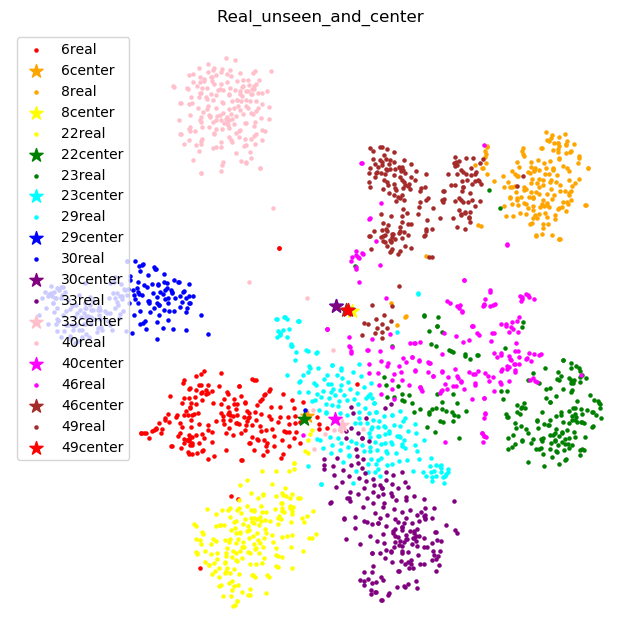

In [225]:
netA.eval()
att_trans, vout = netA(dataset.attribute.cuda(), train=True)
vout = vout.detach().cpu().numpy()
aout, _ = netA(dataset.attribute.cuda(), train=False)
aout = aout.detach().cpu().numpy()

unseen_label = dataset.test_unseen_label.numpy()
unseen_sample = dataset.test_unseen_feature.numpy()

netG.eval()
R_sample = np.array([]).reshape(-1, opt.x_dim)
R_label = np.array([]).reshape(-1)

for i in dataset.unseenclasses:
    temp_x = unseen_sample[unseen_label==int(i)][:200]
    R_sample = np.vstack((R_sample, temp_x))
    R_label = np.hstack((R_label, np.array([i]*len(temp_x))))

# 2-dim 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
unseen_tsne = tsne.fit_transform(np.vstack((R_sample, vout)))
unseen_tsne_label = np.hstack((R_label))
center_tsne = unseen_tsne[-50:]

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8),dpi=100)

#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']

for index, cla in enumerate(dataset.unseenclasses.numpy()[:10]):
    cla = int(cla)
    class_index = np.where(unseen_tsne_label == cla)[0].tolist()
    real_index = [idx for idx in class_index]
    plt.scatter(unseen_tsne[real_index,0], unseen_tsne[real_index,1],  c=cs[index], s=5, label=str(cla)+'real')
    plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[(index+1)%10], s=100, marker='*', label=str(cla)+'center')

plt.legend() 
plt.title('Real_unseen_and_center')

Text(0.5, 1.0, 'Real_seen_and_center')

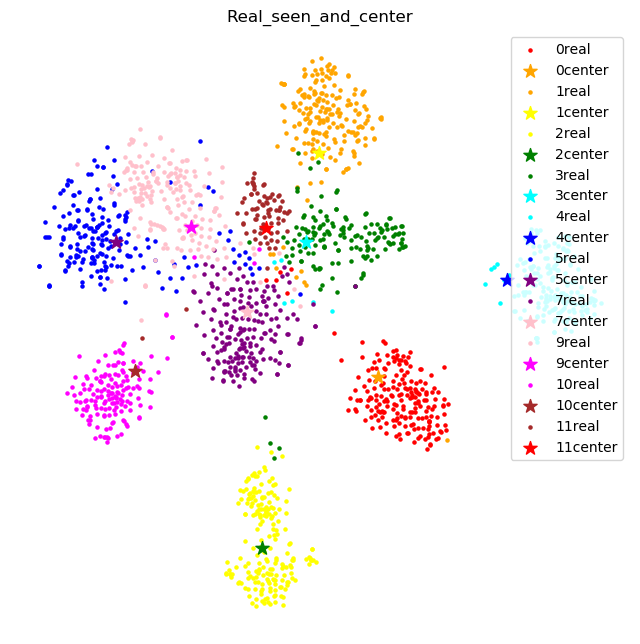

In [221]:

# 产生的属性转换在真实样本中心点的分布 on seen
seen_label = dataset.train_label.numpy()
seen_sample = dataset.train_feature.numpy()

netG.eval()
R_sample = np.array([]).reshape(-1, opt.x_dim)
R_label = np.array([]).reshape(-1)

for i in dataset.seenclasses[:10]:
    temp_x = seen_sample[seen_label==int(i)][:200]
    R_sample = np.vstack((R_sample, temp_x))
    R_label = np.hstack((R_label, np.array([i]*len(temp_x))))

# 2-dim 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
seen_tsne = tsne.fit_transform(np.vstack((R_sample, vout)))
seen_tsne_label = np.hstack((R_label))
center_tsne = seen_tsne[-50:]

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8),dpi=100)

#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']

for index, cla in enumerate(dataset.seenclasses.numpy()[:10]):
    cla = int(cla)
    class_index = np.where(seen_tsne_label == cla)[0].tolist()
    real_index = [idx for idx in class_index]
    plt.scatter(seen_tsne[real_index,0], seen_tsne[real_index,1],  c=cs[index], s=5, label=str(cla)+'real')
    plt.scatter(center_tsne[cla,0], center_tsne[cla,1],  c=cs[(index+1)%10], s=100, marker='*', label=str(cla)+'center')

plt.legend() 
plt.title('Real_seen_and_center')


In [52]:
from sklearn.neighbors import NearestNeighbors
# mask住unseen类的attribute，将搜索空间限制在seen类
mask_attribute = np.zeros((dataset.attribute.shape))
for idx, att in enumerate(dataset.attribute):
    mask_attribute[idx] = att if idx in np.unique(dataset.train_label.numpy()) else np.zeros(dataset.attribute.shape[-1])
class_knn = NearestNeighbors(n_neighbors=dataset.attribute.shape[0], metric="cosine").fit(mask_attribute)


In [253]:
# dis, ind = class_knn.kneighbors(dataset.attribute)
# class_dic = {}  # 记录每一个类在train_classes中的相似类的序号,通过attribute寻找相似类

# dis[dis==0] = 1  # dis==0: 表示自己
# dis_dict = {}
# for i in range(dataset.attribute.shape[0]):
#     for j in range(dataset.attribute.shape[0]):
#         dis_dict[(i, ind[i,j])] = dis[i][j]

_, ind = class_knn.kneighbors(dataset.attribute)
names = [i.split('\t')[-1].strip() for i in open('data/AwA2/classes.txt').readlines()]
class_dic = {}  # 记录每一个类在train_classes中的相似类的序号,通过attribute寻找相似类
invalid_c = [] # 标记已被选为unseen类的source类，避免unseen类来自于同一个seen类 
# TODO 改为一个动态规划，使得10个unseen到seen的总距离最小。
print('find target seen class for unseen')
for c in dataset.unseenclasses.numpy():
    temp = []
    for tar in ind[c]:
        if tar in invalid_c:
            continue
        elif len(temp) >= opt.k_class:
            break
        else:
            temp.append(tar)
            invalid_c.append(tar)
    class_dic[c] = temp
    print(c,'->', temp[0], names[c], '->', names[temp[0]])
print('find target seen class with longest distance for paired seen')
invalid_cc = []
for c in invalid_c:  # 用于生成unseen的seen类。为了避免与生成的unseen类分布重合，为它们选择距离最远的seen类作为source。
    temp = []
    for tar in ind[c][1:][::-1]:
        if tar in invalid_cc or tar in dataset.unseenclasses or tar == c:
            continue
        elif len(temp) >= opt.k_class:
            break
        else:
            temp.append(tar)
            invalid_cc.append(tar)
    class_dic[c] = temp
    print(c,'->', temp[0], names[c], '->', names[temp[0]])
print('find target seen class for left seen')
left_seen = [i for i in dataset.seenclasses.numpy() if i not in invalid_c]
for c in left_seen:
    temp = []
    for tar in ind[c][1:]:
        if tar in invalid_cc or tar in dataset.unseenclasses or tar == c:
            continue
        elif len(temp) >= opt.k_class:
            break
        else:
            temp.append(tar)
            invalid_cc.append(tar)
    class_dic[c] = temp
    print(c,'->', temp[0], names[c], '->', names[temp[0]])

find target seen class for unseen
6 -> 39 horse -> deer
8 -> 17 blue+whale -> humpback+whale
22 -> 48 sheep -> cow
23 -> 35 seal -> otter
29 -> 34 bat -> weasel
30 -> 0 giraffe -> antelope
33 -> 43 rat -> mouse
40 -> 14 bobcat -> leopard
46 -> 2 walrus -> killer+whale
49 -> 3 dolphin -> beaver
find target seen class with longest distance for paired seen
39 -> 2 deer -> killer+whale
17 -> 32 humpback+whale -> chihuahua
48 -> 17 cow -> humpback+whale
35 -> 27 otter -> rhinoceros
34 -> 13 weasel -> hippopotamus
0 -> 35 antelope -> otter
43 -> 44 mouse -> polar+bear
14 -> 18 leopard -> elephant
2 -> 26 killer+whale -> squirrel
3 -> 37 beaver -> zebra
find target seen class for left seen
1 -> 7 grizzly+bear -> german+shepherd
4 -> 45 dalmatian -> collie
5 -> 9 persian+cat -> siamese+cat
7 -> 31 german+shepherd -> wolf
9 -> 5 siamese+cat -> persian+cat
10 -> 47 skunk -> raccoon
11 -> 25 mole -> hamster
12 -> 14 tiger -> leopard
13 -> 20 hippopotamus -> ox
15 -> 36 moose -> buffalo
16 -> 24 s

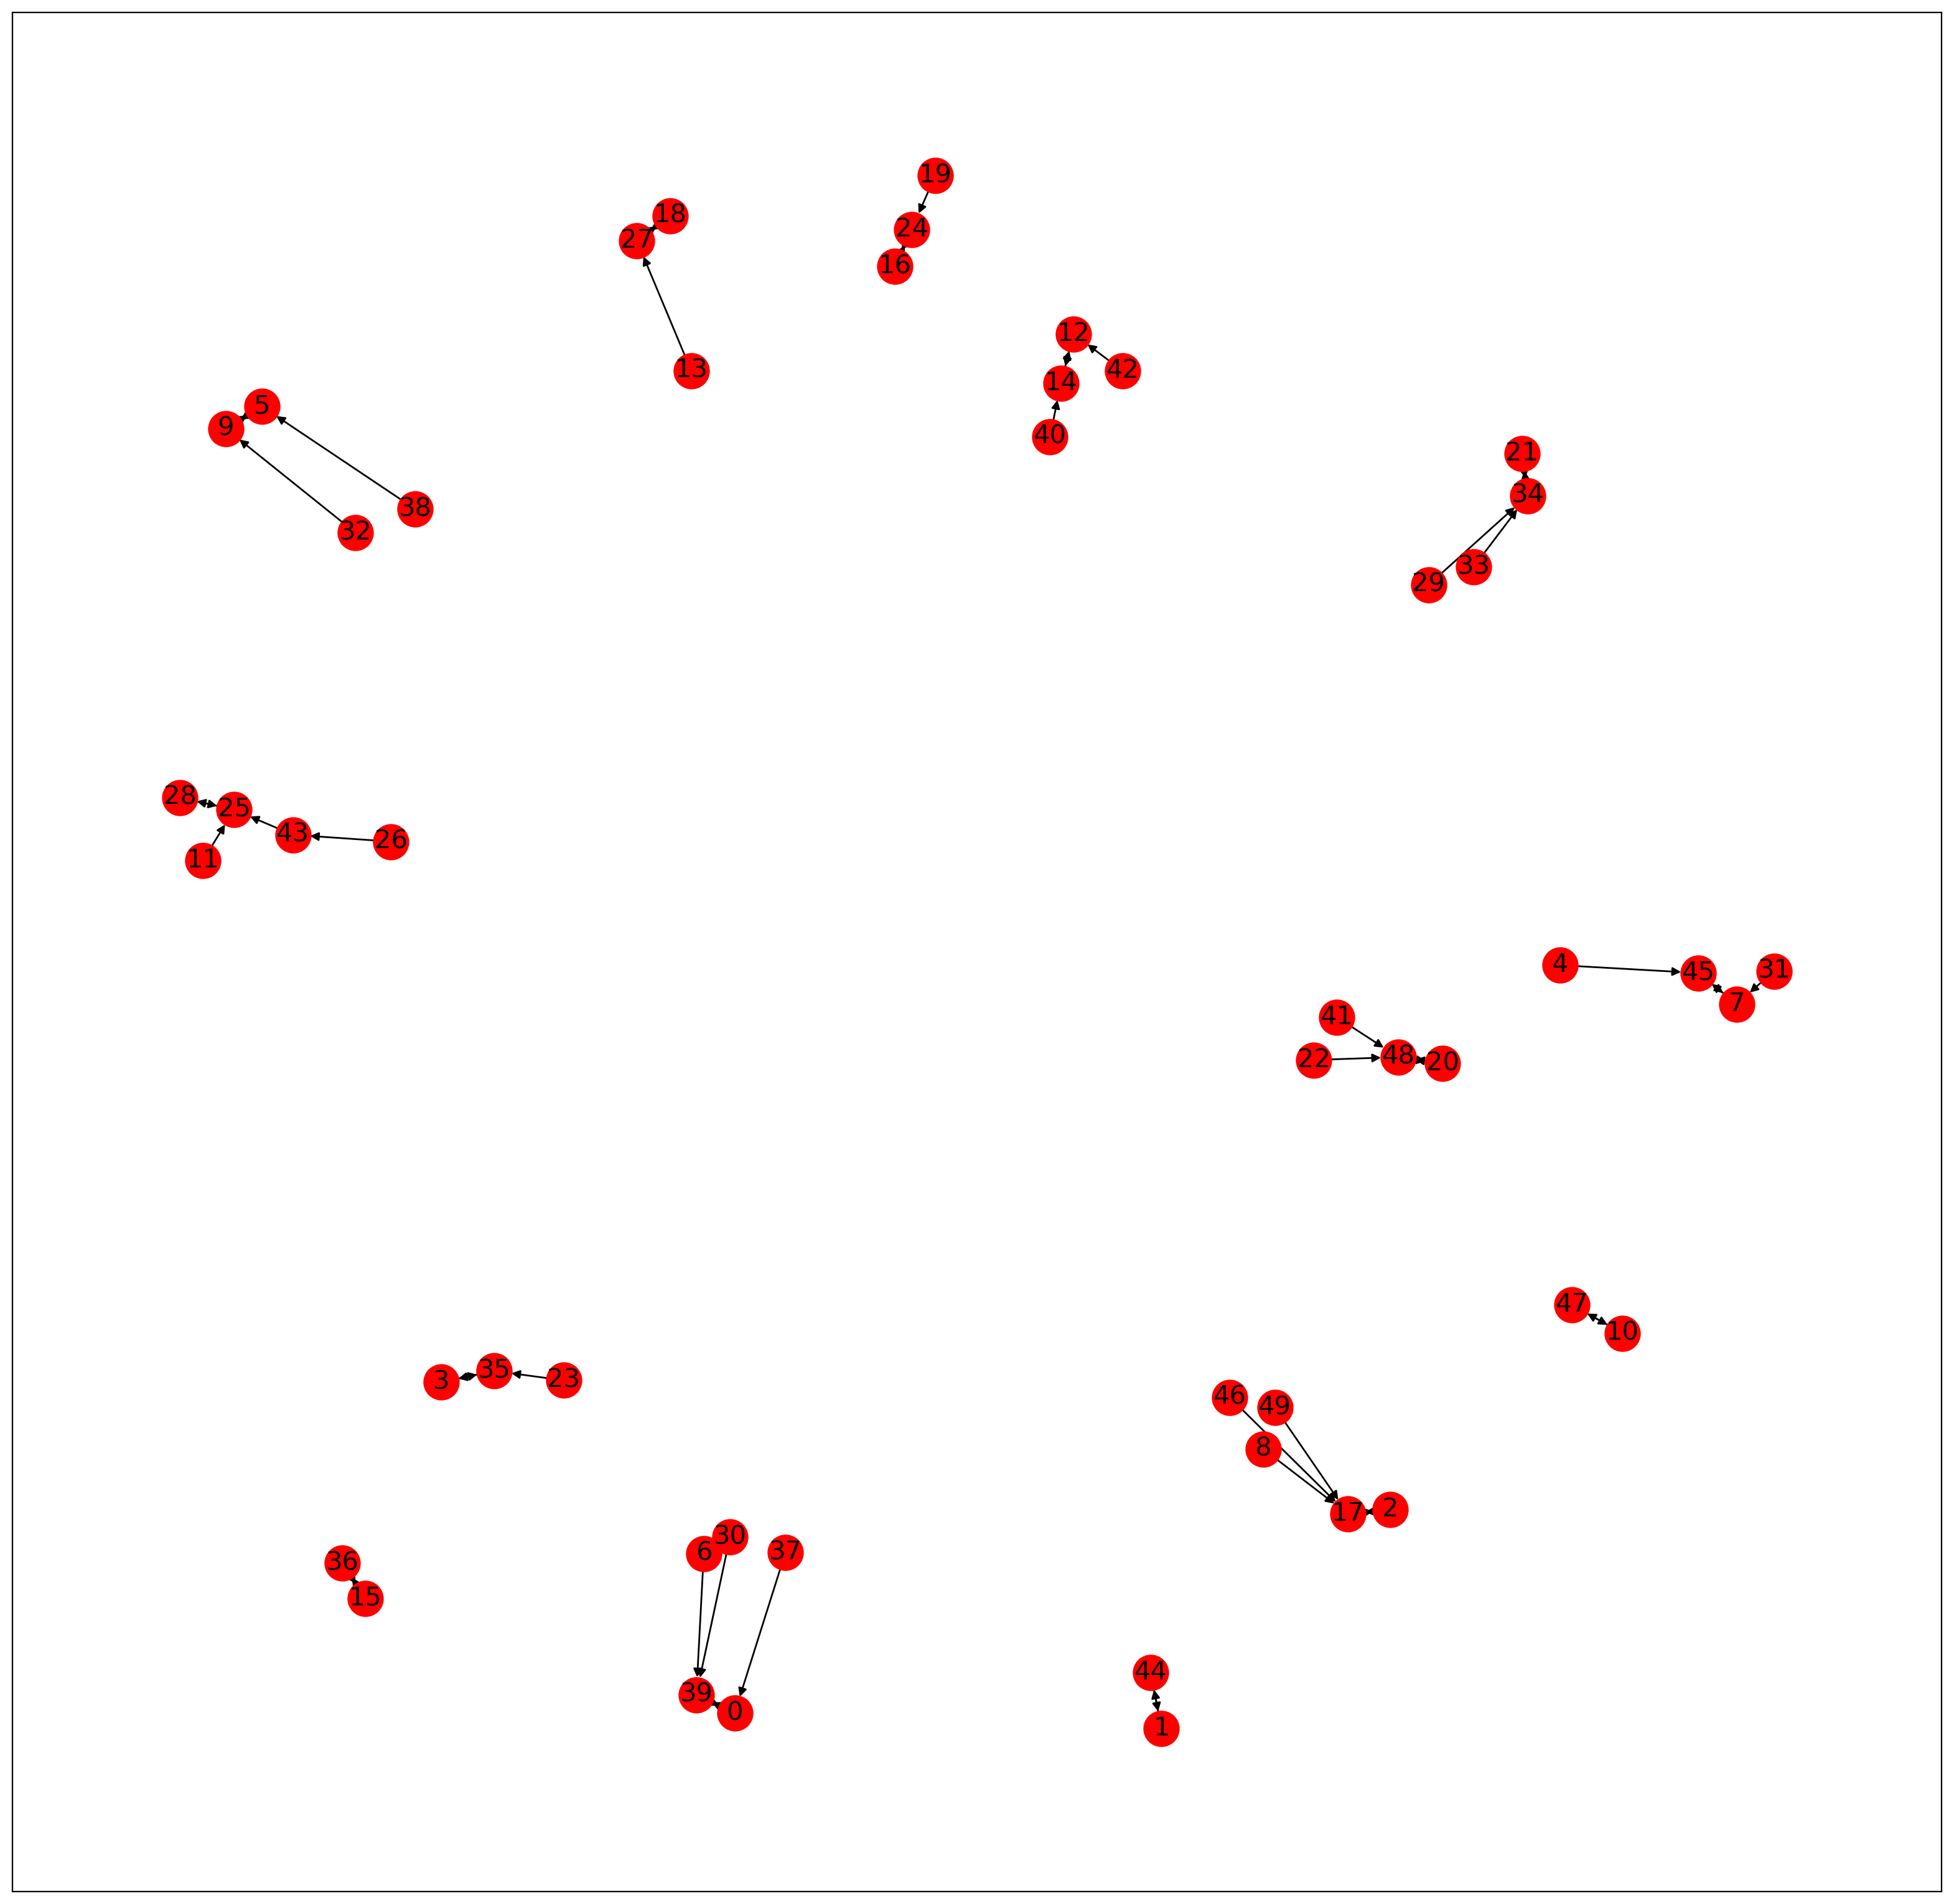

In [128]:
import networkx as nx
G=nx.DiGraph()#创建空的简单有向图
names = [i.split('\t')[-1].strip() for i in open('data/AwA2/classes.txt').readlines()]
for s, t in class_dic.items():
#     G.add_node(s)#加1这个点
#     G.add_node(t[0])#用(1,1)这个坐标加点
    # print(s, t[0], f'{names[s]} -> {names[t[0]]}')
    G.add_edge(s, t[0])#加边，起点是1终点是2


from matplotlib import pyplot as plt
import networkx as nx

plt.figure(figsize=(20, 20),dpi=200)
nx.draw_networkx(G, node_color='r', node_size=400, font_size=15)
plt.savefig('most_similar_class_pair.jpg')
plt.show()


In [104]:
G.edges()

OutEdgeView([(0, 39), (39, 0), (1, 44), (44, 1), (2, 17), (17, 2), (3, 35), (35, 3), (4, 45), (45, 7), (5, 9), (9, 5), (6, 39), (7, 45), (8, 17), (10, 47), (47, 10), (11, 25), (25, 28), (12, 14), (14, 12), (13, 27), (27, 18), (15, 36), (36, 15), (16, 24), (24, 16), (18, 27), (19, 24), (20, 48), (48, 20), (21, 34), (34, 21), (22, 48), (23, 35), (28, 25), (26, 43), (43, 25), (29, 34), (30, 39), (31, 7), (32, 9), (33, 34), (37, 0), (38, 5), (40, 14), (41, 48), (42, 12), (46, 17), (49, 17)])

In [25]:
r.shape

torch.Size([10, 256])

Text(0.5, 1.0, 'attribute_query_matrix')

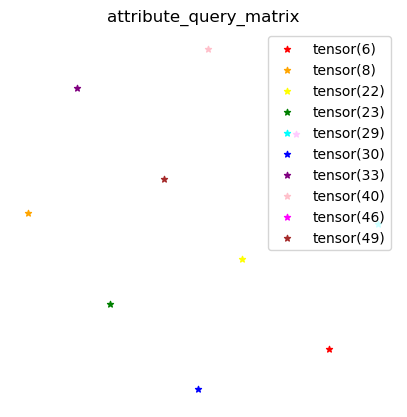

In [30]:
w = netG.query.weight
b = netG.query.bias
r = torch.matmul(dataset.attribute[dataset.unseenclasses], w.detach().cpu().T) + b.detach().cpu()
# 2-dim 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
unseen_tsne = tsne.fit_transform(r)

%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5),dpi=100)
#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.axis('off')  #去掉坐标轴
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
for idx, cla in enumerate(dataset.unseenclasses):
    plt.scatter(unseen_tsne[idx,0], unseen_tsne[idx,1], marker='*', c=cs[idx], s=20, label=cla)

plt.legend() 
plt.title('attribute_query_matrix')
